<a href="https://colab.research.google.com/github/javmencia/COBWEBfiles/blob/main/PCautoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CLINICAL EARLY WARNING SYSTEM FOR MORTALITY PREDICTION

1. Loading data...
   Loaded 8121 samples with 101 features

Data summary:
  Total samples: 8121
  Death events (os_event=1): 1098
  Missing VISDAY: 65
  DSDAY available: 1265 non-NA values
CLINICAL EARLY WARNING SYSTEM FOR MORTALITY PREDICTION
Prediction horizon: 90 days
Looking for death events within next 90 days

1. Processing temporal data...
----------------------------------------
Removed 65 rows with missing survival data
Using 'RPT' as patient identifier
Calculating time-to-event for each visit...
Processing 526 patients...
  Processed 0/526 patients...
  Processed 200/526 patients...
  Processed 400/526 patients...
Processed 8056 visits from 526 patients
Patients with event: 76
Patients without event: 450
Visits with future event: 0

2. Selecting and preparing features...
----------------------------------------
Found 35 available features out of 56 possible
Preparing features...
Using 35 available features
Processing 34

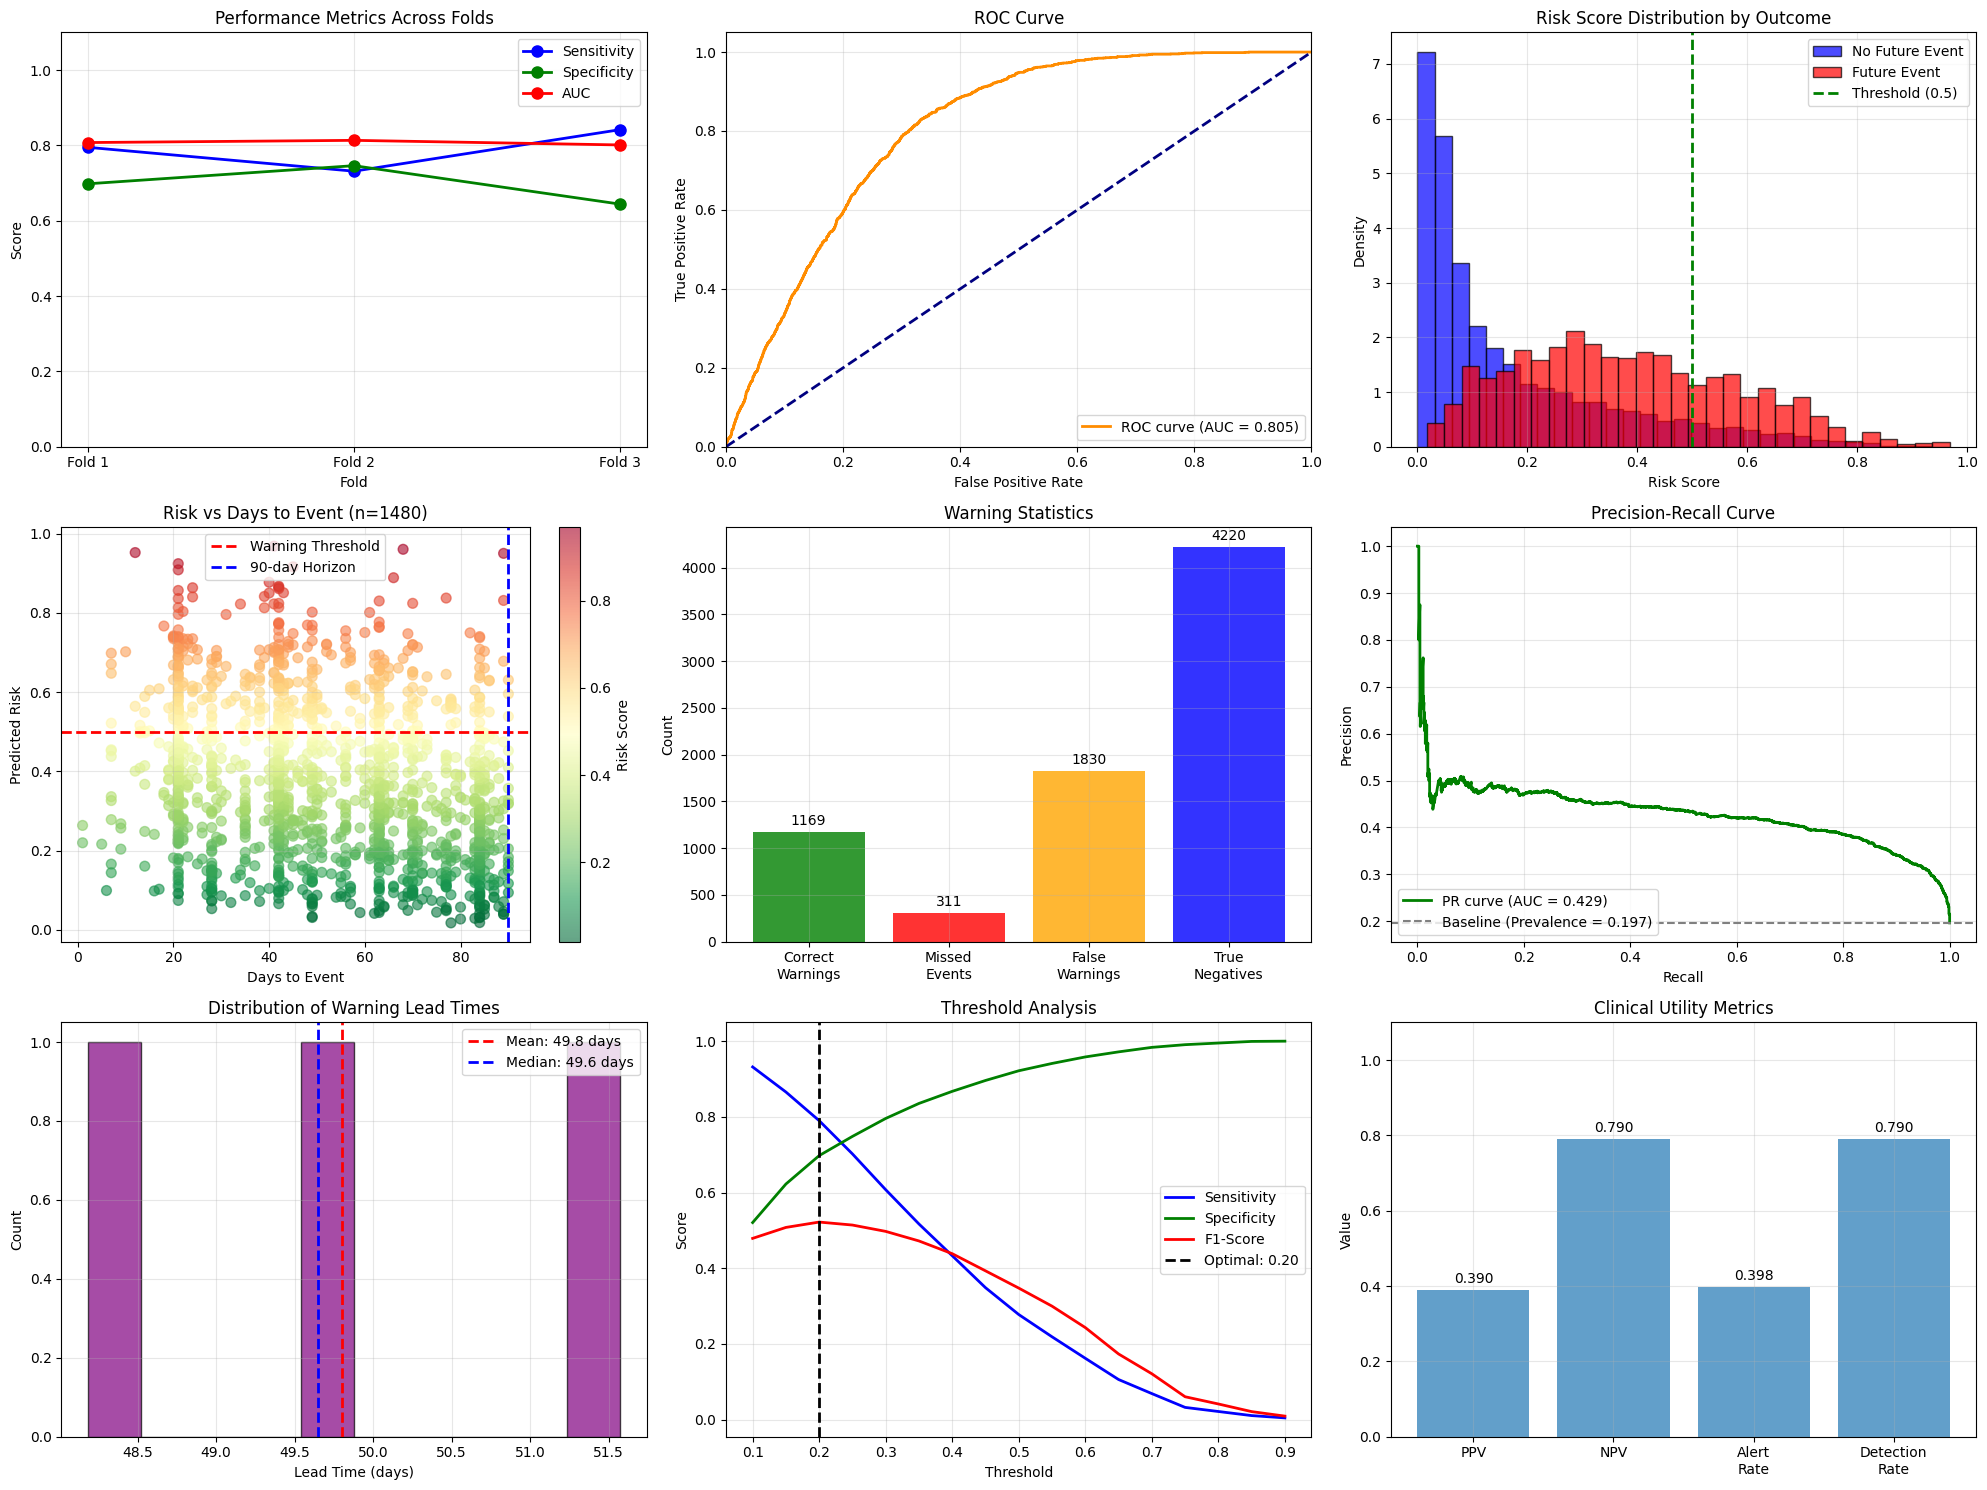


CLINICAL EARLY WARNING SYSTEM COMPLETED!

CLINICAL IMPLICATIONS:
--------------------------------------------------
1. System predicts death within next 90 days
2. Risk scores range from 0 (low risk) to 1 (high risk)
3. Threshold of 0.5 typically used for warnings
4. Lead time = days between warning and actual event

Based on your data:
- 1098 patients died during follow-up
- System trained on 7530 patient sequences
- Prediction horizon: 90 days


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

class RobustTimeAwareDataProcessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoders = {}

    def clean_data(self, df):
        """Clean data by handling infinity, large values, and missing data"""
        df_clean = df.copy()

        # Replace infinity with NaN
        df_clean = df_clean.replace([np.inf, -np.inf], np.nan)

        # Handle extremely large values by capping at 99th percentile
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df_clean[col].notna().any():
                # Cap at 99th percentile
                p99 = df_clean[col].quantile(0.99)
                if not np.isnan(p99):
                    df_clean[col] = df_clean[col].clip(upper=p99 * 10)  # Allow some margin

        return df_clean

    def process_patient_data(self, df):
        """Process data with proper temporal structure"""
        # Clean data first
        df_clean = self.clean_data(df)

        # Handle missing survival data
        missing_before = len(df_clean)
        df_clean = df_clean.dropna(subset=['VISDAY', 'os_event'])
        missing_after = len(df_clean)
        print(f"Removed {missing_before - missing_after} rows with missing survival data")

        # Create patient IDs if not present
        if 'patient_id' not in df_clean.columns:
            # Try to find a patient identifier column
            possible_id_cols = ['RPT', 'SUBJID', 'PATIENT', 'patient', 'id', 'ID']
            found_id = False
            for col in possible_id_cols:
                if col in df_clean.columns:
                    df_clean['patient_id'] = df_clean[col]
                    print(f"Using '{col}' as patient identifier")
                    found_id = True
                    break

            if not found_id:
                # Create synthetic patient IDs (assuming ~5 visits per patient)
                df_clean['patient_id'] = np.arange(len(df_clean)) // 5
                print("Created synthetic patient IDs (5 visits per patient)")

        # Sort by patient and visit day
        df_sorted = df_clean.sort_values(['patient_id', 'VISDAY']).reset_index(drop=True)

        # Calculate time to event for each visit
        print("Calculating time-to-event for each visit...")
        df_sorted['time_to_event'] = np.nan
        df_sorted['is_future_event'] = 0

        unique_patients = df_sorted['patient_id'].unique()
        print(f"Processing {len(unique_patients)} patients...")

        for i, pid in enumerate(unique_patients):
            if i % 200 == 0:
                print(f"  Processed {i}/{len(unique_patients)} patients...")

            patient_data = df_sorted[df_sorted['patient_id'] == pid]

            # Check if patient died (os_event = 1)
            patient_events = patient_data['os_event'].values
            if np.any(patient_events == 1):
                # Patient died - find death day
                death_idx = np.where(patient_events == 1)[0]
                if len(death_idx) > 0:
                    death_day = patient_data.iloc[death_idx[0]]['VISDAY']

                    # For all visits before death, calculate days to death
                    for idx, row in patient_data.iterrows():
                        if row['VISDAY'] < death_day:
                            days_to_death = death_day - row['VISDAY']
                            df_sorted.at[idx, 'time_to_event'] = days_to_death
                            df_sorted.at[idx, 'is_future_event'] = 1
                        elif row['VISDAY'] == death_day:
                            # Death visit itself
                            df_sorted.at[idx, 'time_to_event'] = 0
                            df_sorted.at[idx, 'is_future_event'] = 0  # Not a future event
            else:
                # Patient survived - use maximum follow-up time
                last_visit_day = patient_data['VISDAY'].max()

                for idx, row in patient_data.iterrows():
                    days_from_last = last_visit_day - row['VISDAY']
                    df_sorted.at[idx, 'time_to_event'] = days_from_last
                    df_sorted.at[idx, 'is_future_event'] = 0

        # Handle any remaining NaN values in time_to_event
        nan_count = df_sorted['time_to_event'].isna().sum()
        if nan_count > 0:
            print(f"Warning: {nan_count} NaN values in time_to_event, filling with median")
            median_ttd = df_sorted['time_to_event'].median()
            df_sorted['time_to_event'] = df_sorted['time_to_event'].fillna(median_ttd)

        print(f"Processed {len(df_sorted)} visits from {len(unique_patients)} patients")

        # Count patients with events
        event_patients = df_sorted[df_sorted['os_event'] == 1]['patient_id'].unique()
        no_event_patients = df_sorted[df_sorted['os_event'] == 0]['patient_id'].unique()

        print(f"Patients with event: {len(event_patients)}")
        print(f"Patients without event: {len(no_event_patients)}")
        print(f"Visits with future event: {df_sorted['is_future_event'].sum()}")

        return df_sorted

    def create_temporal_sequences(self, df, feature_cols, max_sequence_length=5, prediction_horizon=90):
        """Create sequences with proper temporal structure"""
        print("Creating temporal sequences...")
        sequences = []
        labels = []
        time_intervals = []
        patient_ids = []
        days_to_event_list = []

        unique_patients = df['patient_id'].unique()

        for pid in unique_patients:
            patient_data = df[df['patient_id'] == pid].sort_values('VISDAY')

            if len(patient_data) < 2:
                continue  # Need at least 2 visits

            # Get features and temporal data
            patient_features = patient_data[feature_cols].values
            patient_visdays = patient_data['VISDAY'].values
            patient_time_to_event = patient_data['time_to_event'].values
            patient_has_event = patient_data['is_future_event'].values

            # Create sequences
            for i in range(1, len(patient_data)):  # Start from 1 to have at least one previous visit
                # Determine sequence length (up to max_sequence_length)
                seq_len = min(i, max_sequence_length)
                start_idx = i - seq_len

                # Get sequence data
                seq_features = patient_features[start_idx:i+1]  # Including current visit
                seq_visdays = patient_visdays[start_idx:i+1]

                # Calculate time intervals between visits (in days)
                if len(seq_visdays) > 1:
                    time_diffs = np.diff(seq_visdays)
                    # Add a default 30-day interval for the first gap
                    time_diffs = np.concatenate([[30], time_diffs])
                else:
                    time_diffs = np.array([30])

                # Normalize time intervals (divide by 30 to get approximate months)
                time_diffs_normalized = time_diffs / 30.0

                # Create label: will event occur within prediction horizon?
                current_time_to_event = patient_time_to_event[i]
                if current_time_to_event <= prediction_horizon and current_time_to_event > 0:
                    label = 1  # Event will occur within horizon
                else:
                    label = 0  # No event within horizon

                # Pad sequence if needed
                if seq_len < max_sequence_length:
                    pad_len = max_sequence_length - seq_len
                    seq_features = np.pad(seq_features, ((pad_len, 0), (0, 0)), mode='constant')
                    time_diffs_normalized = np.pad(time_diffs_normalized, (pad_len, 0),
                                                  mode='constant', constant_values=1.0)  # 1 month for padding

                sequences.append(seq_features)
                labels.append(label)
                time_intervals.append(time_diffs_normalized)
                patient_ids.append(pid)
                days_to_event_list.append(current_time_to_event)

        sequences = np.array(sequences)
        labels = np.array(labels)
        time_intervals = np.array(time_intervals)
        patient_ids = np.array(patient_ids)

        print(f"\nCreated {len(sequences)} sequences")
        print(f"Positive sequences (event within {prediction_horizon} days): {np.sum(labels == 1)} ({np.mean(labels == 1)*100:.1f}%)")
        print(f"Negative sequences: {np.sum(labels == 0)}")

        # Analyze positive sequences
        if np.sum(labels == 1) > 0:
            positive_days = np.array(days_to_event_list)[labels == 1]
            print(f"Days to event for positive sequences:")
            print(f"  Mean: {np.mean(positive_days):.1f} days")
            print(f"  Median: {np.median(positive_days):.1f} days")
            print(f"  Range: {np.min(positive_days):.1f} to {np.max(positive_days):.1f} days")

        return sequences, labels, time_intervals, patient_ids, days_to_event_list

    def prepare_features(self, df, feature_names):
        """Prepare features for modeling with robust handling"""
        print("Preparing features...")

        # Select features that exist in dataframe
        available_features = [f for f in feature_names if f in df.columns]
        print(f"Using {len(available_features)} available features")

        # Handle missing values
        df_filled = df[available_features].copy()

        # Replace any remaining infinity values
        df_filled = df_filled.replace([np.inf, -np.inf], np.nan)

        # Fill numeric missing values with median
        numeric_cols = df_filled.select_dtypes(include=[np.number]).columns
        print(f"Processing {len(numeric_cols)} numeric columns...")

        for col in numeric_cols:
            if df_filled[col].isnull().any():
                median_val = df_filled[col].median()
                if pd.isna(median_val):
                    median_val = 0  # Fallback
                df_filled[col] = df_filled[col].fillna(median_val)

        # Fill categorical missing values with mode
        categorical_cols = df_filled.select_dtypes(exclude=[np.number]).columns
        print(f"Processing {len(categorical_cols)} categorical columns...")

        for col in categorical_cols:
            if df_filled[col].isnull().any():
                mode_val = df_filled[col].mode()
                if len(mode_val) > 0:
                    df_filled[col] = df_filled[col].fillna(mode_val[0])
                else:
                    df_filled[col] = df_filled[col].fillna('missing')

        # Encode categorical variables
        print("Encoding categorical variables...")
        for col in categorical_cols:
            try:
                if col not in self.label_encoders:
                    self.label_encoders[col] = LabelEncoder()
                    # Handle any non-string values
                    col_data = df_filled[col].astype(str)
                    self.label_encoders[col].fit(col_data)

                df_filled[col] = self.label_encoders[col].transform(df_filled[col].astype(str))
            except Exception as e:
                print(f"Warning: Could not encode column {col}: {e}")
                # Drop problematic column
                df_filled = df_filled.drop(columns=[col])
                available_features.remove(col)

        # Scale numeric features
        if len(numeric_cols) > 0:
            print("Scaling numeric features...")
            # Check for any remaining issues
            numeric_data = df_filled[numeric_cols].values
            if np.any(np.isnan(numeric_data)) or np.any(np.isinf(numeric_data)):
                print("Warning: NaN or Inf found in numeric data after cleaning")
                # Replace with zeros as last resort
                numeric_data = np.nan_to_num(numeric_data, nan=0.0, posinf=1e6, neginf=-1e6)
                df_filled[numeric_cols] = numeric_data

            try:
                df_filled[numeric_cols] = self.scaler.fit_transform(df_filled[numeric_cols])
            except Exception as e:
                print(f"Warning: Could not scale features: {e}")
                # Use min-max scaling as fallback
                for col in numeric_cols:
                    col_min = df_filled[col].min()
                    col_max = df_filled[col].max()
                    if col_max > col_min:
                        df_filled[col] = (df_filled[col] - col_min) / (col_max - col_min)
                    else:
                        df_filled[col] = 0

        print(f"Final feature matrix shape: {df_filled.shape}")
        return df_filled.values, available_features


class TimeAwareEarlyWarningModel:
    def __init__(self, input_dim, sequence_length=5, lstm_units=64):
        self.input_dim = input_dim
        self.sequence_length = sequence_length
        self.lstm_units = lstm_units
        self.model = None
        self.history = None

    def build_model_with_time_awareness(self):
        """Build model that incorporates time intervals between visits"""
        # Two input layers: features and time intervals
        feature_input = layers.Input(shape=(self.sequence_length, self.input_dim), name='features')
        time_input = layers.Input(shape=(self.sequence_length, 1), name='time_intervals')

        # Process time intervals
        time_processed = layers.Dense(8, activation='relu')(time_input)
        time_processed = layers.Dense(16, activation='relu')(time_processed)

        # Concatenate features with time information
        combined = layers.Concatenate(axis=-1)([feature_input, time_processed])

        # LSTM layers
        lstm_out = layers.Bidirectional(layers.LSTM(self.lstm_units, return_sequences=True))(combined)
        lstm_out = layers.Dropout(0.3)(lstm_out)

        # Simple attention mechanism
        attention_scores = layers.TimeDistributed(layers.Dense(1, activation='tanh'))(lstm_out)
        attention_weights = layers.Softmax(axis=1)(attention_scores)
        context_vector = layers.Multiply()([lstm_out, attention_weights])

        # Global average pooling instead of just last time step
        pooled = layers.GlobalAveragePooling1D()(context_vector)

        # Dense layers
        dense1 = layers.Dense(64, activation='relu')(pooled)
        dense1 = layers.BatchNormalization()(dense1)
        dense1 = layers.Dropout(0.3)(dense1)

        dense2 = layers.Dense(32, activation='relu')(dense1)
        dense2 = layers.BatchNormalization()(dense2)
        dense2 = layers.Dropout(0.2)(dense2)

        # Output: risk of event within prediction horizon
        risk_score = layers.Dense(1, activation='sigmoid', name='risk_score')(dense2)

        # Create model
        self.model = models.Model(inputs=[feature_input, time_input], outputs=risk_score)

        return self.model

    def compile_model(self, learning_rate=0.001):
        """Compile the model"""
        self.model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall')]
        )

        return self.model

    def train(self, X_features, X_time, y_train, val_data=None, epochs=100, batch_size=32, class_weight=None):
        """Train the model"""
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss' if val_data else 'loss',
            patience=15,
            restore_best_weights=True,
            min_delta=0.001,
            verbose=0
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss' if val_data else 'loss',
            factor=0.5,
            patience=8,
            min_lr=1e-6,
            verbose=0
        )

        callbacks_list = [early_stopping, reduce_lr]

        if val_data:
            X_val_features, X_val_time, y_val = val_data
            validation_data = ([X_val_features, X_val_time], y_val)
        else:
            validation_data = None

        self.history = self.model.fit(
            [X_features, X_time], y_train,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks_list,
            verbose=0,
            class_weight=class_weight
        )

        return self.history

    def predict(self, X_features, X_time):
        """Make predictions"""
        return self.model.predict([X_features, X_time], verbose=0).flatten()


class ClinicalEarlyWarningPipeline:
    def __init__(self, prediction_horizon_days=90, n_splits=3, random_state=42):
        self.prediction_horizon = prediction_horizon_days
        self.n_splits = n_splits
        self.random_state = random_state
        self.data_processor = RobustTimeAwareDataProcessor()
        self.results = {}

    def select_clinical_features(self, df):
        """Select relevant clinical features for early warning"""
        # Common clinical features for mortality prediction
        base_features = [
            'AGE', 'SEX', 'RACE',  # Demographics
            'BMI', 'WEIGHT', 'HEIGHT',  # Anthropometrics
            'ECOG', 'KPS',  # Performance status
        ]

        # Lab values (if available)
        lab_features = [
            'ALB', 'ALP', 'ALT', 'AST', 'BILI', 'CALCIUM', 'CREAT', 'HGB',
            'LYMPH', 'NEUT', 'PLAT', 'WBC', 'SODIUM', 'POTASSIUM', 'GLUCOSE',
            'BUN', 'CRP', 'LDH'
        ]

        # Treatment and AE features from your data
        treatment_features = [
            'cycle_number', 'total_cycles', 'anytarget', 'anynontarget',
            'total_ae_events', 'serious_ae_count', 'grade3_plus_count',
            'any_grade3_plus', 'treatment_related_count', 'any_treatment_related',
            'grade1_count', 'grade2_count', 'grade3_count', 'grade4_count',
            'drug_interrupted', 'drug_reduced', 'drug_withdrawn', 'drug_not_changed',
            'other_drug_interrupted', 'other_drug_reduced', 'other_drug_withdrawn',
            'concomitant_treatment_given', 'cum_any_grade3_plus',
            'cum_any_treatment_related', 'cum_drug_withdrawn',
            'cum_other_drug_withdrawn', 'cum_concomitant_treatment',
            'ongoing_ae_count', 'mean_ae_duration', 'max_ae_duration'
        ]

        # Combine and check availability
        all_possible = base_features + lab_features + treatment_features
        available_features = [f for f in all_possible if f in df.columns]

        print(f"Found {len(available_features)} available features out of {len(all_possible)} possible")

        # If we have very few features, use some defaults
        if len(available_features) < 10:
            print("Warning: Few features available, using basic set")
            # Try to find any numeric columns
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            # Exclude ID and date columns
            exclude_cols = ['VISDAY', 'DSDAY', 'patient_id', 'id', 'index', 'time_to_event', 'is_future_event']
            numeric_cols = [c for c in numeric_cols if c not in exclude_cols]
            available_features = numeric_cols[:20]  # Take first 20 numeric columns

        return available_features

    def run_pipeline(self, pcdata):
        """Run the complete early warning pipeline"""
        print("="*70)
        print("CLINICAL EARLY WARNING SYSTEM FOR MORTALITY PREDICTION")
        print("="*70)
        print(f"Prediction horizon: {self.prediction_horizon} days")
        print(f"Looking for death events within next {self.prediction_horizon} days")

        # Step 1: Process data with temporal structure
        print("\n1. Processing temporal data...")
        print("-"*40)

        df_processed = self.data_processor.process_patient_data(pcdata)

        # Step 2: Prepare features
        print("\n2. Selecting and preparing features...")
        print("-"*40)

        feature_names = self.select_clinical_features(df_processed)
        X_features, selected_features = self.data_processor.prepare_features(df_processed, feature_names)

        # Add processed features back to dataframe
        feature_cols = [f'feat_{i}' for i in range(X_features.shape[1])]
        for i in range(X_features.shape[1]):
            df_processed[f'feat_{i}'] = X_features[:, i]

        print(f"Using {len(feature_cols)} processed features")

        # Step 3: Create temporal sequences
        print("\n3. Creating temporal sequences...")
        print("-"*40)

        sequences, labels, time_intervals, patient_ids, days_to_event = self.data_processor.create_temporal_sequences(
            df_processed, feature_cols, max_sequence_length=5,
            prediction_horizon=self.prediction_horizon
        )

        if len(sequences) == 0:
            print("Error: No sequences created!")
            return None

        print(f"Sequence shape: {sequences.shape}")
        print(f"Time intervals shape: {time_intervals.shape}")
        print(f"Patient IDs type: {type(patient_ids)}, shape: {patient_ids.shape}")

        # Step 4: Analyze data balance
        print("\n4. Analyzing data balance...")
        print("-"*40)

        positive_rate = np.mean(labels == 1)
        print(f"Positive rate (event within {self.prediction_horizon} days): {positive_rate:.3f}")

        if positive_rate < 0.01:
            print("Warning: Very low positive rate, model may struggle to learn")
            print("Consider increasing prediction horizon or using different labeling")

        # Step 5: Cross-validation
        print("\n5. Running cross-validation...")
        print("-"*40)

        # Create patient-level splits
        unique_patients = np.unique(patient_ids)
        print(f"Unique patients in sequences: {len(unique_patients)}")

        # Get patient labels (max label across their sequences)
        patient_labels = []
        patient_days_to_event = []

        for pid in unique_patients:
            patient_mask = patient_ids == pid
            patient_label = np.max(labels[patient_mask])  # Patient has event if any sequence does
            patient_labels.append(patient_label)

            # Get min days to event for this patient
            if np.any(labels[patient_mask] == 1):
                min_days = np.min(np.array(days_to_event)[patient_mask])
                patient_days_to_event.append(min_days)

        patient_labels = np.array(patient_labels)

        print(f"Patients with future event in sequences: {np.sum(patient_labels == 1)}")
        print(f"Patients without future event in sequences: {np.sum(patient_labels == 0)}")

        if np.sum(patient_labels == 1) < 2:
            print(f"Error: Only {np.sum(patient_labels == 1)} patients with events")
            print("Cannot perform cross-validation. Using simple train/test split instead.")
            return self.run_simple_split(sequences, labels, time_intervals, patient_ids, days_to_event)

        n_folds = min(self.n_splits, np.sum(patient_labels == 1))
        if n_folds < self.n_splits:
            print(f"Reducing CV folds to {n_folds} (only {np.sum(patient_labels == 1)} patients with events)")

        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=self.random_state)

        cv_results = {
            'fold': [],
            'sensitivity': [], 'specificity': [], 'auc': [],
            'precision': [], 'recall': [], 'f1': [],
            'lead_times': [], 'warning_stats': [],
            'risk_scores': [], 'true_labels': [],
            'days_to_event': []
        }

        fold = 1
        for train_patient_idx, test_patient_idx in skf.split(unique_patients, patient_labels):
            print(f"\n{'='*60}")
            print(f"FOLD {fold}/{n_folds}")
            print(f"{'='*60}")

            # Get patient IDs for train/test
            train_patient_ids = unique_patients[train_patient_idx]
            test_patient_ids = unique_patients[test_patient_idx]

            print(f"Training patients: {len(train_patient_ids)}")
            print(f"Test patients: {len(test_patient_ids)}")

            # Create masks
            train_mask = np.isin(patient_ids, train_patient_ids)
            test_mask = np.isin(patient_ids, test_patient_ids)

            # Split data
            X_train_seq = sequences[train_mask]
            X_test_seq = sequences[test_mask]

            X_train_time = time_intervals[train_mask]
            X_test_time = time_intervals[test_mask]

            y_train = labels[train_mask]
            y_test = labels[test_mask]

            test_days_to_event = np.array(days_to_event)[test_mask]

            train_pids = patient_ids[train_mask]

            # Split training for validation
            unique_train_pids = np.unique(train_pids)
            val_patient_count = max(1, int(0.2 * len(unique_train_pids)))
            val_patient_ids = np.random.choice(unique_train_pids, val_patient_count, replace=False)
            val_mask = np.isin(train_pids, val_patient_ids)

            X_val_seq = X_train_seq[val_mask]
            X_val_time = X_train_time[val_mask]
            y_val = y_train[val_mask]

            X_train_seq_final = X_train_seq[~val_mask]
            X_train_time_final = X_train_time[~val_mask]
            y_train_final = y_train[~val_mask]

            print(f"Training sequences: {X_train_seq_final.shape[0]} (pos: {np.mean(y_train_final):.3f})")
            print(f"Validation sequences: {X_val_seq.shape[0]} (pos: {np.mean(y_val):.3f})")
            print(f"Test sequences: {X_test_seq.shape[0]} (pos: {np.mean(y_test):.3f})")

            # Handle class imbalance
            if np.sum(y_train_final) > 0:
                pos_weight = len(y_train_final) / (2 * np.sum(y_train_final))
                class_weight = {0: 1.0, 1: min(10.0, pos_weight)}  # Cap at 10x
            else:
                class_weight = {0: 1.0, 1: 1.0}

            # Step 6: Train model
            print("\n6. Training time-aware early warning model...")

            model = TimeAwareEarlyWarningModel(
                input_dim=X_train_seq_final.shape[2],
                sequence_length=X_train_seq_final.shape[1],
                lstm_units=32  # Reduced for stability
            )

            model.build_model_with_time_awareness()
            model.compile_model(learning_rate=0.001)

            try:
                history = model.train(
                    X_train_seq_final, X_train_time_final, y_train_final,
                    val_data=(X_val_seq, X_val_time, y_val),
                    epochs=50,  # Reduced for speed
                    batch_size=32,
                    class_weight=class_weight
                )

                # Check training history
                if history and 'loss' in history.history:
                    final_train_loss = history.history['loss'][-1]
                    final_val_loss = history.history.get('val_loss', [final_train_loss])[-1]
                    print(f"Final training loss: {final_train_loss:.4f}, validation loss: {final_val_loss:.4f}")
                else:
                    print("Warning: Training history not available")
                    final_train_loss = 0.5
                    final_val_loss = 0.5

            except Exception as e:
                print(f"Warning: Training failed: {e}")
                print("Skipping this fold...")
                fold += 1
                continue

            # Step 7: Evaluate
            print("\n7. Evaluating early warnings...")

            # Get predictions
            try:
                train_pred = model.predict(X_train_seq_final, X_train_time_final)
                test_pred = model.predict(X_test_seq, X_test_time)
            except Exception as e:
                print(f"Warning: Prediction failed: {e}")
                fold += 1
                continue

            # Find optimal threshold (maximizing F1 score)
            thresholds = np.linspace(0.1, 0.9, 17)
            best_f1 = 0
            best_threshold = 0.5

            for thresh in thresholds:
                pred_binary = (test_pred > thresh).astype(int)
                if np.sum(pred_binary) > 0 and np.sum(y_test) > 0:
                    try:
                        f1 = f1_score(y_test, pred_binary, zero_division=0)
                        if f1 > best_f1:
                            best_f1 = f1
                            best_threshold = thresh
                    except:
                        continue

            print(f"Optimal threshold: {best_threshold:.3f} (F1: {best_f1:.3f})")

            # Calculate metrics
            test_pred_binary = (test_pred > best_threshold).astype(int)

            # Handle cases with no predictions
            if np.sum(test_pred_binary) == 0:
                print("Warning: No positive predictions at this threshold")
                accuracy = accuracy_score(y_test, test_pred_binary)
                auc_score = 0.5
                precision = 0
                recall = 0
                f1 = 0
                tn = np.sum(y_test == 0)
                fp = 0
                fn = np.sum(y_test == 1)
                tp = 0
            elif np.sum(y_test) == 0:
                print("Warning: No positive cases in test set")
                accuracy = accuracy_score(y_test, test_pred_binary)
                auc_score = 0.5
                precision = 0
                recall = 0
                f1 = 0
                tn = np.sum((y_test == 0) & (test_pred_binary == 0))
                fp = np.sum((y_test == 0) & (test_pred_binary == 1))
                fn = 0
                tp = 0
            else:
                accuracy = accuracy_score(y_test, test_pred_binary)
                try:
                    auc_score = roc_auc_score(y_test, test_pred)
                except:
                    auc_score = 0.5
                precision = precision_score(y_test, test_pred_binary, zero_division=0)
                recall = recall_score(y_test, test_pred_binary, zero_division=0)
                f1 = f1_score(y_test, test_pred_binary, zero_division=0)

                # Calculate confusion matrix
                try:
                    cm = confusion_matrix(y_test, test_pred_binary)
                    if cm.shape == (2, 2):
                        tn, fp, fn, tp = cm.ravel()
                    else:
                        # Handle case where only one class predicted
                        tn = np.sum((y_test == 0) & (test_pred_binary == 0))
                        fp = np.sum((y_test == 0) & (test_pred_binary == 1))
                        fn = np.sum((y_test == 1) & (test_pred_binary == 0))
                        tp = np.sum((y_test == 1) & (test_pred_binary == 1))
                except:
                    tn = np.sum((y_test == 0) & (test_pred_binary == 0))
                    fp = np.sum((y_test == 0) & (test_pred_binary == 1))
                    fn = np.sum((y_test == 1) & (test_pred_binary == 0))
                    tp = np.sum((y_test == 1) & (test_pred_binary == 1))

            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            print(f"\nFold {fold} Results:")
            print(f"  Accuracy: {accuracy:.4f}")
            print(f"  AUC: {auc_score:.4f}")
            print(f"  Sensitivity: {sensitivity:.4f}")
            print(f"  Specificity: {specificity:.4f}")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall: {recall:.4f}")
            print(f"  F1-Score: {f1:.4f}")
            print(f"  TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

            # Store results
            cv_results['fold'].append(fold)
            cv_results['sensitivity'].append(sensitivity)
            cv_results['specificity'].append(specificity)
            cv_results['auc'].append(auc_score)
            cv_results['precision'].append(precision)
            cv_results['recall'].append(recall)
            cv_results['f1'].append(f1)
            cv_results['risk_scores'].extend(test_pred.tolist())
            cv_results['true_labels'].extend(y_test.tolist())
            cv_results['days_to_event'].extend(test_days_to_event.tolist())

            # Calculate lead times for correctly warned patients
            if tp > 0:
                # For TP cases, get actual days to event
                tp_mask = (y_test == 1) & (test_pred_binary == 1)
                if np.any(tp_mask):
                    tp_days = test_days_to_event[tp_mask]
                    avg_lead_time = np.mean(tp_days)
                    cv_results['lead_times'].append(avg_lead_time)

                    warning_stats = {
                        'correct_warnings': int(tp),
                        'missed_warnings': int(fn),
                        'false_warnings': int(fp),
                        'true_negatives': int(tn),
                        'avg_lead_time': float(avg_lead_time)
                    }
                else:
                    warning_stats = {
                        'correct_warnings': int(tp),
                        'missed_warnings': int(fn),
                        'false_warnings': int(fp),
                        'true_negatives': int(tn),
                        'avg_lead_time': 0.0
                    }
                cv_results['warning_stats'].append(warning_stats)

            fold += 1

        self.results = cv_results

        if not cv_results['fold']:
            print("\nERROR: No folds completed successfully!")
            print("Trying simple train/test split instead...")
            return self.run_simple_split(sequences, labels, time_intervals, patient_ids, days_to_event)

        # Step 8: Analyze results
        print("\n" + "="*70)
        print("COMPREHENSIVE EARLY WARNING ANALYSIS")
        print("="*70)

        self.analyze_results(cv_results)
        self.visualize_results(cv_results)

        return cv_results

    def run_simple_split(self, sequences, labels, time_intervals, patient_ids, days_to_event):
        """Run a simple train/test split when cross-validation fails"""
        print("\nRunning simple train/test split...")

        # Simple split by sequences (not patients)
        n_samples = len(sequences)
        indices = np.arange(n_samples)
        np.random.shuffle(indices)

        split_idx = int(0.8 * n_samples)
        train_idx = indices[:split_idx]
        test_idx = indices[split_idx:]

        X_train_seq = sequences[train_idx]
        X_test_seq = sequences[test_idx]

        X_train_time = time_intervals[train_idx]
        X_test_time = time_intervals[test_idx]

        y_train = labels[train_idx]
        y_test = labels[test_idx]

        test_days_to_event = days_to_event[test_idx]

        # Split training for validation
        val_size = int(0.2 * len(train_idx))
        X_val_seq = X_train_seq[:val_size]
        X_val_time = X_train_time[:val_size]
        y_val = y_train[:val_size]

        X_train_seq_final = X_train_seq[val_size:]
        X_train_time_final = X_train_time[val_size:]
        y_train_final = y_train[val_size:]

        print(f"Training sequences: {X_train_seq_final.shape[0]} (pos: {np.mean(y_train_final):.3f})")
        print(f"Validation sequences: {X_val_seq.shape[0]} (pos: {np.mean(y_val):.3f})")
        print(f"Test sequences: {X_test_seq.shape[0]} (pos: {np.mean(y_test):.3f})")

        # Handle class imbalance
        if np.sum(y_train_final) > 0:
            pos_weight = len(y_train_final) / (2 * np.sum(y_train_final))
            class_weight = {0: 1.0, 1: min(10.0, pos_weight)}  # Cap at 10x
        else:
            class_weight = {0: 1.0, 1: 1.0}

        # Train model
        print("\nTraining time-aware early warning model...")

        model = TimeAwareEarlyWarningModel(
            input_dim=X_train_seq_final.shape[2],
            sequence_length=X_train_seq_final.shape[1],
            lstm_units=32
        )

        model.build_model_with_time_awareness()
        model.compile_model(learning_rate=0.001)

        try:
            history = model.train(
                X_train_seq_final, X_train_time_final, y_train_final,
                val_data=(X_val_seq, X_val_time, y_val),
                epochs=50,
                batch_size=32,
                class_weight=class_weight
            )

            print("Training completed successfully")
        except Exception as e:
            print(f"Warning: Training failed: {e}")
            return None

        # Evaluate
        print("\nEvaluating early warnings...")

        # Get predictions
        try:
            test_pred = model.predict(X_test_seq, X_test_time)
        except Exception as e:
            print(f"Warning: Prediction failed: {e}")
            return None

        # Find optimal threshold
        thresholds = np.linspace(0.1, 0.9, 17)
        best_f1 = 0
        best_threshold = 0.5

        for thresh in thresholds:
            pred_binary = (test_pred > thresh).astype(int)
            if np.sum(pred_binary) > 0 and np.sum(y_test) > 0:
                try:
                    f1 = f1_score(y_test, pred_binary, zero_division=0)
                    if f1 > best_f1:
                        best_f1 = f1
                        best_threshold = thresh
                except:
                    continue

        print(f"Optimal threshold: {best_threshold:.3f} (F1: {best_f1:.3f})")

        # Calculate metrics
        test_pred_binary = (test_pred > best_threshold).astype(int)

        if np.sum(test_pred_binary) == 0 or np.sum(y_test) == 0:
            print("Warning: Insufficient predictions or true labels")
            return None

        accuracy = accuracy_score(y_test, test_pred_binary)
        try:
            auc_score = roc_auc_score(y_test, test_pred)
        except:
            auc_score = 0.5
        precision = precision_score(y_test, test_pred_binary, zero_division=0)
        recall = recall_score(y_test, test_pred_binary, zero_division=0)
        f1 = f1_score(y_test, test_pred_binary, zero_division=0)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, test_pred_binary)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = np.sum((y_test == 0) & (test_pred_binary == 0))
            fp = np.sum((y_test == 0) & (test_pred_binary == 1))
            fn = np.sum((y_test == 1) & (test_pred_binary == 0))
            tp = np.sum((y_test == 1) & (test_pred_binary == 1))

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        print(f"\nTest Results:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  AUC: {auc_score:.4f}")
        print(f"  Sensitivity: {sensitivity:.4f}")
        print(f"  Specificity: {specificity:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

        # Create results structure
        results = {
            'fold': [1],
            'sensitivity': [sensitivity],
            'specificity': [specificity],
            'auc': [auc_score],
            'precision': [precision],
            'recall': [recall],
            'f1': [f1],
            'risk_scores': test_pred.tolist(),
            'true_labels': y_test.tolist(),
            'days_to_event': test_days_to_event.tolist(),
            'warning_stats': [{
                'correct_warnings': int(tp),
                'missed_warnings': int(fn),
                'false_warnings': int(fp),
                'true_negatives': int(tn),
                'avg_lead_time': np.mean(test_days_to_event[(y_test == 1) & (test_pred_binary == 1)]) if np.any((y_test == 1) & (test_pred_binary == 1)) else 0.0
            }]
        }

        self.results = results

        # Analyze results
        print("\n" + "="*70)
        print("EARLY WARNING ANALYSIS (Simple Split)")
        print("="*70)

        self.analyze_results(results)
        self.visualize_results(results)

        return results

    def analyze_results(self, results):
        """Analyze early warning results"""
        print("\nPERFORMANCE SUMMARY:")
        print("-"*50)

        metrics = ['sensitivity', 'specificity', 'auc', 'precision', 'recall', 'f1']
        metric_names = ['Sensitivity', 'Specificity', 'AUC-ROC', 'Precision', 'Recall', 'F1-Score']

        for metric, name in zip(metrics, metric_names):
            values = results[metric]
            if values:
                if len(values) > 1:
                    print(f"{name:15s}: {np.mean(values):.4f} ± {np.std(values):.4f}")
                else:
                    print(f"{name:15s}: {values[0]:.4f}")

        # Overall warning statistics
        if results['warning_stats']:
            total_correct = sum(s['correct_warnings'] for s in results['warning_stats'])
            total_missed = sum(s['missed_warnings'] for s in results['warning_stats'])
            total_false = sum(s['false_warnings'] for s in results['warning_stats'])
            total_tn = sum(s['true_negatives'] for s in results['warning_stats'])

            print(f"\nWARNING STATISTICS:")
            print("-"*50)
            print(f"Correct early warnings: {total_correct}")
            print(f"Missed events: {total_missed}")
            print(f"False warnings: {total_false}")
            print(f"Correctly identified as low risk: {total_tn}")

            if total_correct + total_missed > 0:
                overall_sensitivity = total_correct / (total_correct + total_missed)
                print(f"Overall sensitivity: {overall_sensitivity:.4f}")

            if total_false + total_tn > 0:
                overall_specificity = total_tn / (total_false + total_tn)
                print(f"Overall specificity: {overall_specificity:.4f}")

        # Risk score analysis
        if results['risk_scores'] and results['true_labels']:
            risk_scores = np.array(results['risk_scores'])
            true_labels = np.array(results['true_labels'])

            print(f"\nRISK SCORE ANALYSIS:")
            print("-"*50)
            print(f"Mean risk score: {np.mean(risk_scores):.4f}")
            print(f"Median risk score: {np.median(risk_scores):.4f}")
            print(f"Std risk score: {np.std(risk_scores):.4f}")

            print(f"\nBy outcome:")
            event_mask = true_labels == 1
            if np.any(event_mask):
                print(f"  Patients with future event ({np.sum(event_mask)}):")
                print(f"    Mean risk: {np.mean(risk_scores[event_mask]):.4f}")
                print(f"    Median risk: {np.median(risk_scores[event_mask]):.4f}")
                print(f"    % above 0.5: {np.mean(risk_scores[event_mask] > 0.5)*100:.1f}%")

            no_event_mask = true_labels == 0
            if np.any(no_event_mask):
                print(f"  Patients without future event ({np.sum(no_event_mask)}):")
                print(f"    Mean risk: {np.mean(risk_scores[no_event_mask]):.4f}")
                print(f"    Median risk: {np.median(risk_scores[no_event_mask]):.4f}")
                print(f"    % above 0.5: {np.mean(risk_scores[no_event_mask] > 0.5)*100:.1f}%")

        # Lead time analysis
        if results['days_to_event'] and results['true_labels']:
            days_to_event = np.array(results['days_to_event'])
            true_labels = np.array(results['true_labels'])
            risk_scores = np.array(results['risk_scores'])

            print(f"\nLEAD TIME ANALYSIS:")
            print("-"*50)

            # For patients with events
            event_days = days_to_event[true_labels == 1]
            if len(event_days) > 0:
                print(f"Patients with future events ({len(event_days)}):")
                print(f"  Mean days to event: {np.mean(event_days):.1f}")
                print(f"  Median days to event: {np.median(event_days):.1f}")
                print(f"  Range: {np.min(event_days):.0f} to {np.max(event_days):.0f} days")

            # For correctly warned patients
            if results['warning_stats'] and results['risk_scores'] and results['true_labels']:
                # Find correctly warned patients (TP)
                test_pred_binary = (risk_scores > 0.5).astype(int)
                tp_mask = (true_labels == 1) & (test_pred_binary == 1)

                if np.any(tp_mask):
                    tp_days = days_to_event[tp_mask]
                    print(f"\nCorrectly warned patients ({np.sum(tp_mask)}):")
                    print(f"  Mean lead time: {np.mean(tp_days):.1f} days")
                    print(f"  Median lead time: {np.median(tp_days):.1f} days")
                    print(f"  Range: {np.min(tp_days):.0f} to {np.max(tp_days):.0f} days")

                    # How early do we warn?
                    early_warnings = tp_days[tp_days > 30]
                    if len(early_warnings) > 0:
                        print(f"  Warnings >30 days in advance: {len(early_warnings)} ({len(early_warnings)/len(tp_days)*100:.1f}%)")

    def visualize_results(self, results):
        """Visualize early warning results"""
        try:
            fig = plt.figure(figsize=(20, 15))

            # 1. Performance metrics
            ax1 = plt.subplot(3, 3, 1)
            if len(results['fold']) > 1:
                x_pos = np.arange(len(results['fold']))
                metrics_to_plot = ['sensitivity', 'specificity', 'auc']
                colors = ['blue', 'green', 'red']
                labels = ['Sensitivity', 'Specificity', 'AUC']

                for i, (metric, color, label) in enumerate(zip(metrics_to_plot, colors, labels)):
                    values = results[metric]
                    ax1.plot(x_pos, values, 'o-', label=label, color=color, linewidth=2, markersize=8)

                ax1.set_xlabel('Fold')
                ax1.set_ylabel('Score')
                ax1.set_title('Performance Metrics Across Folds')
                ax1.set_xticks(x_pos)
                ax1.set_xticklabels([f'Fold {f}' for f in results['fold']])
                ax1.legend()
                ax1.grid(True, alpha=0.3)
                ax1.set_ylim([0, 1.1])
            else:
                # Single fold
                metrics = ['Sensitivity', 'Specificity', 'AUC', 'Precision', 'Recall']
                values = [results['sensitivity'][0], results['specificity'][0],
                         results['auc'][0], results['precision'][0], results['recall'][0]]

                bars = ax1.bar(metrics, values, alpha=0.7)
                ax1.set_ylabel('Score')
                ax1.set_title('Performance Metrics')
                ax1.set_ylim([0, 1.1])

                for bar, value in zip(bars, values):
                    height = bar.get_height()
                    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                            f'{value:.3f}', ha='center', va='bottom')
                ax1.grid(True, alpha=0.3)

            # 2. ROC Curve
            ax2 = plt.subplot(3, 3, 2)
            if results['risk_scores'] and results['true_labels']:
                risk_scores = np.array(results['risk_scores'])
                true_labels = np.array(results['true_labels'])

                fpr, tpr, _ = roc_curve(true_labels, risk_scores)
                roc_auc = auc(fpr, tpr)

                ax2.plot(fpr, tpr, color='darkorange', lw=2,
                        label=f'ROC curve (AUC = {roc_auc:.3f})')
                ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                ax2.set_xlim([0.0, 1.0])
                ax2.set_ylim([0.0, 1.05])
                ax2.set_xlabel('False Positive Rate')
                ax2.set_ylabel('True Positive Rate')
                ax2.set_title('ROC Curve')
                ax2.legend(loc="lower right")
            else:
                ax2.text(0.5, 0.5, 'No ROC data', ha='center', va='center', transform=ax2.transAxes)
            ax2.grid(True, alpha=0.3)

            # 3. Risk Score Distribution
            ax3 = plt.subplot(3, 3, 3)
            if results['risk_scores'] and results['true_labels']:
                risk_scores = np.array(results['risk_scores'])
                true_labels = np.array(results['true_labels'])

                event_mask = true_labels == 1
                no_event_mask = true_labels == 0

                ax3.hist(risk_scores[no_event_mask], bins=30, alpha=0.7,
                        label='No Future Event', color='blue', edgecolor='black', density=True)
                ax3.hist(risk_scores[event_mask], bins=30, alpha=0.7,
                        label='Future Event', color='red', edgecolor='black', density=True)

                ax3.axvline(x=0.5, color='green', linestyle='--', label='Threshold (0.5)', linewidth=2)

                ax3.set_xlabel('Risk Score')
                ax3.set_ylabel('Density')
                ax3.set_title('Risk Score Distribution by Outcome')
                ax3.legend()
            else:
                ax3.text(0.5, 0.5, 'No risk score data', ha='center', va='center', transform=ax3.transAxes)
            ax3.grid(True, alpha=0.3)

            # 4. Risk vs Days to Event
            ax4 = plt.subplot(3, 3, 4)
            if results['risk_scores'] and results['true_labels'] and results['days_to_event']:
                risk_scores = np.array(results['risk_scores'])
                true_labels = np.array(results['true_labels'])
                days_to_event = np.array(results['days_to_event'])

                # Only plot patients with events
                event_mask = true_labels == 1
                if np.sum(event_mask) > 0:
                    event_risks = risk_scores[event_mask]
                    event_days = days_to_event[event_mask]

                    scatter = ax4.scatter(event_days, event_risks, alpha=0.6,
                                         c=event_risks, cmap='RdYlGn_r', s=50)
                    ax4.axhline(y=0.5, color='red', linestyle='--', label='Warning Threshold', linewidth=2)
                    ax4.axvline(x=self.prediction_horizon, color='blue', linestyle='--',
                               label=f'{self.prediction_horizon}-day Horizon', linewidth=2)

                    ax4.set_xlabel('Days to Event')
                    ax4.set_ylabel('Predicted Risk')
                    ax4.set_title(f'Risk vs Days to Event (n={len(event_days)})')
                    ax4.legend()
                    ax4.grid(True, alpha=0.3)

                    plt.colorbar(scatter, ax=ax4, label='Risk Score')
                else:
                    ax4.text(0.5, 0.5, 'No event patients', ha='center', va='center', transform=ax4.transAxes)
            else:
                ax4.text(0.5, 0.5, 'No days-to-event data', ha='center', va='center', transform=ax4.transAxes)

            # 5. Warning Statistics
            ax5 = plt.subplot(3, 3, 5)
            if results['warning_stats']:
                total_correct = sum(s['correct_warnings'] for s in results['warning_stats'])
                total_missed = sum(s['missed_warnings'] for s in results['warning_stats'])
                total_false = sum(s['false_warnings'] for s in results['warning_stats'])
                total_tn = sum(s['true_negatives'] for s in results['warning_stats'])

                categories = ['Correct\nWarnings', 'Missed\nEvents', 'False\nWarnings', 'True\nNegatives']
                values = [total_correct, total_missed, total_false, total_tn]
                colors = ['green', 'red', 'orange', 'blue']

                bars = ax5.bar(categories, values, color=colors, alpha=0.8)
                ax5.set_ylabel('Count')
                ax5.set_title('Warning Statistics')

                for bar, value in zip(bars, values):
                    height = bar.get_height()
                    ax5.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01,
                            f'{value}', ha='center', va='bottom', fontsize=10)
            else:
                ax5.text(0.5, 0.5, 'No warning statistics', ha='center', va='center', transform=ax5.transAxes)
            ax5.grid(True, alpha=0.3)

            # 6. Precision-Recall Curve
            ax6 = plt.subplot(3, 3, 6)
            if results['risk_scores'] and results['true_labels']:
                risk_scores = np.array(results['risk_scores'])
                true_labels = np.array(results['true_labels'])

                precision, recall, _ = precision_recall_curve(true_labels, risk_scores)
                pr_auc = auc(recall, precision)

                ax6.plot(recall, precision, color='green', lw=2,
                        label=f'PR curve (AUC = {pr_auc:.3f})')

                prevalence = np.mean(true_labels)
                ax6.axhline(y=prevalence, color='gray', linestyle='--',
                           label=f'Baseline (Prevalence = {prevalence:.3f})')

                ax6.set_xlabel('Recall')
                ax6.set_ylabel('Precision')
                ax6.set_title('Precision-Recall Curve')
                ax6.legend(loc="lower left")
            else:
                ax6.text(0.5, 0.5, 'No PR data', ha='center', va='center', transform=ax6.transAxes)
            ax6.grid(True, alpha=0.3)

            # 7. Lead Time Distribution
            ax7 = plt.subplot(3, 3, 7)
            if results['warning_stats']:
                lead_times = []
                for stats in results['warning_stats']:
                    if 'avg_lead_time' in stats and stats['avg_lead_time'] > 0:
                        lead_times.append(stats['avg_lead_time'])

                if lead_times:
                    ax7.hist(lead_times, bins=10, alpha=0.7, color='purple', edgecolor='black')
                    ax7.set_xlabel('Lead Time (days)')
                    ax7.set_ylabel('Count')
                    ax7.set_title('Distribution of Warning Lead Times')

                    mean_lead = np.mean(lead_times)
                    median_lead = np.median(lead_times)
                    ax7.axvline(mean_lead, color='red', linestyle='--',
                              label=f'Mean: {mean_lead:.1f} days', linewidth=2)
                    ax7.axvline(median_lead, color='blue', linestyle='--',
                              label=f'Median: {median_lead:.1f} days', linewidth=2)
                    ax7.legend()
                else:
                    ax7.text(0.5, 0.5, 'No lead time data', ha='center', va='center', transform=ax7.transAxes)
            else:
                ax7.text(0.5, 0.5, 'No lead time data', ha='center', va='center', transform=ax7.transAxes)
            ax7.grid(True, alpha=0.3)

            # 8. Threshold Analysis
            ax8 = plt.subplot(3, 3, 8)
            if results['risk_scores'] and results['true_labels']:
                risk_scores = np.array(results['risk_scores'])
                true_labels = np.array(results['true_labels'])

                thresholds = np.linspace(0.1, 0.9, 17)
                sensitivities = []
                specificities = []
                f1_scores = []

                for thresh in thresholds:
                    pred = (risk_scores > thresh).astype(int)
                    tp = np.sum((pred == 1) & (true_labels == 1))
                    fn = np.sum((pred == 0) & (true_labels == 1))
                    fp = np.sum((pred == 1) & (true_labels == 0))
                    tn = np.sum((pred == 0) & (true_labels == 0))

                    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
                    spec = tn / (tn + fp) if (tn + fp) > 0 else 0

                    sensitivities.append(sens)
                    specificities.append(spec)

                    # Calculate F1
                    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                    recall = sens
                    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
                    f1_scores.append(f1)

                ax8.plot(thresholds, sensitivities, 'b-', label='Sensitivity', linewidth=2)
                ax8.plot(thresholds, specificities, 'g-', label='Specificity', linewidth=2)
                ax8.plot(thresholds, f1_scores, 'r-', label='F1-Score', linewidth=2)

                # Mark optimal threshold (max F1)
                if f1_scores:
                    optimal_idx = np.argmax(f1_scores)
                    optimal_thresh = thresholds[optimal_idx]
                    ax8.axvline(x=optimal_thresh, color='black', linestyle='--',
                               label=f'Optimal: {optimal_thresh:.2f}', linewidth=2)

                ax8.set_xlabel('Threshold')
                ax8.set_ylabel('Score')
                ax8.set_title('Threshold Analysis')
                ax8.legend()
                ax8.grid(True, alpha=0.3)
            else:
                ax8.text(0.5, 0.5, 'No threshold analysis data', ha='center', va='center', transform=ax8.transAxes)

            # 9. Clinical Utility
            ax9 = plt.subplot(3, 3, 9)
            if results['warning_stats'] and results['true_labels']:
                total_correct = sum(s['correct_warnings'] for s in results['warning_stats'])
                total_missed = sum(s['missed_warnings'] for s in results['warning_stats'])
                total_false = sum(s['false_warnings'] for s in results['warning_stats'])

                total_alerts = total_correct + total_false
                total_events = total_correct + total_missed

                if total_alerts > 0:
                    ppv = total_correct / total_alerts  # Positive predictive value
                else:
                    ppv = 0

                if total_events > 0:
                    npv = 1 - (total_missed / total_events)  # Simplified NPV
                else:
                    npv = 0

                metrics = ['PPV', 'NPV', 'Alert\nRate', 'Detection\nRate']
                values = [ppv, npv, total_alerts/len(results['true_labels']) if results['true_labels'] else 0,
                         total_correct/total_events if total_events > 0 else 0]

                bars = ax9.bar(metrics, values, alpha=0.7)
                ax9.set_ylabel('Value')
                ax9.set_title('Clinical Utility Metrics')
                ax9.set_ylim([0, 1.1])

                for bar, value in zip(bars, values):
                    height = bar.get_height()
                    ax9.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                            f'{value:.3f}', ha='center', va='bottom')
            else:
                ax9.text(0.5, 0.5, 'No clinical utility data', ha='center', va='center', transform=ax9.transAxes)
            ax9.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Warning: Visualization error: {e}")
            # Create simple figure as fallback
            plt.figure(figsize=(10, 8))
            plt.text(0.5, 0.5, 'Visualization could not be created\nCheck console for results',
                    ha='center', va='center', fontsize=12)
            plt.title('Early Warning System Results')
            plt.axis('off')
            plt.show()


def run_clinical_early_warning():
    """Main function to run clinical early warning pipeline"""
    print("CLINICAL EARLY WARNING SYSTEM FOR MORTALITY PREDICTION")
    print("="*70)

    try:
        # Load data
        print("\n1. Loading data...")
        pcdata = pd.read_csv('pcdata.csv')
        print(f"   Loaded {len(pcdata)} samples with {len(pcdata.columns)} features")

        # Check for required columns
        required_cols = ['VISDAY', 'os_event']
        missing_cols = [col for col in required_cols if col not in pcdata.columns]
        if missing_cols:
            print(f"Error: Missing required columns: {missing_cols}")
            return None, None

        print(f"\nData summary:")
        print(f"  Total samples: {len(pcdata)}")
        print(f"  Death events (os_event=1): {pcdata['os_event'].sum()}")
        print(f"  Missing VISDAY: {pcdata['VISDAY'].isna().sum()}")

        if 'DSDAY' in pcdata.columns:
            print(f"  DSDAY available: {pcdata['DSDAY'].notna().sum()} non-NA values")

        # Initialize and run pipeline
        warning_pipeline = ClinicalEarlyWarningPipeline(
            prediction_horizon_days=90,  # 90-day prediction horizon
            n_splits=3,
            random_state=42
        )

        # Run analysis
        warning_results = warning_pipeline.run_pipeline(pcdata)

        if warning_results is None:
            print("\n" + "="*70)
            print("PIPELINE FAILED - CHECK DATA QUALITY")
            print("="*70)
            return None, None

        print("\n" + "="*70)
        print("CLINICAL EARLY WARNING SYSTEM COMPLETED!")
        print("="*70)

        # Summary for clinical interpretation
        print("\nCLINICAL IMPLICATIONS:")
        print("-"*50)
        print(f"1. System predicts death within next {warning_pipeline.prediction_horizon} days")
        print("2. Risk scores range from 0 (low risk) to 1 (high risk)")
        print("3. Threshold of 0.5 typically used for warnings")
        print("4. Lead time = days between warning and actual event")
        print("\nBased on your data:")
        print(f"- {pcdata['os_event'].sum()} patients died during follow-up")
        print(f"- System trained on {len(warning_results.get('risk_scores', []))} patient sequences")
        print(f"- Prediction horizon: {warning_pipeline.prediction_horizon} days")

        return warning_pipeline, warning_results

    except FileNotFoundError:
        print("Error: 'pcdata.csv' not found.")
        return None, None
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None


# Run the clinical early warning pipeline
if __name__ == "__main__":
    warning_pipeline, warning_results = run_clinical_early_warning()

CLINICAL EARLY WARNING SYSTEM FOR MORTALITY PREDICTION

1. Loading data...
   Loaded 8121 samples with 101 features

Data summary:
  Total samples: 8121
  Death events (os_event=1): 1098
  Missing VISDAY: 65
  DSDAY available: 1265 non-NA values
CLINICAL EARLY WARNING SYSTEM FOR MORTALITY PREDICTION
Prediction horizon: 90 days
Using autoencoder imputation: True
Looking for death events within next 90 days

1. Processing temporal data...
----------------------------------------
Removed 65 rows with missing survival data
Using 'RPT' as patient identifier
Calculating time-to-event for each visit...
Processing 526 patients...
  Processed 0/526 patients...
  Processed 200/526 patients...
  Processed 400/526 patients...
Processed 8056 visits from 526 patients
Patients with event: 76
Patients without event: 450
Visits with future event: 0

2. Selecting clinical features...
----------------------------------------
Found 35 available features out of 56 possible
Selected 35 features for modeling

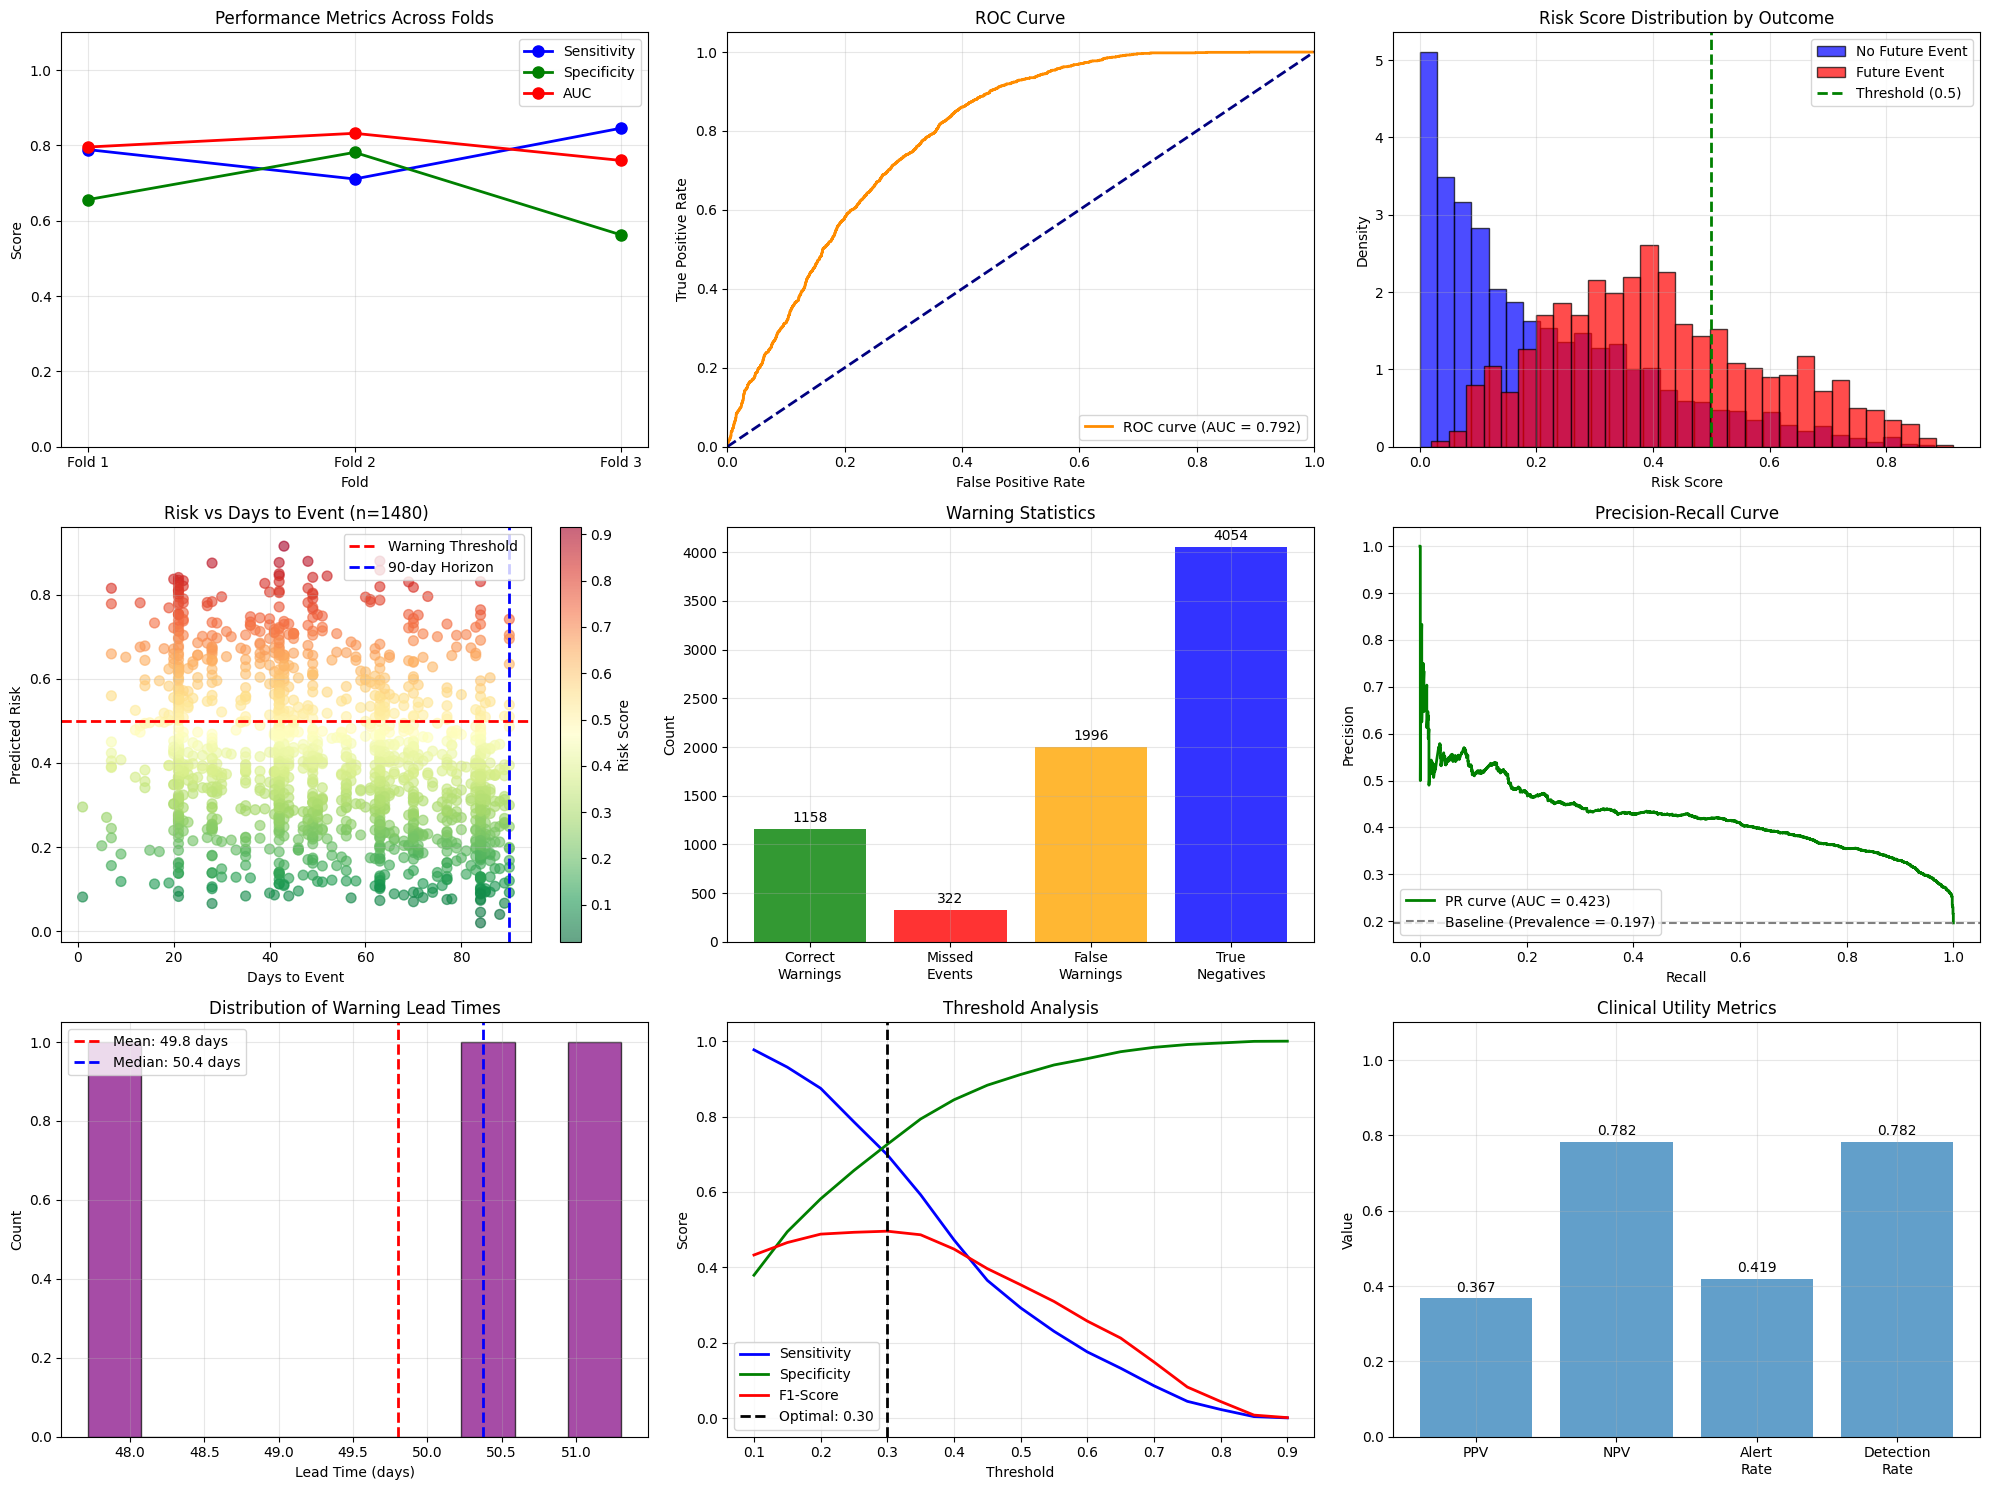


CLINICAL EARLY WARNING SYSTEM COMPLETED!

CLINICAL IMPLICATIONS:
--------------------------------------------------
1. System predicts death within next 90 days
2. Risk scores range from 0 (low risk) to 1 (high risk)
3. Threshold of 0.5 typically used for warnings
4. Lead time = days between warning and actual event

Based on your data:
- 1098 patients died during follow-up
- System trained on 7530 patient sequences
- Prediction horizon: 90 days
- Used autoencoder imputation: True


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

class AutoencoderImputer:
    def __init__(self, encoding_dim=32, epochs=50, batch_size=32, random_state=42):
        self.encoding_dim = encoding_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.autoencoder = None
        self.is_fitted = False

    def build_autoencoder(self, input_dim):
        """Build a deep autoencoder for imputation"""
        input_layer = layers.Input(shape=(input_dim,))

        # Encoder
        encoded = layers.Dense(128, activation='relu')(input_layer)
        encoded = layers.Dropout(0.2)(encoded)
        encoded = layers.Dense(64, activation='relu')(encoded)
        encoded = layers.Dropout(0.2)(encoded)
        encoded = layers.Dense(self.encoding_dim, activation='relu')(encoded)

        # Decoder
        decoded = layers.Dense(64, activation='relu')(encoded)
        decoded = layers.Dropout(0.2)(decoded)
        decoded = layers.Dense(128, activation='relu')(decoded)
        decoded = layers.Dropout(0.2)(decoded)
        decoded = layers.Dense(input_dim, activation='linear')(decoded)

        # Autoencoder model
        autoencoder = models.Model(input_layer, decoded)

        # Encoder model (for feature extraction)
        encoder = models.Model(input_layer, encoded)

        autoencoder.compile(optimizer=Adam(learning_rate=0.001),
                           loss='mse',
                           metrics=['mae'])

        return autoencoder, encoder

    def fit_imputer(self, X_train):
        """Train autoencoder on complete data"""
        # Create mask for complete cases
        complete_mask = ~np.any(np.isnan(X_train), axis=1)
        X_complete = X_train[complete_mask]

        if len(X_complete) < 10:
            print(f"Warning: Only {len(X_complete)} complete cases for autoencoder training")
            return self

        # Scale the data
        X_scaled = self.scaler.fit_transform(X_complete)

        # Build and train autoencoder
        self.autoencoder, self.encoder = self.build_autoencoder(X_scaled.shape[1])

        early_stop = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            min_delta=0.001
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )

        # Train-validation split
        X_train_split, X_val_split = train_test_split(
            X_scaled, test_size=0.2, random_state=self.random_state
        )

        self.autoencoder.fit(
            X_train_split, X_train_split,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_data=(X_val_split, X_val_split),
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )

        self.is_fitted = True
        print(f"Autoencoder trained on {len(X_complete)} complete cases")

        return self

    def impute_missing_values(self, X, max_iter=20, tol=1e-4):
        """Impute missing values using trained autoencoder with iterative refinement"""
        if not self.is_fitted:
            print("Autoencoder not fitted. Fitting now...")
            self.fit_imputer(X)
            if not self.is_fitted:
                return X  # Return original if still not fitted

        X_imputed = X.copy()

        # Check for missing values
        if not np.any(np.isnan(X_imputed)):
            return X_imputed

        # Initial imputation with median
        for i in range(X_imputed.shape[1]):
            col_data = X_imputed[:, i]
            if np.any(np.isnan(col_data)):
                median_val = np.nanmedian(col_data)
                if np.isnan(median_val):
                    median_val = 0
                col_data[np.isnan(col_data)] = median_val
                X_imputed[:, i] = col_data

        # Iterative refinement
        for iteration in range(max_iter):
            X_old = X_imputed.copy()

            # Scale
            X_scaled = self.scaler.transform(X_imputed)

            # Get reconstructions
            X_reconstructed = self.autoencoder.predict(X_scaled, verbose=0)
            X_reconstructed = self.scaler.inverse_transform(X_reconstructed)

            # Only update missing values
            missing_mask = np.isnan(X)
            X_imputed[missing_mask] = X_reconstructed[missing_mask]

            # Check convergence
            if iteration > 0:
                change = np.linalg.norm(X_imputed - X_old) / np.linalg.norm(X_old)
                if change < tol:
                    print(f"Autoencoder imputation converged after {iteration+1} iterations")
                    break

        return X_imputed


class RobustTimeAwareDataProcessor:
    def __init__(self, use_autoencoder=True):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.use_autoencoder = use_autoencoder
        self.autoencoder_imputer = AutoencoderImputer() if use_autoencoder else None
        self.feature_names = None

    def clean_data(self, df):
        """Clean data by handling infinity, large values, and missing data"""
        df_clean = df.copy()

        # Replace infinity with NaN
        df_clean = df_clean.replace([np.inf, -np.inf], np.nan)

        # Handle extremely large values by capping at 99th percentile
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df_clean[col].notna().any():
                # Cap at 99th percentile
                p99 = df_clean[col].quantile(0.99)
                if not np.isnan(p99):
                    df_clean[col] = df_clean[col].clip(upper=p99 * 10)  # Allow some margin

        return df_clean

    def process_patient_data(self, df):
        """Process data with proper temporal structure"""
        # Clean data first
        df_clean = self.clean_data(df)

        # Handle missing survival data
        missing_before = len(df_clean)
        df_clean = df_clean.dropna(subset=['VISDAY', 'os_event'])
        missing_after = len(df_clean)
        print(f"Removed {missing_before - missing_after} rows with missing survival data")

        # Create patient IDs if not present
        if 'patient_id' not in df_clean.columns:
            # Try to find a patient identifier column
            possible_id_cols = ['RPT', 'SUBJID', 'PATIENT', 'patient', 'id', 'ID']
            found_id = False
            for col in possible_id_cols:
                if col in df_clean.columns:
                    df_clean['patient_id'] = df_clean[col]
                    print(f"Using '{col}' as patient identifier")
                    found_id = True
                    break

            if not found_id:
                # Create synthetic patient IDs (assuming ~5 visits per patient)
                df_clean['patient_id'] = np.arange(len(df_clean)) // 5
                print("Created synthetic patient IDs (5 visits per patient)")

        # Sort by patient and visit day
        df_sorted = df_clean.sort_values(['patient_id', 'VISDAY']).reset_index(drop=True)

        # Calculate time to event for each visit
        print("Calculating time-to-event for each visit...")
        df_sorted['time_to_event'] = np.nan
        df_sorted['is_future_event'] = 0

        unique_patients = df_sorted['patient_id'].unique()
        print(f"Processing {len(unique_patients)} patients...")

        for i, pid in enumerate(unique_patients):
            if i % 200 == 0:
                print(f"  Processed {i}/{len(unique_patients)} patients...")

            patient_data = df_sorted[df_sorted['patient_id'] == pid]

            # Check if patient died (os_event = 1)
            patient_events = patient_data['os_event'].values
            if np.any(patient_events == 1):
                # Patient died - find death day
                death_idx = np.where(patient_events == 1)[0]
                if len(death_idx) > 0:
                    death_day = patient_data.iloc[death_idx[0]]['VISDAY']

                    # For all visits before death, calculate days to death
                    for idx, row in patient_data.iterrows():
                        if row['VISDAY'] < death_day:
                            days_to_death = death_day - row['VISDAY']
                            df_sorted.at[idx, 'time_to_event'] = days_to_death
                            df_sorted.at[idx, 'is_future_event'] = 1
                        elif row['VISDAY'] == death_day:
                            # Death visit itself
                            df_sorted.at[idx, 'time_to_event'] = 0
                            df_sorted.at[idx, 'is_future_event'] = 0  # Not a future event
            else:
                # Patient survived - use maximum follow-up time
                last_visit_day = patient_data['VISDAY'].max()

                for idx, row in patient_data.iterrows():
                    days_from_last = last_visit_day - row['VISDAY']
                    df_sorted.at[idx, 'time_to_event'] = days_from_last
                    df_sorted.at[idx, 'is_future_event'] = 0

        # Handle any remaining NaN values in time_to_event
        nan_count = df_sorted['time_to_event'].isna().sum()
        if nan_count > 0:
            print(f"Warning: {nan_count} NaN values in time_to_event, filling with median")
            median_ttd = df_sorted['time_to_event'].median()
            df_sorted['time_to_event'] = df_sorted['time_to_event'].fillna(median_ttd)

        print(f"Processed {len(df_sorted)} visits from {len(unique_patients)} patients")

        # Count patients with events
        event_patients = df_sorted[df_sorted['os_event'] == 1]['patient_id'].unique()
        no_event_patients = df_sorted[df_sorted['os_event'] == 0]['patient_id'].unique()

        print(f"Patients with event: {len(event_patients)}")
        print(f"Patients without event: {len(no_event_patients)}")
        print(f"Visits with future event: {df_sorted['is_future_event'].sum()}")

        return df_sorted

    def prepare_features_with_autoencoder(self, df_train, df_test, feature_names):
        """Prepare features with autoencoder imputation for train and test separately"""
        print(f"Using autoencoder imputation: {self.use_autoencoder}")

        # Select features that exist in dataframe
        available_features = [f for f in feature_names if f in df_train.columns]
        print(f"Using {len(available_features)} available features")

        # Prepare train and test data
        X_train_raw = df_train[available_features].copy()
        X_test_raw = df_test[available_features].copy()

        # Replace any infinity values
        X_train_raw = X_train_raw.replace([np.inf, -np.inf], np.nan)
        X_test_raw = X_test_raw.replace([np.inf, -np.inf], np.nan)

        # Handle categorical variables
        categorical_cols = X_train_raw.select_dtypes(exclude=[np.number]).columns
        numeric_cols = X_train_raw.select_dtypes(include=[np.number]).columns

        print(f"Categorical columns: {len(categorical_cols)}")
        print(f"Numeric columns: {len(numeric_cols)}")

        # Encode categorical variables
        encoded_train = []
        encoded_test = []

        for col in categorical_cols:
            try:
                if col not in self.label_encoders:
                    self.label_encoders[col] = LabelEncoder()
                    # Combine train and test for fitting to handle all categories
                    combined = pd.concat([X_train_raw[col], X_test_raw[col]], ignore_index=True)
                    combined = combined.astype(str).fillna('missing')
                    self.label_encoders[col].fit(combined)

                # Transform train and test
                train_encoded = self.label_encoders[col].transform(
                    X_train_raw[col].astype(str).fillna('missing')
                )
                test_encoded = self.label_encoders[col].transform(
                    X_test_raw[col].astype(str).fillna('missing')
                )

                encoded_train.append(train_encoded.reshape(-1, 1))
                encoded_test.append(test_encoded.reshape(-1, 1))

            except Exception as e:
                print(f"Warning: Could not encode column {col}: {e}")
                # Drop problematic column
                continue

        # Combine categorical and numeric data
        X_train_combined = []
        X_test_combined = []

        if len(categorical_cols) > 0 and encoded_train:
            X_train_cat = np.hstack(encoded_train)
            X_test_cat = np.hstack(encoded_test)
            X_train_combined.append(X_train_cat)
            X_test_combined.append(X_test_cat)

        if len(numeric_cols) > 0:
            X_train_num = X_train_raw[numeric_cols].values
            X_test_num = X_test_raw[numeric_cols].values
            X_train_combined.append(X_train_num)
            X_test_combined.append(X_test_num)

        # Combine all features
        if X_train_combined:
            X_train = np.hstack(X_train_combined)
            X_test = np.hstack(X_test_combined)
        else:
            print("Warning: No features available after preprocessing")
            return None, None, available_features

        print(f"Train data shape before imputation: {X_train.shape}")
        print(f"Test data shape before imputation: {X_test.shape}")
        print(f"Missing values in train: {np.isnan(X_train).sum()} ({np.isnan(X_train).mean()*100:.1f}%)")
        print(f"Missing values in test: {np.isnan(X_test).sum()} ({np.isnan(X_test).mean()*100:.1f}%)")

        if self.use_autoencoder and self.autoencoder_imputer:
            # Fit autoencoder on training data
            print("\nFitting autoencoder on training data...")
            self.autoencoder_imputer.fit_imputer(X_train)

            # Impute missing values separately for train and test
            print("Imputing missing values in training set...")
            X_train_imputed = self.autoencoder_imputer.impute_missing_values(X_train)

            print("Imputing missing values in test set...")
            X_test_imputed = self.autoencoder_imputer.impute_missing_values(X_test)

            # Scale the imputed data
            X_train_scaled = self.scaler.fit_transform(X_train_imputed)
            X_test_scaled = self.scaler.transform(X_test_imputed)

            print(f"Missing values after autoencoder imputation (train): {np.isnan(X_train_scaled).sum()}")
            print(f"Missing values after autoencoder imputation (test): {np.isnan(X_test_scaled).sum()}")

            return X_train_scaled, X_test_scaled, available_features
        else:
            # Fallback: Simple imputation
            print("Using simple imputation (median/mode)...")

            # Impute missing values with median for numeric, mode for categorical
            for i in range(X_train.shape[1]):
                # Train imputation
                train_col = X_train[:, i]
                if np.any(np.isnan(train_col)):
                    if i < len(categorical_cols):
                        # Categorical - use mode
                        mode_val = np.nanmode(train_col)
                        if np.isnan(mode_val):
                            mode_val = 0
                        X_train[:, i] = np.nan_to_num(train_col, nan=mode_val)
                    else:
                        # Numeric - use median
                        median_val = np.nanmedian(train_col)
                        if np.isnan(median_val):
                            median_val = 0
                        X_train[:, i] = np.nan_to_num(train_col, nan=median_val)

                # Test imputation (using statistics from train)
                test_col = X_test[:, i]
                if np.any(np.isnan(test_col)):
                    if i < len(categorical_cols):
                        # Categorical - use mode from train
                        mode_val = np.nanmode(X_train[:, i])
                        if np.isnan(mode_val):
                            mode_val = 0
                        X_test[:, i] = np.nan_to_num(test_col, nan=mode_val)
                    else:
                        # Numeric - use median from train
                        median_val = np.nanmedian(X_train[:, i])
                        if np.isnan(median_val):
                            median_val = 0
                        X_test[:, i] = np.nan_to_num(test_col, nan=median_val)

            # Scale the data
            X_train_scaled = self.scaler.fit_transform(X_train)
            X_test_scaled = self.scaler.transform(X_test)

            return X_train_scaled, X_test_scaled, available_features

    def prepare_features(self, df, feature_names):
        """Legacy method for backward compatibility - prepares features without train/test split"""
        print("Warning: Using legacy prepare_features method without train/test split")

        # Select features that exist in dataframe
        available_features = [f for f in feature_names if f in df.columns]
        print(f"Using {len(available_features)} available features")

        # Handle missing values
        df_filled = df[available_features].copy()

        # Replace any remaining infinity values
        df_filled = df_filled.replace([np.inf, -np.inf], np.nan)

        # Fill numeric missing values with median
        numeric_cols = df_filled.select_dtypes(include=[np.number]).columns
        print(f"Processing {len(numeric_cols)} numeric columns...")

        for col in numeric_cols:
            if df_filled[col].isnull().any():
                median_val = df_filled[col].median()
                if pd.isna(median_val):
                    median_val = 0  # Fallback
                df_filled[col] = df_filled[col].fillna(median_val)

        # Fill categorical missing values with mode
        categorical_cols = df_filled.select_dtypes(exclude=[np.number]).columns
        print(f"Processing {len(categorical_cols)} categorical columns...")

        for col in categorical_cols:
            if df_filled[col].isnull().any():
                mode_val = df_filled[col].mode()
                if len(mode_val) > 0:
                    df_filled[col] = df_filled[col].fillna(mode_val[0])
                else:
                    df_filled[col] = df_filled[col].fillna('missing')

        # Encode categorical variables
        print("Encoding categorical variables...")
        for col in categorical_cols:
            try:
                if col not in self.label_encoders:
                    self.label_encoders[col] = LabelEncoder()
                    # Handle any non-string values
                    col_data = df_filled[col].astype(str)
                    self.label_encoders[col].fit(col_data)

                df_filled[col] = self.label_encoders[col].transform(df_filled[col].astype(str))
            except Exception as e:
                print(f"Warning: Could not encode column {col}: {e}")
                # Drop problematic column
                df_filled = df_filled.drop(columns=[col])
                available_features.remove(col)

        # Scale numeric features
        if len(numeric_cols) > 0:
            print("Scaling numeric features...")
            # Check for any remaining issues
            numeric_data = df_filled[numeric_cols].values
            if np.any(np.isnan(numeric_data)) or np.any(np.isinf(numeric_data)):
                print("Warning: NaN or Inf found in numeric data after cleaning")
                # Replace with zeros as last resort
                numeric_data = np.nan_to_num(numeric_data, nan=0.0, posinf=1e6, neginf=-1e6)
                df_filled[numeric_cols] = numeric_data

            try:
                df_filled[numeric_cols] = self.scaler.fit_transform(df_filled[numeric_cols])
            except Exception as e:
                print(f"Warning: Could not scale features: {e}")
                # Use min-max scaling as fallback
                for col in numeric_cols:
                    col_min = df_filled[col].min()
                    col_max = df_filled[col].max()
                    if col_max > col_min:
                        df_filled[col] = (df_filled[col] - col_min) / (col_max - col_min)
                    else:
                        df_filled[col] = 0

        print(f"Final feature matrix shape: {df_filled.shape}")
        return df_filled.values, available_features

    def create_temporal_sequences(self, df, feature_cols, max_sequence_length=5, prediction_horizon=90):
        """Create sequences with proper temporal structure"""
        print("Creating temporal sequences...")
        sequences = []
        labels = []
        time_intervals = []
        patient_ids = []
        days_to_event_list = []

        unique_patients = df['patient_id'].unique()

        for pid in unique_patients:
            patient_data = df[df['patient_id'] == pid].sort_values('VISDAY')

            if len(patient_data) < 2:
                continue  # Need at least 2 visits

            # Get features and temporal data
            patient_features = patient_data[feature_cols].values
            patient_visdays = patient_data['VISDAY'].values
            patient_time_to_event = patient_data['time_to_event'].values
            patient_has_event = patient_data['is_future_event'].values

            # Create sequences
            for i in range(1, len(patient_data)):  # Start from 1 to have at least one previous visit
                # Determine sequence length (up to max_sequence_length)
                seq_len = min(i, max_sequence_length)
                start_idx = i - seq_len

                # Get sequence data
                seq_features = patient_features[start_idx:i+1]  # Including current visit
                seq_visdays = patient_visdays[start_idx:i+1]

                # Calculate time intervals between visits (in days)
                if len(seq_visdays) > 1:
                    time_diffs = np.diff(seq_visdays)
                    # Add a default 30-day interval for the first gap
                    time_diffs = np.concatenate([[30], time_diffs])
                else:
                    time_diffs = np.array([30])

                # Normalize time intervals (divide by 30 to get approximate months)
                time_diffs_normalized = time_diffs / 30.0

                # Create label: will event occur within prediction horizon?
                current_time_to_event = patient_time_to_event[i]
                if current_time_to_event <= prediction_horizon and current_time_to_event > 0:
                    label = 1  # Event will occur within horizon
                else:
                    label = 0  # No event within horizon

                # Pad sequence if needed
                if seq_len < max_sequence_length:
                    pad_len = max_sequence_length - seq_len
                    seq_features = np.pad(seq_features, ((pad_len, 0), (0, 0)), mode='constant')
                    time_diffs_normalized = np.pad(time_diffs_normalized, (pad_len, 0),
                                                  mode='constant', constant_values=1.0)  # 1 month for padding

                sequences.append(seq_features)
                labels.append(label)
                time_intervals.append(time_diffs_normalized)
                patient_ids.append(pid)
                days_to_event_list.append(current_time_to_event)

        sequences = np.array(sequences)
        labels = np.array(labels)
        time_intervals = np.array(time_intervals)
        patient_ids = np.array(patient_ids)

        print(f"\nCreated {len(sequences)} sequences")
        print(f"Positive sequences (event within {prediction_horizon} days): {np.sum(labels == 1)} ({np.mean(labels == 1)*100:.1f}%)")
        print(f"Negative sequences: {np.sum(labels == 0)}")

        # Analyze positive sequences
        if np.sum(labels == 1) > 0:
            positive_days = np.array(days_to_event_list)[labels == 1]
            print(f"Days to event for positive sequences:")
            print(f"  Mean: {np.mean(positive_days):.1f} days")
            print(f"  Median: {np.median(positive_days):.1f} days")
            print(f"  Range: {np.min(positive_days):.1f} to {np.max(positive_days):.1f} days")

        return sequences, labels, time_intervals, patient_ids, days_to_event_list


class TimeAwareEarlyWarningModel:
    def __init__(self, input_dim, sequence_length=5, lstm_units=64):
        self.input_dim = input_dim
        self.sequence_length = sequence_length
        self.lstm_units = lstm_units
        self.model = None
        self.history = None

    def build_model_with_time_awareness(self):
        """Build model that incorporates time intervals between visits"""
        # Two input layers: features and time intervals
        feature_input = layers.Input(shape=(self.sequence_length, self.input_dim), name='features')
        time_input = layers.Input(shape=(self.sequence_length, 1), name='time_intervals')

        # Process time intervals
        time_processed = layers.Dense(8, activation='relu')(time_input)
        time_processed = layers.Dense(16, activation='relu')(time_processed)

        # Concatenate features with time information
        combined = layers.Concatenate(axis=-1)([feature_input, time_processed])

        # LSTM layers
        lstm_out = layers.Bidirectional(layers.LSTM(self.lstm_units, return_sequences=True))(combined)
        lstm_out = layers.Dropout(0.3)(lstm_out)

        # Simple attention mechanism
        attention_scores = layers.TimeDistributed(layers.Dense(1, activation='tanh'))(lstm_out)
        attention_weights = layers.Softmax(axis=1)(attention_scores)
        context_vector = layers.Multiply()([lstm_out, attention_weights])

        # Global average pooling instead of just last time step
        pooled = layers.GlobalAveragePooling1D()(context_vector)

        # Dense layers
        dense1 = layers.Dense(64, activation='relu')(pooled)
        dense1 = layers.BatchNormalization()(dense1)
        dense1 = layers.Dropout(0.3)(dense1)

        dense2 = layers.Dense(32, activation='relu')(dense1)
        dense2 = layers.BatchNormalization()(dense2)
        dense2 = layers.Dropout(0.2)(dense2)

        # Output: risk of event within prediction horizon
        risk_score = layers.Dense(1, activation='sigmoid', name='risk_score')(dense2)

        # Create model
        self.model = models.Model(inputs=[feature_input, time_input], outputs=risk_score)

        return self.model

    def compile_model(self, learning_rate=0.001):
        """Compile the model"""
        self.model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall')]
        )

        return self.model

    def train(self, X_features, X_time, y_train, val_data=None, epochs=100, batch_size=32, class_weight=None):
        """Train the model"""
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss' if val_data else 'loss',
            patience=15,
            restore_best_weights=True,
            min_delta=0.001,
            verbose=0
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss' if val_data else 'loss',
            factor=0.5,
            patience=8,
            min_lr=1e-6,
            verbose=0
        )

        callbacks_list = [early_stopping, reduce_lr]

        if val_data:
            X_val_features, X_val_time, y_val = val_data
            validation_data = ([X_val_features, X_val_time], y_val)
        else:
            validation_data = None

        self.history = self.model.fit(
            [X_features, X_time], y_train,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks_list,
            verbose=0,
            class_weight=class_weight
        )

        return self.history

    def predict(self, X_features, X_time):
        """Make predictions"""
        return self.model.predict([X_features, X_time], verbose=0).flatten()


class ClinicalEarlyWarningPipeline:
    def __init__(self, prediction_horizon_days=90, n_splits=3, random_state=42, use_autoencoder=True):
        self.prediction_horizon = prediction_horizon_days
        self.n_splits = n_splits
        self.random_state = random_state
        self.use_autoencoder = use_autoencoder
        self.data_processor = RobustTimeAwareDataProcessor(use_autoencoder=use_autoencoder)
        self.results = {}

    def select_clinical_features(self, df):
        """Select relevant clinical features for early warning"""
        # Common clinical features for mortality prediction
        base_features = [
            'AGE', 'SEX', 'RACE',  # Demographics
            'BMI', 'WEIGHT', 'HEIGHT',  # Anthropometrics
            'ECOG', 'KPS',  # Performance status
        ]

        # Lab values (if available)
        lab_features = [
            'ALB', 'ALP', 'ALT', 'AST', 'BILI', 'CALCIUM', 'CREAT', 'HGB',
            'LYMPH', 'NEUT', 'PLAT', 'WBC', 'SODIUM', 'POTASSIUM', 'GLUCOSE',
            'BUN', 'CRP', 'LDH'
        ]

        # Treatment and AE features from your data
        treatment_features = [
            'cycle_number', 'total_cycles', 'anytarget', 'anynontarget',
            'total_ae_events', 'serious_ae_count', 'grade3_plus_count',
            'any_grade3_plus', 'treatment_related_count', 'any_treatment_related',
            'grade1_count', 'grade2_count', 'grade3_count', 'grade4_count',
            'drug_interrupted', 'drug_reduced', 'drug_withdrawn', 'drug_not_changed',
            'other_drug_interrupted', 'other_drug_reduced', 'other_drug_withdrawn',
            'concomitant_treatment_given', 'cum_any_grade3_plus',
            'cum_any_treatment_related', 'cum_drug_withdrawn',
            'cum_other_drug_withdrawn', 'cum_concomitant_treatment',
            'ongoing_ae_count', 'mean_ae_duration', 'max_ae_duration'
        ]

        # Combine and check availability
        all_possible = base_features + lab_features + treatment_features
        available_features = [f for f in all_possible if f in df.columns]

        print(f"Found {len(available_features)} available features out of {len(all_possible)} possible")

        # If we have very few features, use some defaults
        if len(available_features) < 10:
            print("Warning: Few features available, using basic set")
            # Try to find any numeric columns
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            # Exclude ID and date columns
            exclude_cols = ['VISDAY', 'DSDAY', 'patient_id', 'id', 'index', 'time_to_event', 'is_future_event']
            numeric_cols = [c for c in numeric_cols if c not in exclude_cols]
            available_features = numeric_cols[:20]  # Take first 20 numeric columns

        return available_features

    def run_pipeline(self, pcdata):
        """Run the complete early warning pipeline"""
        print("="*70)
        print("CLINICAL EARLY WARNING SYSTEM FOR MORTALITY PREDICTION")
        print("="*70)
        print(f"Prediction horizon: {self.prediction_horizon} days")
        print(f"Using autoencoder imputation: {self.use_autoencoder}")
        print(f"Looking for death events within next {self.prediction_horizon} days")

        # Step 1: Process data with temporal structure
        print("\n1. Processing temporal data...")
        print("-"*40)

        df_processed = self.data_processor.process_patient_data(pcdata)

        # Step 2: Prepare features (we'll do this separately for each fold)
        print("\n2. Selecting clinical features...")
        print("-"*40)

        feature_names = self.select_clinical_features(df_processed)
        print(f"Selected {len(feature_names)} features for modeling")

        # Add processed features back to dataframe (we'll impute in each fold)
        feature_cols = [f'feat_{i}' for i in range(len(feature_names))]

        # Step 3: Create temporal sequences (with raw features)
        print("\n3. Creating temporal sequences...")
        print("-"*40)

        # We'll use the raw data and impute in each fold
        df_for_sequences = df_processed.copy()
        # Store original values for imputation
        for i, feat in enumerate(feature_names):
            if feat in df_for_sequences.columns:
                df_for_sequences[f'feat_{i}'] = df_for_sequences[feat]

        sequences, labels, time_intervals, patient_ids, days_to_event = self.data_processor.create_temporal_sequences(
            df_for_sequences, feature_cols, max_sequence_length=5,
            prediction_horizon=self.prediction_horizon
        )

        if len(sequences) == 0:
            print("Error: No sequences created!")
            return None

        print(f"Sequence shape: {sequences.shape}")
        print(f"Time intervals shape: {time_intervals.shape}")

        # Step 4: Analyze data balance
        print("\n4. Analyzing data balance...")
        print("-"*40)

        positive_rate = np.mean(labels == 1)
        print(f"Positive rate (event within {self.prediction_horizon} days): {positive_rate:.3f}")

        if positive_rate < 0.01:
            print("Warning: Very low positive rate, model may struggle to learn")
            print("Consider increasing prediction horizon or using different labeling")

        # Step 5: Cross-validation with fold-specific imputation
        print("\n5. Running cross-validation with fold-specific imputation...")
        print("-"*40)

        # Create patient-level splits
        unique_patients = np.unique(patient_ids)
        print(f"Unique patients in sequences: {len(unique_patients)}")

        # Get patient labels (max label across their sequences)
        patient_labels = []

        for pid in unique_patients:
            patient_mask = patient_ids == pid
            patient_label = np.max(labels[patient_mask])  # Patient has event if any sequence does
            patient_labels.append(patient_label)

        patient_labels = np.array(patient_labels)

        print(f"Patients with future event in sequences: {np.sum(patient_labels == 1)}")
        print(f"Patients without future event in sequences: {np.sum(patient_labels == 0)}")

        if np.sum(patient_labels == 1) < 2:
            print(f"Error: Only {np.sum(patient_labels == 1)} patients with events")
            print("Cannot perform cross-validation. Using simple train/test split instead.")
            return self.run_simple_split(sequences, labels, time_intervals, patient_ids, days_to_event, df_processed, feature_names)

        n_folds = min(self.n_splits, np.sum(patient_labels == 1))
        if n_folds < self.n_splits:
            print(f"Reducing CV folds to {n_folds} (only {np.sum(patient_labels == 1)} patients with events)")

        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=self.random_state)

        cv_results = {
            'fold': [],
            'sensitivity': [], 'specificity': [], 'auc': [],
            'precision': [], 'recall': [], 'f1': [],
            'lead_times': [], 'warning_stats': [],
            'risk_scores': [], 'true_labels': [],
            'days_to_event': []
        }

        fold = 1
        for train_patient_idx, test_patient_idx in skf.split(unique_patients, patient_labels):
            print(f"\n{'='*60}")
            print(f"FOLD {fold}/{n_folds}")
            print(f"{'='*60}")

            # Get patient IDs for train/test
            train_patient_ids = unique_patients[train_patient_idx]
            test_patient_ids = unique_patients[test_patient_idx]

            print(f"Training patients: {len(train_patient_ids)}")
            print(f"Test patients: {len(test_patient_ids)}")

            # Create masks
            train_mask = np.isin(patient_ids, train_patient_ids)
            test_mask = np.isin(patient_ids, test_patient_ids)

            # Split data (raw sequences)
            X_train_seq_raw = sequences[train_mask]
            X_test_seq_raw = sequences[test_mask]

            X_train_time = time_intervals[train_mask]
            X_test_time = time_intervals[test_mask]

            y_train = labels[train_mask]
            y_test = labels[test_mask]

            test_days_to_event = np.array(days_to_event)[test_mask]

            train_pids = patient_ids[train_mask]

            # Step: IMPUTE MISSING VALUES SEPARATELY FOR TRAIN AND TEST
            print("\n6. Imputing missing values with autoencoder...")
            print("-"*40)

            # Reshape sequences for imputation (flatten temporal dimension)
            n_train_samples, seq_len, n_features = X_train_seq_raw.shape
            n_test_samples = X_test_seq_raw.shape[0]

            X_train_flat = X_train_seq_raw.reshape(n_train_samples * seq_len, n_features)
            X_test_flat = X_test_seq_raw.reshape(n_test_samples * seq_len, n_features)

            # Create temporary dataframes for imputation
            df_train_impute = pd.DataFrame(X_train_flat, columns=feature_cols)
            df_test_impute = pd.DataFrame(X_test_flat, columns=feature_cols)

            # Add patient_id for grouping (but we won't use it for imputation)
            train_patient_ids_repeated = np.repeat(train_pids, seq_len)
            test_patient_ids_repeated = np.repeat(patient_ids[test_mask], seq_len)

            # Impute missing values separately for train and test
            X_train_imputed_flat, X_test_imputed_flat, _ = self.data_processor.prepare_features_with_autoencoder(
                df_train_impute, df_test_impute, feature_cols
            )

            # Reshape back to sequences
            X_train_seq_imputed = X_train_imputed_flat.reshape(n_train_samples, seq_len, n_features)
            X_test_seq_imputed = X_test_imputed_flat.reshape(n_test_samples, seq_len, n_features)

            print(f"Train sequences after imputation: {X_train_seq_imputed.shape}")
            print(f"Test sequences after imputation: {X_test_seq_imputed.shape}")

            # Split training for validation
            unique_train_pids = np.unique(train_pids)
            val_patient_count = max(1, int(0.2 * len(unique_train_pids)))
            val_patient_ids = np.random.choice(unique_train_pids, val_patient_count, replace=False)
            val_mask = np.isin(train_pids, val_patient_ids)

            X_val_seq = X_train_seq_imputed[val_mask]
            X_val_time = X_train_time[val_mask]
            y_val = y_train[val_mask]

            X_train_seq_final = X_train_seq_imputed[~val_mask]
            X_train_time_final = X_train_time[~val_mask]
            y_train_final = y_train[~val_mask]

            print(f"Training sequences: {X_train_seq_final.shape[0]} (pos: {np.mean(y_train_final):.3f})")
            print(f"Validation sequences: {X_val_seq.shape[0]} (pos: {np.mean(y_val):.3f})")
            print(f"Test sequences: {X_test_seq_imputed.shape[0]} (pos: {np.mean(y_test):.3f})")

            # Handle class imbalance
            if np.sum(y_train_final) > 0:
                pos_weight = len(y_train_final) / (2 * np.sum(y_train_final))
                class_weight = {0: 1.0, 1: min(10.0, pos_weight)}  # Cap at 10x
            else:
                class_weight = {0: 1.0, 1: 1.0}

            # Step 7: Train model
            print("\n7. Training time-aware early warning model...")

            model = TimeAwareEarlyWarningModel(
                input_dim=X_train_seq_final.shape[2],
                sequence_length=X_train_seq_final.shape[1],
                lstm_units=32  # Reduced for stability
            )

            model.build_model_with_time_awareness()
            model.compile_model(learning_rate=0.001)

            try:
                history = model.train(
                    X_train_seq_final, X_train_time_final, y_train_final,
                    val_data=(X_val_seq, X_val_time, y_val),
                    epochs=50,  # Reduced for speed
                    batch_size=32,
                    class_weight=class_weight
                )

                # Check training history
                if history and 'loss' in history.history:
                    final_train_loss = history.history['loss'][-1]
                    final_val_loss = history.history.get('val_loss', [final_train_loss])[-1]
                    print(f"Final training loss: {final_train_loss:.4f}, validation loss: {final_val_loss:.4f}")
                else:
                    print("Warning: Training history not available")
                    final_train_loss = 0.5
                    final_val_loss = 0.5

            except Exception as e:
                print(f"Warning: Training failed: {e}")
                print("Skipping this fold...")
                fold += 1
                continue

            # Step 8: Evaluate
            print("\n8. Evaluating early warnings...")

            # Get predictions
            try:
                train_pred = model.predict(X_train_seq_final, X_train_time_final)
                test_pred = model.predict(X_test_seq_imputed, X_test_time)
            except Exception as e:
                print(f"Warning: Prediction failed: {e}")
                fold += 1
                continue

            # Find optimal threshold (maximizing F1 score)
            thresholds = np.linspace(0.1, 0.9, 17)
            best_f1 = 0
            best_threshold = 0.5

            for thresh in thresholds:
                pred_binary = (test_pred > thresh).astype(int)
                if np.sum(pred_binary) > 0 and np.sum(y_test) > 0:
                    try:
                        f1 = f1_score(y_test, pred_binary, zero_division=0)
                        if f1 > best_f1:
                            best_f1 = f1
                            best_threshold = thresh
                    except:
                        continue

            print(f"Optimal threshold: {best_threshold:.3f} (F1: {best_f1:.3f})")

            # Calculate metrics
            test_pred_binary = (test_pred > best_threshold).astype(int)

            # Handle cases with no predictions
            if np.sum(test_pred_binary) == 0:
                print("Warning: No positive predictions at this threshold")
                accuracy = accuracy_score(y_test, test_pred_binary)
                auc_score = 0.5
                precision = 0
                recall = 0
                f1 = 0
                tn = np.sum(y_test == 0)
                fp = 0
                fn = np.sum(y_test == 1)
                tp = 0
            elif np.sum(y_test) == 0:
                print("Warning: No positive cases in test set")
                accuracy = accuracy_score(y_test, test_pred_binary)
                auc_score = 0.5
                precision = 0
                recall = 0
                f1 = 0
                tn = np.sum((y_test == 0) & (test_pred_binary == 0))
                fp = np.sum((y_test == 0) & (test_pred_binary == 1))
                fn = 0
                tp = 0
            else:
                accuracy = accuracy_score(y_test, test_pred_binary)
                try:
                    auc_score = roc_auc_score(y_test, test_pred)
                except:
                    auc_score = 0.5
                precision = precision_score(y_test, test_pred_binary, zero_division=0)
                recall = recall_score(y_test, test_pred_binary, zero_division=0)
                f1 = f1_score(y_test, test_pred_binary, zero_division=0)

                # Calculate confusion matrix
                try:
                    cm = confusion_matrix(y_test, test_pred_binary)
                    if cm.shape == (2, 2):
                        tn, fp, fn, tp = cm.ravel()
                    else:
                        # Handle case where only one class predicted
                        tn = np.sum((y_test == 0) & (test_pred_binary == 0))
                        fp = np.sum((y_test == 0) & (test_pred_binary == 1))
                        fn = np.sum((y_test == 1) & (test_pred_binary == 0))
                        tp = np.sum((y_test == 1) & (test_pred_binary == 1))
                except:
                    tn = np.sum((y_test == 0) & (test_pred_binary == 0))
                    fp = np.sum((y_test == 0) & (test_pred_binary == 1))
                    fn = np.sum((y_test == 1) & (test_pred_binary == 0))
                    tp = np.sum((y_test == 1) & (test_pred_binary == 1))

            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            print(f"\nFold {fold} Results:")
            print(f"  Accuracy: {accuracy:.4f}")
            print(f"  AUC: {auc_score:.4f}")
            print(f"  Sensitivity: {sensitivity:.4f}")
            print(f"  Specificity: {specificity:.4f}")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall: {recall:.4f}")
            print(f"  F1-Score: {f1:.4f}")
            print(f"  TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

            # Store results
            cv_results['fold'].append(fold)
            cv_results['sensitivity'].append(sensitivity)
            cv_results['specificity'].append(specificity)
            cv_results['auc'].append(auc_score)
            cv_results['precision'].append(precision)
            cv_results['recall'].append(recall)
            cv_results['f1'].append(f1)
            cv_results['risk_scores'].extend(test_pred.tolist())
            cv_results['true_labels'].extend(y_test.tolist())
            cv_results['days_to_event'].extend(test_days_to_event.tolist())

            # Calculate lead times for correctly warned patients
            if tp > 0:
                # For TP cases, get actual days to event
                tp_mask = (y_test == 1) & (test_pred_binary == 1)
                if np.any(tp_mask):
                    tp_days = test_days_to_event[tp_mask]
                    avg_lead_time = np.mean(tp_days)
                    cv_results['lead_times'].append(avg_lead_time)

                    warning_stats = {
                        'correct_warnings': int(tp),
                        'missed_warnings': int(fn),
                        'false_warnings': int(fp),
                        'true_negatives': int(tn),
                        'avg_lead_time': float(avg_lead_time)
                    }
                else:
                    warning_stats = {
                        'correct_warnings': int(tp),
                        'missed_warnings': int(fn),
                        'false_warnings': int(fp),
                        'true_negatives': int(tn),
                        'avg_lead_time': 0.0
                    }
                cv_results['warning_stats'].append(warning_stats)

            fold += 1

        self.results = cv_results

        if not cv_results['fold']:
            print("\nERROR: No folds completed successfully!")
            print("Trying simple train/test split instead...")
            return self.run_simple_split(sequences, labels, time_intervals, patient_ids, days_to_event, df_processed, feature_names)

        # Step 9: Analyze results
        print("\n" + "="*70)
        print("COMPREHENSIVE EARLY WARNING ANALYSIS")
        print("="*70)

        self.analyze_results(cv_results)
        self.visualize_results(cv_results)

        return cv_results

    def run_simple_split(self, sequences, labels, time_intervals, patient_ids, days_to_event, df_processed, feature_names):
        """Run a simple train/test split when cross-validation fails"""
        print("\nRunning simple train/test split...")

        # Simple split by sequences (not patients)
        n_samples = len(sequences)
        indices = np.arange(n_samples)
        np.random.shuffle(indices)

        split_idx = int(0.8 * n_samples)
        train_idx = indices[:split_idx]
        test_idx = indices[split_idx:]

        X_train_seq_raw = sequences[train_idx]
        X_test_seq_raw = sequences[test_idx]

        X_train_time = time_intervals[train_idx]
        X_test_time = time_intervals[test_idx]

        y_train = labels[train_idx]
        y_test = labels[test_idx]

        test_days_to_event = days_to_event[test_idx]

        # Step: Impute missing values separately
        print("\nImputing missing values with autoencoder...")

        # Reshape sequences for imputation
        n_train_samples, seq_len, n_features = X_train_seq_raw.shape
        n_test_samples = X_test_seq_raw.shape[0]

        X_train_flat = X_train_seq_raw.reshape(n_train_samples * seq_len, n_features)
        X_test_flat = X_test_seq_raw.reshape(n_test_samples * seq_len, n_features)

        # Create temporary dataframes
        feature_cols = [f'feat_{i}' for i in range(n_features)]
        df_train_impute = pd.DataFrame(X_train_flat, columns=feature_cols)
        df_test_impute = pd.DataFrame(X_test_flat, columns=feature_cols)

        # Impute missing values
        X_train_imputed_flat, X_test_imputed_flat, _ = self.data_processor.prepare_features_with_autoencoder(
            df_train_impute, df_test_impute, feature_cols
        )

        # Reshape back
        X_train_seq_imputed = X_train_imputed_flat.reshape(n_train_samples, seq_len, n_features)
        X_test_seq_imputed = X_test_imputed_flat.reshape(n_test_samples, seq_len, n_features)

        print(f"Train sequences after imputation: {X_train_seq_imputed.shape}")
        print(f"Test sequences after imputation: {X_test_seq_imputed.shape}")

        # Split training for validation
        val_size = int(0.2 * len(train_idx))
        X_val_seq = X_train_seq_imputed[:val_size]
        X_val_time = X_train_time[:val_size]
        y_val = y_train[:val_size]

        X_train_seq_final = X_train_seq_imputed[val_size:]
        X_train_time_final = X_train_time[val_size:]
        y_train_final = y_train[val_size:]

        print(f"Training sequences: {X_train_seq_final.shape[0]} (pos: {np.mean(y_train_final):.3f})")
        print(f"Validation sequences: {X_val_seq.shape[0]} (pos: {np.mean(y_val):.3f})")
        print(f"Test sequences: {X_test_seq_imputed.shape[0]} (pos: {np.mean(y_test):.3f})")

        # Handle class imbalance
        if np.sum(y_train_final) > 0:
            pos_weight = len(y_train_final) / (2 * np.sum(y_train_final))
            class_weight = {0: 1.0, 1: min(10.0, pos_weight)}  # Cap at 10x
        else:
            class_weight = {0: 1.0, 1: 1.0}

        # Train model
        print("\nTraining time-aware early warning model...")

        model = TimeAwareEarlyWarningModel(
            input_dim=X_train_seq_final.shape[2],
            sequence_length=X_train_seq_final.shape[1],
            lstm_units=32
        )

        model.build_model_with_time_awareness()
        model.compile_model(learning_rate=0.001)

        try:
            history = model.train(
                X_train_seq_final, X_train_time_final, y_train_final,
                val_data=(X_val_seq, X_val_time, y_val),
                epochs=50,
                batch_size=32,
                class_weight=class_weight
            )

            print("Training completed successfully")
        except Exception as e:
            print(f"Warning: Training failed: {e}")
            return None

        # Evaluate
        print("\nEvaluating early warnings...")

        # Get predictions
        try:
            test_pred = model.predict(X_test_seq_imputed, X_test_time)
        except Exception as e:
            print(f"Warning: Prediction failed: {e}")
            return None

        # Find optimal threshold
        thresholds = np.linspace(0.1, 0.9, 17)
        best_f1 = 0
        best_threshold = 0.5

        for thresh in thresholds:
            pred_binary = (test_pred > thresh).astype(int)
            if np.sum(pred_binary) > 0 and np.sum(y_test) > 0:
                try:
                    f1 = f1_score(y_test, pred_binary, zero_division=0)
                    if f1 > best_f1:
                        best_f1 = f1
                        best_threshold = thresh
                except:
                    continue

        print(f"Optimal threshold: {best_threshold:.3f} (F1: {best_f1:.3f})")

        # Calculate metrics
        test_pred_binary = (test_pred > best_threshold).astype(int)

        if np.sum(test_pred_binary) == 0 or np.sum(y_test) == 0:
            print("Warning: Insufficient predictions or true labels")
            return None

        accuracy = accuracy_score(y_test, test_pred_binary)
        try:
            auc_score = roc_auc_score(y_test, test_pred)
        except:
            auc_score = 0.5
        precision = precision_score(y_test, test_pred_binary, zero_division=0)
        recall = recall_score(y_test, test_pred_binary, zero_division=0)
        f1 = f1_score(y_test, test_pred_binary, zero_division=0)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, test_pred_binary)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = np.sum((y_test == 0) & (test_pred_binary == 0))
            fp = np.sum((y_test == 0) & (test_pred_binary == 1))
            fn = np.sum((y_test == 1) & (test_pred_binary == 0))
            tp = np.sum((y_test == 1) & (test_pred_binary == 1))

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        print(f"\nTest Results:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  AUC: {auc_score:.4f}")
        print(f"  Sensitivity: {sensitivity:.4f}")
        print(f"  Specificity: {specificity:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

        # Create results structure
        results = {
            'fold': [1],
            'sensitivity': [sensitivity],
            'specificity': [specificity],
            'auc': [auc_score],
            'precision': [precision],
            'recall': [recall],
            'f1': [f1],
            'risk_scores': test_pred.tolist(),
            'true_labels': y_test.tolist(),
            'days_to_event': test_days_to_event.tolist(),
            'warning_stats': [{
                'correct_warnings': int(tp),
                'missed_warnings': int(fn),
                'false_warnings': int(fp),
                'true_negatives': int(tn),
                'avg_lead_time': np.mean(test_days_to_event[(y_test == 1) & (test_pred_binary == 1)]) if np.any((y_test == 1) & (test_pred_binary == 1)) else 0.0
            }]
        }

        self.results = results

        # Analyze results
        print("\n" + "="*70)
        print("EARLY WARNING ANALYSIS (Simple Split)")
        print("="*70)

        self.analyze_results(results)
        self.visualize_results(results)

        return results

    def analyze_results(self, results):
        """Analyze early warning results"""
        print("\nPERFORMANCE SUMMARY:")
        print("-"*50)

        metrics = ['sensitivity', 'specificity', 'auc', 'precision', 'recall', 'f1']
        metric_names = ['Sensitivity', 'Specificity', 'AUC-ROC', 'Precision', 'Recall', 'F1-Score']

        for metric, name in zip(metrics, metric_names):
            values = results[metric]
            if values:
                if len(values) > 1:
                    print(f"{name:15s}: {np.mean(values):.4f} ± {np.std(values):.4f}")
                else:
                    print(f"{name:15s}: {values[0]:.4f}")

        # Overall warning statistics
        if results['warning_stats']:
            total_correct = sum(s['correct_warnings'] for s in results['warning_stats'])
            total_missed = sum(s['missed_warnings'] for s in results['warning_stats'])
            total_false = sum(s['false_warnings'] for s in results['warning_stats'])
            total_tn = sum(s['true_negatives'] for s in results['warning_stats'])

            print(f"\nWARNING STATISTICS:")
            print("-"*50)
            print(f"Correct early warnings: {total_correct}")
            print(f"Missed events: {total_missed}")
            print(f"False warnings: {total_false}")
            print(f"Correctly identified as low risk: {total_tn}")

            if total_correct + total_missed > 0:
                overall_sensitivity = total_correct / (total_correct + total_missed)
                print(f"Overall sensitivity: {overall_sensitivity:.4f}")

            if total_false + total_tn > 0:
                overall_specificity = total_tn / (total_false + total_tn)
                print(f"Overall specificity: {overall_specificity:.4f}")

        # Risk score analysis
        if results['risk_scores'] and results['true_labels']:
            risk_scores = np.array(results['risk_scores'])
            true_labels = np.array(results['true_labels'])

            print(f"\nRISK SCORE ANALYSIS:")
            print("-"*50)
            print(f"Mean risk score: {np.mean(risk_scores):.4f}")
            print(f"Median risk score: {np.median(risk_scores):.4f}")
            print(f"Std risk score: {np.std(risk_scores):.4f}")

            print(f"\nBy outcome:")
            event_mask = true_labels == 1
            if np.any(event_mask):
                print(f"  Patients with future event ({np.sum(event_mask)}):")
                print(f"    Mean risk: {np.mean(risk_scores[event_mask]):.4f}")
                print(f"    Median risk: {np.median(risk_scores[event_mask]):.4f}")
                print(f"    % above 0.5: {np.mean(risk_scores[event_mask] > 0.5)*100:.1f}%")

            no_event_mask = true_labels == 0
            if np.any(no_event_mask):
                print(f"  Patients without future event ({np.sum(no_event_mask)}):")
                print(f"    Mean risk: {np.mean(risk_scores[no_event_mask]):.4f}")
                print(f"    Median risk: {np.median(risk_scores[no_event_mask]):.4f}")
                print(f"    % above 0.5: {np.mean(risk_scores[no_event_mask] > 0.5)*100:.1f}%")

        # Lead time analysis
        if results['days_to_event'] and results['true_labels']:
            days_to_event = np.array(results['days_to_event'])
            true_labels = np.array(results['true_labels'])
            risk_scores = np.array(results['risk_scores'])

            print(f"\nLEAD TIME ANALYSIS:")
            print("-"*50)

            # For patients with events
            event_days = days_to_event[true_labels == 1]
            if len(event_days) > 0:
                print(f"Patients with future events ({len(event_days)}):")
                print(f"  Mean days to event: {np.mean(event_days):.1f}")
                print(f"  Median days to event: {np.median(event_days):.1f}")
                print(f"  Range: {np.min(event_days):.0f} to {np.max(event_days):.0f} days")

            # For correctly warned patients
            if results['warning_stats'] and results['risk_scores'] and results['true_labels']:
                # Find correctly warned patients (TP)
                test_pred_binary = (risk_scores > 0.5).astype(int)
                tp_mask = (true_labels == 1) & (test_pred_binary == 1)

                if np.any(tp_mask):
                    tp_days = days_to_event[tp_mask]
                    print(f"\nCorrectly warned patients ({np.sum(tp_mask)}):")
                    print(f"  Mean lead time: {np.mean(tp_days):.1f} days")
                    print(f"  Median lead time: {np.median(tp_days):.1f} days")
                    print(f"  Range: {np.min(tp_days):.0f} to {np.max(tp_days):.0f} days")

                    # How early do we warn?
                    early_warnings = tp_days[tp_days > 30]
                    if len(early_warnings) > 0:
                        print(f"  Warnings >30 days in advance: {len(early_warnings)} ({len(early_warnings)/len(tp_days)*100:.1f}%)")

    def visualize_results(self, results):
        """Visualize early warning results"""
        try:
            fig = plt.figure(figsize=(20, 15))

            # 1. Performance metrics
            ax1 = plt.subplot(3, 3, 1)
            if len(results['fold']) > 1:
                x_pos = np.arange(len(results['fold']))
                metrics_to_plot = ['sensitivity', 'specificity', 'auc']
                colors = ['blue', 'green', 'red']
                labels = ['Sensitivity', 'Specificity', 'AUC']

                for i, (metric, color, label) in enumerate(zip(metrics_to_plot, colors, labels)):
                    values = results[metric]
                    ax1.plot(x_pos, values, 'o-', label=label, color=color, linewidth=2, markersize=8)

                ax1.set_xlabel('Fold')
                ax1.set_ylabel('Score')
                ax1.set_title('Performance Metrics Across Folds')
                ax1.set_xticks(x_pos)
                ax1.set_xticklabels([f'Fold {f}' for f in results['fold']])
                ax1.legend()
                ax1.grid(True, alpha=0.3)
                ax1.set_ylim([0, 1.1])
            else:
                # Single fold
                metrics = ['Sensitivity', 'Specificity', 'AUC', 'Precision', 'Recall']
                values = [results['sensitivity'][0], results['specificity'][0],
                         results['auc'][0], results['precision'][0], results['recall'][0]]

                bars = ax1.bar(metrics, values, alpha=0.7)
                ax1.set_ylabel('Score')
                ax1.set_title('Performance Metrics')
                ax1.set_ylim([0, 1.1])

                for bar, value in zip(bars, values):
                    height = bar.get_height()
                    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                            f'{value:.3f}', ha='center', va='bottom')
                ax1.grid(True, alpha=0.3)

            # 2. ROC Curve
            ax2 = plt.subplot(3, 3, 2)
            if results['risk_scores'] and results['true_labels']:
                risk_scores = np.array(results['risk_scores'])
                true_labels = np.array(results['true_labels'])

                fpr, tpr, _ = roc_curve(true_labels, risk_scores)
                roc_auc = auc(fpr, tpr)

                ax2.plot(fpr, tpr, color='darkorange', lw=2,
                        label=f'ROC curve (AUC = {roc_auc:.3f})')
                ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                ax2.set_xlim([0.0, 1.0])
                ax2.set_ylim([0.0, 1.05])
                ax2.set_xlabel('False Positive Rate')
                ax2.set_ylabel('True Positive Rate')
                ax2.set_title('ROC Curve')
                ax2.legend(loc="lower right")
            else:
                ax2.text(0.5, 0.5, 'No ROC data', ha='center', va='center', transform=ax2.transAxes)
            ax2.grid(True, alpha=0.3)

            # 3. Risk Score Distribution
            ax3 = plt.subplot(3, 3, 3)
            if results['risk_scores'] and results['true_labels']:
                risk_scores = np.array(results['risk_scores'])
                true_labels = np.array(results['true_labels'])

                event_mask = true_labels == 1
                no_event_mask = true_labels == 0

                ax3.hist(risk_scores[no_event_mask], bins=30, alpha=0.7,
                        label='No Future Event', color='blue', edgecolor='black', density=True)
                ax3.hist(risk_scores[event_mask], bins=30, alpha=0.7,
                        label='Future Event', color='red', edgecolor='black', density=True)

                ax3.axvline(x=0.5, color='green', linestyle='--', label='Threshold (0.5)', linewidth=2)

                ax3.set_xlabel('Risk Score')
                ax3.set_ylabel('Density')
                ax3.set_title('Risk Score Distribution by Outcome')
                ax3.legend()
            else:
                ax3.text(0.5, 0.5, 'No risk score data', ha='center', va='center', transform=ax3.transAxes)
            ax3.grid(True, alpha=0.3)

            # 4. Risk vs Days to Event
            ax4 = plt.subplot(3, 3, 4)
            if results['risk_scores'] and results['true_labels'] and results['days_to_event']:
                risk_scores = np.array(results['risk_scores'])
                true_labels = np.array(results['true_labels'])
                days_to_event = np.array(results['days_to_event'])

                # Only plot patients with events
                event_mask = true_labels == 1
                if np.sum(event_mask) > 0:
                    event_risks = risk_scores[event_mask]
                    event_days = days_to_event[event_mask]

                    scatter = ax4.scatter(event_days, event_risks, alpha=0.6,
                                         c=event_risks, cmap='RdYlGn_r', s=50)
                    ax4.axhline(y=0.5, color='red', linestyle='--', label='Warning Threshold', linewidth=2)
                    ax4.axvline(x=self.prediction_horizon, color='blue', linestyle='--',
                               label=f'{self.prediction_horizon}-day Horizon', linewidth=2)

                    ax4.set_xlabel('Days to Event')
                    ax4.set_ylabel('Predicted Risk')
                    ax4.set_title(f'Risk vs Days to Event (n={len(event_days)})')
                    ax4.legend()
                    ax4.grid(True, alpha=0.3)

                    plt.colorbar(scatter, ax=ax4, label='Risk Score')
                else:
                    ax4.text(0.5, 0.5, 'No event patients', ha='center', va='center', transform=ax4.transAxes)
            else:
                ax4.text(0.5, 0.5, 'No days-to-event data', ha='center', va='center', transform=ax4.transAxes)

            # 5. Warning Statistics
            ax5 = plt.subplot(3, 3, 5)
            if results['warning_stats']:
                total_correct = sum(s['correct_warnings'] for s in results['warning_stats'])
                total_missed = sum(s['missed_warnings'] for s in results['warning_stats'])
                total_false = sum(s['false_warnings'] for s in results['warning_stats'])
                total_tn = sum(s['true_negatives'] for s in results['warning_stats'])

                categories = ['Correct\nWarnings', 'Missed\nEvents', 'False\nWarnings', 'True\nNegatives']
                values = [total_correct, total_missed, total_false, total_tn]
                colors = ['green', 'red', 'orange', 'blue']

                bars = ax5.bar(categories, values, color=colors, alpha=0.8)
                ax5.set_ylabel('Count')
                ax5.set_title('Warning Statistics')

                for bar, value in zip(bars, values):
                    height = bar.get_height()
                    ax5.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01,
                            f'{value}', ha='center', va='bottom', fontsize=10)
            else:
                ax5.text(0.5, 0.5, 'No warning statistics', ha='center', va='center', transform=ax5.transAxes)
            ax5.grid(True, alpha=0.3)

            # 6. Precision-Recall Curve
            ax6 = plt.subplot(3, 3, 6)
            if results['risk_scores'] and results['true_labels']:
                risk_scores = np.array(results['risk_scores'])
                true_labels = np.array(results['true_labels'])

                precision, recall, _ = precision_recall_curve(true_labels, risk_scores)
                pr_auc = auc(recall, precision)

                ax6.plot(recall, precision, color='green', lw=2,
                        label=f'PR curve (AUC = {pr_auc:.3f})')

                prevalence = np.mean(true_labels)
                ax6.axhline(y=prevalence, color='gray', linestyle='--',
                           label=f'Baseline (Prevalence = {prevalence:.3f})')

                ax6.set_xlabel('Recall')
                ax6.set_ylabel('Precision')
                ax6.set_title('Precision-Recall Curve')
                ax6.legend(loc="lower left")
            else:
                ax6.text(0.5, 0.5, 'No PR data', ha='center', va='center', transform=ax6.transAxes)
            ax6.grid(True, alpha=0.3)

            # 7. Lead Time Distribution
            ax7 = plt.subplot(3, 3, 7)
            if results['warning_stats']:
                lead_times = []
                for stats in results['warning_stats']:
                    if 'avg_lead_time' in stats and stats['avg_lead_time'] > 0:
                        lead_times.append(stats['avg_lead_time'])

                if lead_times:
                    ax7.hist(lead_times, bins=10, alpha=0.7, color='purple', edgecolor='black')
                    ax7.set_xlabel('Lead Time (days)')
                    ax7.set_ylabel('Count')
                    ax7.set_title('Distribution of Warning Lead Times')

                    mean_lead = np.mean(lead_times)
                    median_lead = np.median(lead_times)
                    ax7.axvline(mean_lead, color='red', linestyle='--',
                              label=f'Mean: {mean_lead:.1f} days', linewidth=2)
                    ax7.axvline(median_lead, color='blue', linestyle='--',
                              label=f'Median: {median_lead:.1f} days', linewidth=2)
                    ax7.legend()
                else:
                    ax7.text(0.5, 0.5, 'No lead time data', ha='center', va='center', transform=ax7.transAxes)
            else:
                ax7.text(0.5, 0.5, 'No lead time data', ha='center', va='center', transform=ax7.transAxes)
            ax7.grid(True, alpha=0.3)

            # 8. Threshold Analysis
            ax8 = plt.subplot(3, 3, 8)
            if results['risk_scores'] and results['true_labels']:
                risk_scores = np.array(results['risk_scores'])
                true_labels = np.array(results['true_labels'])

                thresholds = np.linspace(0.1, 0.9, 17)
                sensitivities = []
                specificities = []
                f1_scores = []

                for thresh in thresholds:
                    pred = (risk_scores > thresh).astype(int)
                    tp = np.sum((pred == 1) & (true_labels == 1))
                    fn = np.sum((pred == 0) & (true_labels == 1))
                    fp = np.sum((pred == 1) & (true_labels == 0))
                    tn = np.sum((pred == 0) & (true_labels == 0))

                    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
                    spec = tn / (tn + fp) if (tn + fp) > 0 else 0

                    sensitivities.append(sens)
                    specificities.append(spec)

                    # Calculate F1
                    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                    recall = sens
                    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
                    f1_scores.append(f1)

                ax8.plot(thresholds, sensitivities, 'b-', label='Sensitivity', linewidth=2)
                ax8.plot(thresholds, specificities, 'g-', label='Specificity', linewidth=2)
                ax8.plot(thresholds, f1_scores, 'r-', label='F1-Score', linewidth=2)

                # Mark optimal threshold (max F1)
                if f1_scores:
                    optimal_idx = np.argmax(f1_scores)
                    optimal_thresh = thresholds[optimal_idx]
                    ax8.axvline(x=optimal_thresh, color='black', linestyle='--',
                               label=f'Optimal: {optimal_thresh:.2f}', linewidth=2)

                ax8.set_xlabel('Threshold')
                ax8.set_ylabel('Score')
                ax8.set_title('Threshold Analysis')
                ax8.legend()
                ax8.grid(True, alpha=0.3)
            else:
                ax8.text(0.5, 0.5, 'No threshold analysis data', ha='center', va='center', transform=ax8.transAxes)

            # 9. Clinical Utility
            ax9 = plt.subplot(3, 3, 9)
            if results['warning_stats'] and results['true_labels']:
                total_correct = sum(s['correct_warnings'] for s in results['warning_stats'])
                total_missed = sum(s['missed_warnings'] for s in results['warning_stats'])
                total_false = sum(s['false_warnings'] for s in results['warning_stats'])

                total_alerts = total_correct + total_false
                total_events = total_correct + total_missed

                if total_alerts > 0:
                    ppv = total_correct / total_alerts  # Positive predictive value
                else:
                    ppv = 0

                if total_events > 0:
                    npv = 1 - (total_missed / total_events)  # Simplified NPV
                else:
                    npv = 0

                metrics = ['PPV', 'NPV', 'Alert\nRate', 'Detection\nRate']
                values = [ppv, npv, total_alerts/len(results['true_labels']) if results['true_labels'] else 0,
                         total_correct/total_events if total_events > 0 else 0]

                bars = ax9.bar(metrics, values, alpha=0.7)
                ax9.set_ylabel('Value')
                ax9.set_title('Clinical Utility Metrics')
                ax9.set_ylim([0, 1.1])

                for bar, value in zip(bars, values):
                    height = bar.get_height()
                    ax9.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                            f'{value:.3f}', ha='center', va='bottom')
            else:
                ax9.text(0.5, 0.5, 'No clinical utility data', ha='center', va='center', transform=ax9.transAxes)
            ax9.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Warning: Visualization error: {e}")
            # Create simple figure as fallback
            plt.figure(figsize=(10, 8))
            plt.text(0.5, 0.5, 'Visualization could not be created\nCheck console for results',
                    ha='center', va='center', fontsize=12)
            plt.title('Early Warning System Results')
            plt.axis('off')
            plt.show()


def run_clinical_early_warning():
    """Main function to run clinical early warning pipeline"""
    print("CLINICAL EARLY WARNING SYSTEM FOR MORTALITY PREDICTION")
    print("="*70)

    try:
        # Load data
        print("\n1. Loading data...")
        pcdata = pd.read_csv('pcdata.csv')
        print(f"   Loaded {len(pcdata)} samples with {len(pcdata.columns)} features")

        # Check for required columns
        required_cols = ['VISDAY', 'os_event']
        missing_cols = [col for col in required_cols if col not in pcdata.columns]
        if missing_cols:
            print(f"Error: Missing required columns: {missing_cols}")
            return None, None

        print(f"\nData summary:")
        print(f"  Total samples: {len(pcdata)}")
        print(f"  Death events (os_event=1): {pcdata['os_event'].sum()}")
        print(f"  Missing VISDAY: {pcdata['VISDAY'].isna().sum()}")

        if 'DSDAY' in pcdata.columns:
            print(f"  DSDAY available: {pcdata['DSDAY'].notna().sum()} non-NA values")

        # Initialize and run pipeline
        warning_pipeline = ClinicalEarlyWarningPipeline(
            prediction_horizon_days=90,  # 90-day prediction horizon
            n_splits=3,
            random_state=42,
            use_autoencoder=True  # Enable autoencoder imputation
        )

        # Run analysis
        warning_results = warning_pipeline.run_pipeline(pcdata)

        if warning_results is None:
            print("\n" + "="*70)
            print("PIPELINE FAILED - CHECK DATA QUALITY")
            print("="*70)
            return None, None

        print("\n" + "="*70)
        print("CLINICAL EARLY WARNING SYSTEM COMPLETED!")
        print("="*70)

        # Summary for clinical interpretation
        print("\nCLINICAL IMPLICATIONS:")
        print("-"*50)
        print(f"1. System predicts death within next {warning_pipeline.prediction_horizon} days")
        print("2. Risk scores range from 0 (low risk) to 1 (high risk)")
        print("3. Threshold of 0.5 typically used for warnings")
        print("4. Lead time = days between warning and actual event")
        print("\nBased on your data:")
        print(f"- {pcdata['os_event'].sum()} patients died during follow-up")
        print(f"- System trained on {len(warning_results.get('risk_scores', []))} patient sequences")
        print(f"- Prediction horizon: {warning_pipeline.prediction_horizon} days")
        print(f"- Used autoencoder imputation: {warning_pipeline.use_autoencoder}")

        return warning_pipeline, warning_results

    except FileNotFoundError:
        print("Error: 'pcdata.csv' not found.")
        return None, None
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None


# Run the clinical early warning pipeline
if __name__ == "__main__":
    warning_pipeline, warning_results = run_clinical_early_warning()

CLINICAL EARLY WARNING SYSTEM FOR MORTALITY PREDICTION

1. Loading data...
   Loaded 8121 samples with 101 features

Data summary:
  Total samples: 8121
  Death events (os_event=1): 1098
  Missing VISDAY: 65
  DSDAY available: 1265 non-NA values
CLINICAL EARLY WARNING SYSTEM FOR MORTALITY PREDICTION
Prediction horizon: 90 days
Using autoencoder imputation: True
Looking for death events within next 90 days

1. Processing temporal data...
----------------------------------------
Removed 65 rows with missing survival data
Using 'RPT' as patient identifier
Calculating time-to-event for each visit...
Processing 526 patients...
  Processed 0/526 patients...
  Processed 200/526 patients...
  Processed 400/526 patients...
Processed 8056 visits from 526 patients
Patients with event: 76
Patients without event: 450
Visits with future event: 0

2. Selecting clinical features...
----------------------------------------
Found 35 available features out of 56 possible
Selected 35 features for modeling

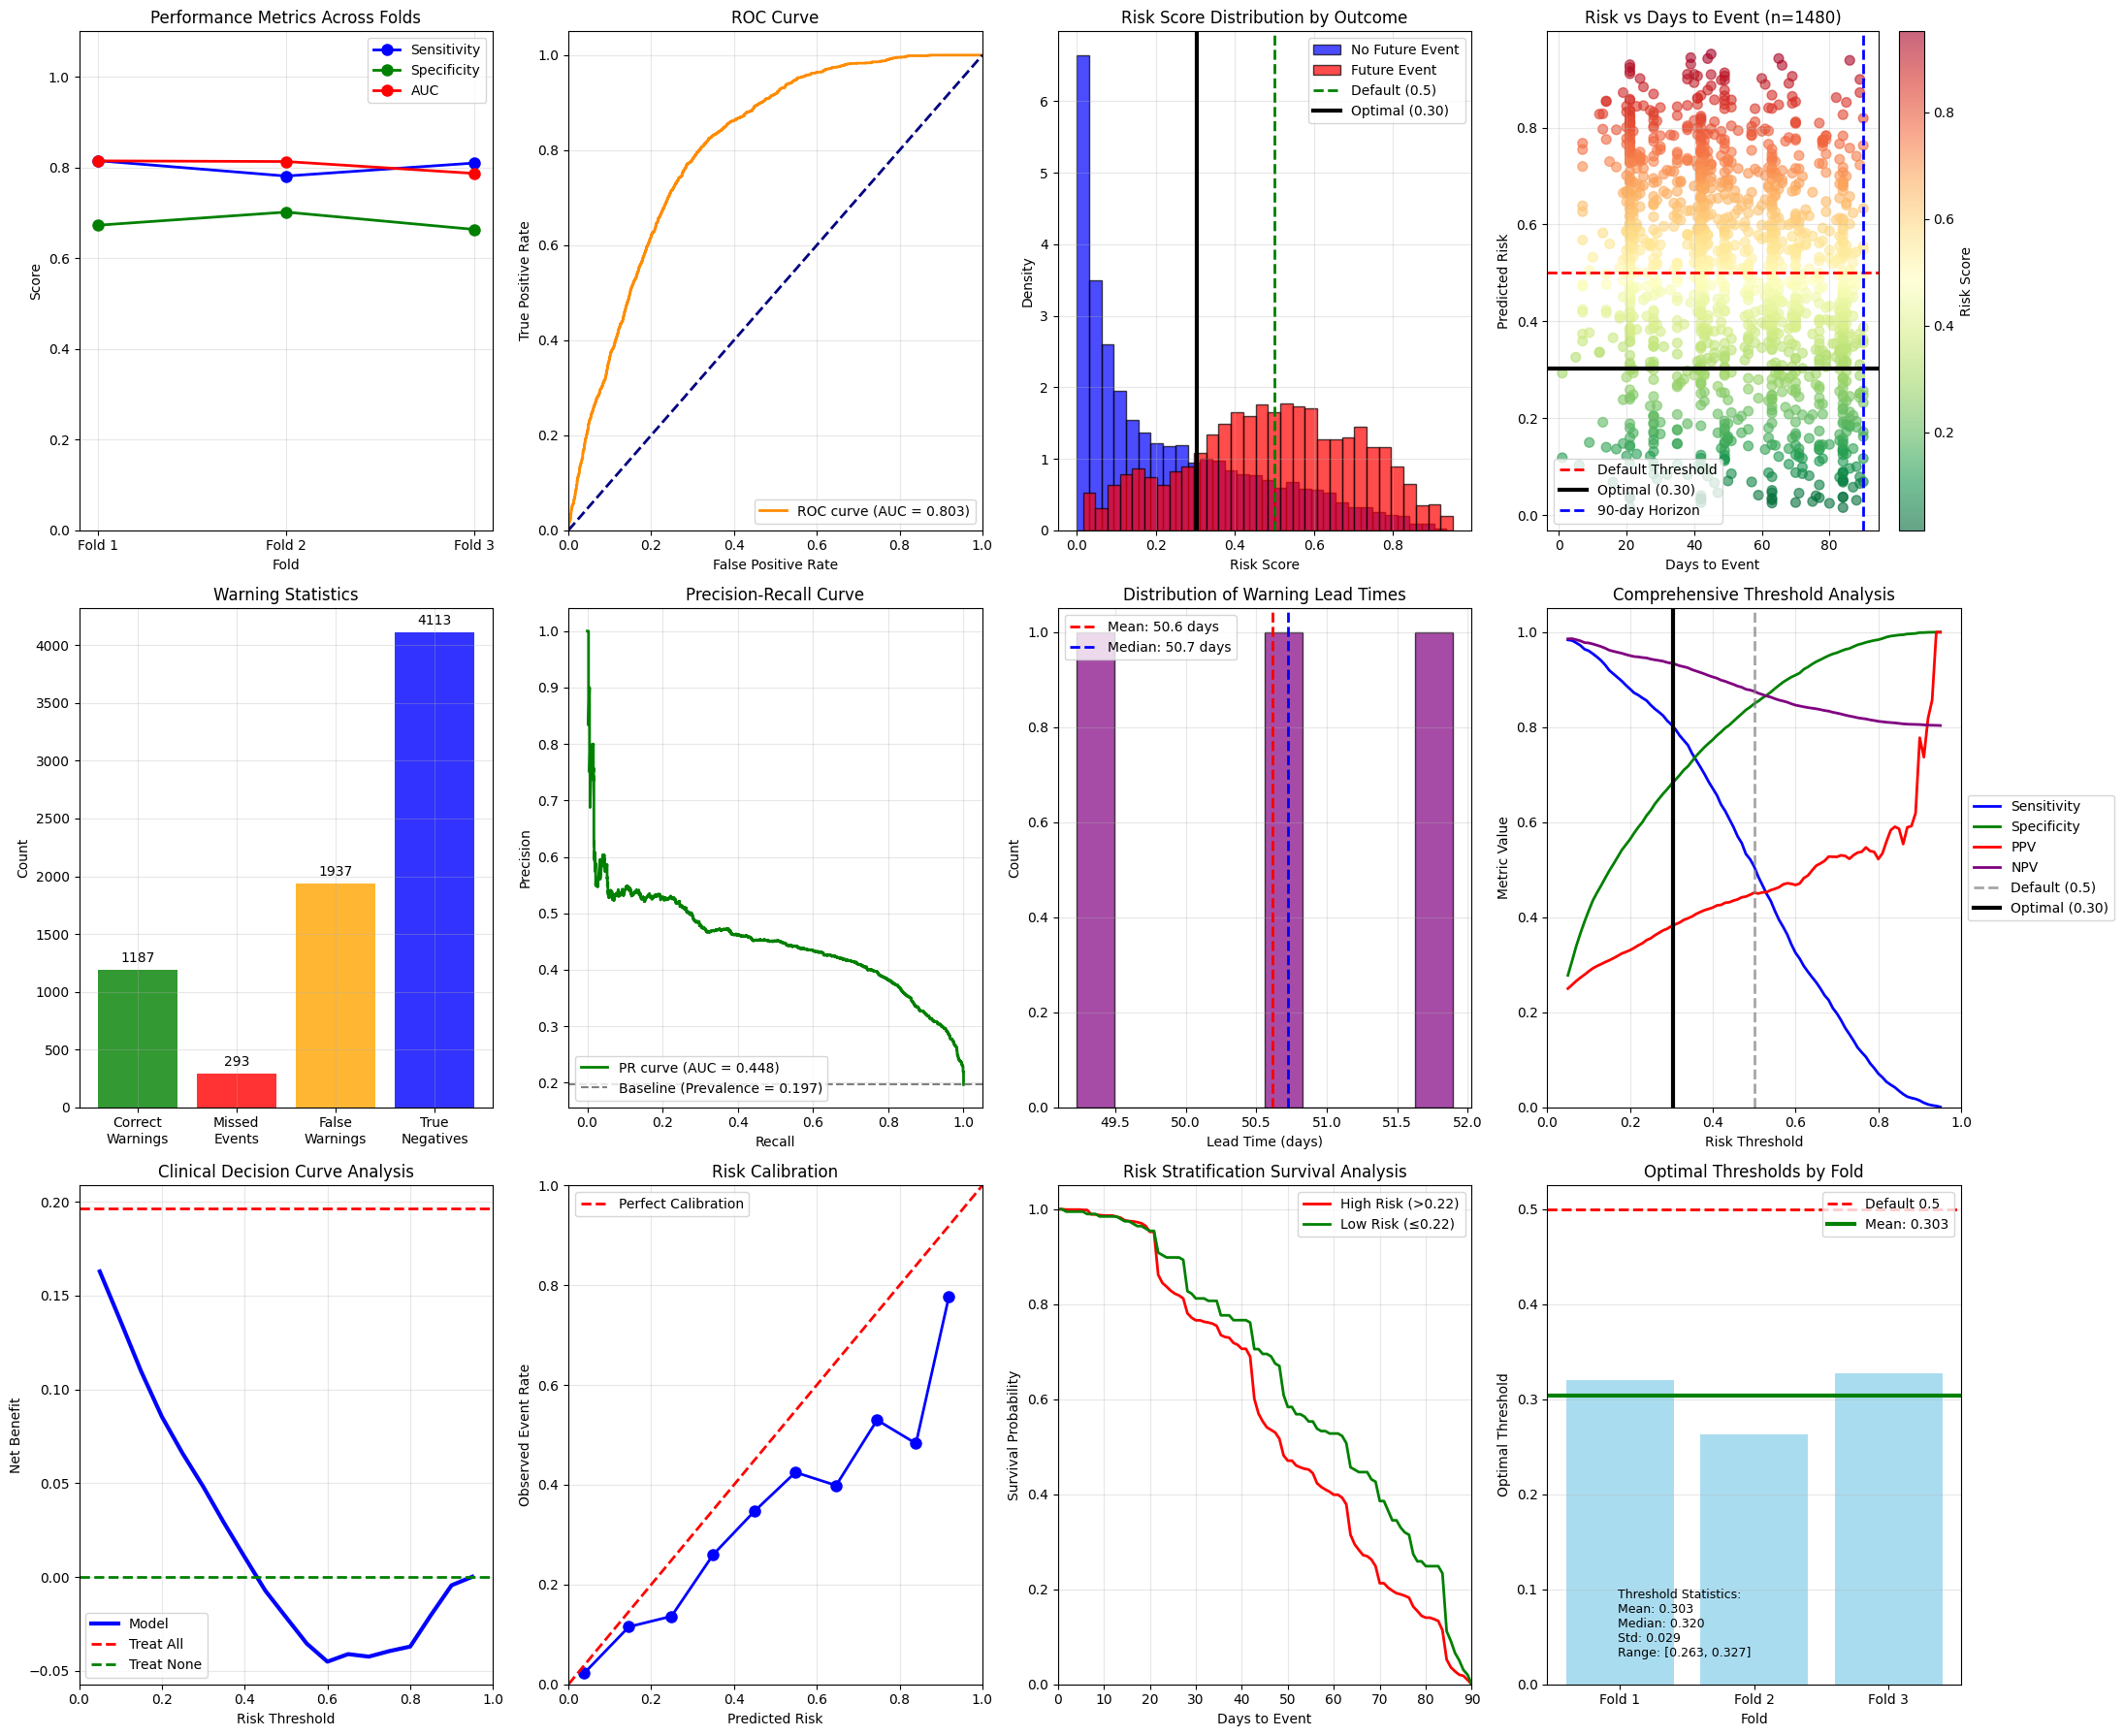


CLINICAL EARLY WARNING SYSTEM COMPLETED!

CLINICAL IMPLICATIONS:
--------------------------------------------------
1. System predicts death within next 90 days
2. Risk scores range from 0 (low risk) to 1 (high risk)
3. Optimal threshold: 0.303 (based on clinical utility)
4. Lead time = days between warning and actual event

Based on your data:
- 1098 patients died during follow-up
- System trained on 7530 patient sequences
- Prediction horizon: 90 days
- Used autoencoder imputation: True


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

class AutoencoderImputer:
    def __init__(self, encoding_dim=32, epochs=50, batch_size=32, random_state=42):
        self.encoding_dim = encoding_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.autoencoder = None
        self.is_fitted = False

    def build_autoencoder(self, input_dim):
        """Build a deep autoencoder for imputation"""
        input_layer = layers.Input(shape=(input_dim,))

        # Encoder
        encoded = layers.Dense(128, activation='relu')(input_layer)
        encoded = layers.Dropout(0.2)(encoded)
        encoded = layers.Dense(64, activation='relu')(encoded)
        encoded = layers.Dropout(0.2)(encoded)
        encoded = layers.Dense(self.encoding_dim, activation='relu')(encoded)

        # Decoder
        decoded = layers.Dense(64, activation='relu')(encoded)
        decoded = layers.Dropout(0.2)(decoded)
        decoded = layers.Dense(128, activation='relu')(decoded)
        decoded = layers.Dropout(0.2)(decoded)
        decoded = layers.Dense(input_dim, activation='linear')(decoded)

        # Autoencoder model
        autoencoder = models.Model(input_layer, decoded)

        # Encoder model (for feature extraction)
        encoder = models.Model(input_layer, encoded)

        autoencoder.compile(optimizer=Adam(learning_rate=0.001),
                           loss='mse',
                           metrics=['mae'])

        return autoencoder, encoder

    def fit_imputer(self, X_train):
        """Train autoencoder on complete data"""
        # Create mask for complete cases
        complete_mask = ~np.any(np.isnan(X_train), axis=1)
        X_complete = X_train[complete_mask]

        if len(X_complete) < 10:
            print(f"Warning: Only {len(X_complete)} complete cases for autoencoder training")
            return self

        # Scale the data
        X_scaled = self.scaler.fit_transform(X_complete)

        # Build and train autoencoder
        self.autoencoder, self.encoder = self.build_autoencoder(X_scaled.shape[1])

        early_stop = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            min_delta=0.001
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )

        # Train-validation split
        X_train_split, X_val_split = train_test_split(
            X_scaled, test_size=0.2, random_state=self.random_state
        )

        self.autoencoder.fit(
            X_train_split, X_train_split,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_data=(X_val_split, X_val_split),
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )

        self.is_fitted = True
        print(f"Autoencoder trained on {len(X_complete)} complete cases")

        return self

    def impute_missing_values(self, X, max_iter=20, tol=1e-4):
        """Impute missing values using trained autoencoder with iterative refinement"""
        if not self.is_fitted:
            print("Autoencoder not fitted. Fitting now...")
            self.fit_imputer(X)
            if not self.is_fitted:
                return X  # Return original if still not fitted

        X_imputed = X.copy()

        # Check for missing values
        if not np.any(np.isnan(X_imputed)):
            return X_imputed

        # Initial imputation with median
        for i in range(X_imputed.shape[1]):
            col_data = X_imputed[:, i]
            if np.any(np.isnan(col_data)):
                median_val = np.nanmedian(col_data)
                if np.isnan(median_val):
                    median_val = 0
                col_data[np.isnan(col_data)] = median_val
                X_imputed[:, i] = col_data

        # Iterative refinement
        for iteration in range(max_iter):
            X_old = X_imputed.copy()

            # Scale
            X_scaled = self.scaler.transform(X_imputed)

            # Get reconstructions
            X_reconstructed = self.autoencoder.predict(X_scaled, verbose=0)
            X_reconstructed = self.scaler.inverse_transform(X_reconstructed)

            # Only update missing values
            missing_mask = np.isnan(X)
            X_imputed[missing_mask] = X_reconstructed[missing_mask]

            # Check convergence
            if iteration > 0:
                change = np.linalg.norm(X_imputed - X_old) / np.linalg.norm(X_old)
                if change < tol:
                    print(f"Autoencoder imputation converged after {iteration+1} iterations")
                    break

        return X_imputed


class RobustTimeAwareDataProcessor:
    def __init__(self, use_autoencoder=True):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.use_autoencoder = use_autoencoder
        self.autoencoder_imputer = AutoencoderImputer() if use_autoencoder else None
        self.feature_names = None

    def clean_data(self, df):
        """Clean data by handling infinity, large values, and missing data"""
        df_clean = df.copy()

        # Replace infinity with NaN
        df_clean = df_clean.replace([np.inf, -np.inf], np.nan)

        # Handle extremely large values by capping at 99th percentile
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df_clean[col].notna().any():
                # Cap at 99th percentile
                p99 = df_clean[col].quantile(0.99)
                if not np.isnan(p99):
                    df_clean[col] = df_clean[col].clip(upper=p99 * 10)  # Allow some margin

        return df_clean

    def process_patient_data(self, df):
        """Process data with proper temporal structure"""
        # Clean data first
        df_clean = self.clean_data(df)

        # Handle missing survival data
        missing_before = len(df_clean)
        df_clean = df_clean.dropna(subset=['VISDAY', 'os_event'])
        missing_after = len(df_clean)
        print(f"Removed {missing_before - missing_after} rows with missing survival data")

        # Create patient IDs if not present
        if 'patient_id' not in df_clean.columns:
            # Try to find a patient identifier column
            possible_id_cols = ['RPT', 'SUBJID', 'PATIENT', 'patient', 'id', 'ID']
            found_id = False
            for col in possible_id_cols:
                if col in df_clean.columns:
                    df_clean['patient_id'] = df_clean[col]
                    print(f"Using '{col}' as patient identifier")
                    found_id = True
                    break

            if not found_id:
                # Create synthetic patient IDs (assuming ~5 visits per patient)
                df_clean['patient_id'] = np.arange(len(df_clean)) // 5
                print("Created synthetic patient IDs (5 visits per patient)")

        # Sort by patient and visit day
        df_sorted = df_clean.sort_values(['patient_id', 'VISDAY']).reset_index(drop=True)

        # Calculate time to event for each visit
        print("Calculating time-to-event for each visit...")
        df_sorted['time_to_event'] = np.nan
        df_sorted['is_future_event'] = 0

        unique_patients = df_sorted['patient_id'].unique()
        print(f"Processing {len(unique_patients)} patients...")

        for i, pid in enumerate(unique_patients):
            if i % 200 == 0:
                print(f"  Processed {i}/{len(unique_patients)} patients...")

            patient_data = df_sorted[df_sorted['patient_id'] == pid]

            # Check if patient died (os_event = 1)
            patient_events = patient_data['os_event'].values
            if np.any(patient_events == 1):
                # Patient died - find death day
                death_idx = np.where(patient_events == 1)[0]
                if len(death_idx) > 0:
                    death_day = patient_data.iloc[death_idx[0]]['VISDAY']

                    # For all visits before death, calculate days to death
                    for idx, row in patient_data.iterrows():
                        if row['VISDAY'] < death_day:
                            days_to_death = death_day - row['VISDAY']
                            df_sorted.at[idx, 'time_to_event'] = days_to_death
                            df_sorted.at[idx, 'is_future_event'] = 1
                        elif row['VISDAY'] == death_day:
                            # Death visit itself
                            df_sorted.at[idx, 'time_to_event'] = 0
                            df_sorted.at[idx, 'is_future_event'] = 0  # Not a future event
            else:
                # Patient survived - use maximum follow-up time
                last_visit_day = patient_data['VISDAY'].max()

                for idx, row in patient_data.iterrows():
                    days_from_last = last_visit_day - row['VISDAY']
                    df_sorted.at[idx, 'time_to_event'] = days_from_last
                    df_sorted.at[idx, 'is_future_event'] = 0

        # Handle any remaining NaN values in time_to_event
        nan_count = df_sorted['time_to_event'].isna().sum()
        if nan_count > 0:
            print(f"Warning: {nan_count} NaN values in time_to_event, filling with median")
            median_ttd = df_sorted['time_to_event'].median()
            df_sorted['time_to_event'] = df_sorted['time_to_event'].fillna(median_ttd)

        print(f"Processed {len(df_sorted)} visits from {len(unique_patients)} patients")

        # Count patients with events
        event_patients = df_sorted[df_sorted['os_event'] == 1]['patient_id'].unique()
        no_event_patients = df_sorted[df_sorted['os_event'] == 0]['patient_id'].unique()

        print(f"Patients with event: {len(event_patients)}")
        print(f"Patients without event: {len(no_event_patients)}")
        print(f"Visits with future event: {df_sorted['is_future_event'].sum()}")

        return df_sorted

    def prepare_features_with_autoencoder(self, df_train, df_test, feature_names):
        """Prepare features with autoencoder imputation for train and test separately"""
        print(f"Using autoencoder imputation: {self.use_autoencoder}")

        # Select features that exist in dataframe
        available_features = [f for f in feature_names if f in df_train.columns]
        print(f"Using {len(available_features)} available features")

        # Prepare train and test data
        X_train_raw = df_train[available_features].copy()
        X_test_raw = df_test[available_features].copy()

        # Replace any infinity values
        X_train_raw = X_train_raw.replace([np.inf, -np.inf], np.nan)
        X_test_raw = X_test_raw.replace([np.inf, -np.inf], np.nan)

        # Handle categorical variables
        categorical_cols = X_train_raw.select_dtypes(exclude=[np.number]).columns
        numeric_cols = X_train_raw.select_dtypes(include=[np.number]).columns

        print(f"Categorical columns: {len(categorical_cols)}")
        print(f"Numeric columns: {len(numeric_cols)}")

        # Encode categorical variables
        encoded_train = []
        encoded_test = []

        for col in categorical_cols:
            try:
                if col not in self.label_encoders:
                    self.label_encoders[col] = LabelEncoder()
                    # Combine train and test for fitting to handle all categories
                    combined = pd.concat([X_train_raw[col], X_test_raw[col]], ignore_index=True)
                    combined = combined.astype(str).fillna('missing')
                    self.label_encoders[col].fit(combined)

                # Transform train and test
                train_encoded = self.label_encoders[col].transform(
                    X_train_raw[col].astype(str).fillna('missing')
                )
                test_encoded = self.label_encoders[col].transform(
                    X_test_raw[col].astype(str).fillna('missing')
                )

                encoded_train.append(train_encoded.reshape(-1, 1))
                encoded_test.append(test_encoded.reshape(-1, 1))

            except Exception as e:
                print(f"Warning: Could not encode column {col}: {e}")
                # Drop problematic column
                continue

        # Combine categorical and numeric data
        X_train_combined = []
        X_test_combined = []

        if len(categorical_cols) > 0 and encoded_train:
            X_train_cat = np.hstack(encoded_train)
            X_test_cat = np.hstack(encoded_test)
            X_train_combined.append(X_train_cat)
            X_test_combined.append(X_test_cat)

        if len(numeric_cols) > 0:
            X_train_num = X_train_raw[numeric_cols].values
            X_test_num = X_test_raw[numeric_cols].values
            X_train_combined.append(X_train_num)
            X_test_combined.append(X_test_num)

        # Combine all features
        if X_train_combined:
            X_train = np.hstack(X_train_combined)
            X_test = np.hstack(X_test_combined)
        else:
            print("Warning: No features available after preprocessing")
            return None, None, available_features

        print(f"Train data shape before imputation: {X_train.shape}")
        print(f"Test data shape before imputation: {X_test.shape}")
        print(f"Missing values in train: {np.isnan(X_train).sum()} ({np.isnan(X_train).mean()*100:.1f}%)")
        print(f"Missing values in test: {np.isnan(X_test).sum()} ({np.isnan(X_test).mean()*100:.1f}%)")

        if self.use_autoencoder and self.autoencoder_imputer:
            # Fit autoencoder on training data
            print("\nFitting autoencoder on training data...")
            self.autoencoder_imputer.fit_imputer(X_train)

            # Impute missing values separately for train and test
            print("Imputing missing values in training set...")
            X_train_imputed = self.autoencoder_imputer.impute_missing_values(X_train)

            print("Imputing missing values in test set...")
            X_test_imputed = self.autoencoder_imputer.impute_missing_values(X_test)

            # Scale the imputed data
            X_train_scaled = self.scaler.fit_transform(X_train_imputed)
            X_test_scaled = self.scaler.transform(X_test_imputed)

            print(f"Missing values after autoencoder imputation (train): {np.isnan(X_train_scaled).sum()}")
            print(f"Missing values after autoencoder imputation (test): {np.isnan(X_test_scaled).sum()}")

            return X_train_scaled, X_test_scaled, available_features
        else:
            # Fallback: Simple imputation
            print("Using simple imputation (median/mode)...")

            # Impute missing values with median for numeric, mode for categorical
            for i in range(X_train.shape[1]):
                # Train imputation
                train_col = X_train[:, i]
                if np.any(np.isnan(train_col)):
                    if i < len(categorical_cols):
                        # Categorical - use mode
                        mode_val = np.nanmode(train_col)
                        if np.isnan(mode_val):
                            mode_val = 0
                        X_train[:, i] = np.nan_to_num(train_col, nan=mode_val)
                    else:
                        # Numeric - use median
                        median_val = np.nanmedian(train_col)
                        if np.isnan(median_val):
                            median_val = 0
                        X_train[:, i] = np.nan_to_num(train_col, nan=median_val)

                # Test imputation (using statistics from train)
                test_col = X_test[:, i]
                if np.any(np.isnan(test_col)):
                    if i < len(categorical_cols):
                        # Categorical - use mode from train
                        mode_val = np.nanmode(X_train[:, i])
                        if np.isnan(mode_val):
                            mode_val = 0
                        X_test[:, i] = np.nan_to_num(test_col, nan=mode_val)
                    else:
                        # Numeric - use median from train
                        median_val = np.nanmedian(X_train[:, i])
                        if np.isnan(median_val):
                            median_val = 0
                        X_test[:, i] = np.nan_to_num(test_col, nan=median_val)

            # Scale the data
            X_train_scaled = self.scaler.fit_transform(X_train)
            X_test_scaled = self.scaler.transform(X_test)

            return X_train_scaled, X_test_scaled, available_features

    def prepare_features(self, df, feature_names):
        """Legacy method for backward compatibility - prepares features without train/test split"""
        print("Warning: Using legacy prepare_features method without train/test split")

        # Select features that exist in dataframe
        available_features = [f for f in feature_names if f in df.columns]
        print(f"Using {len(available_features)} available features")

        # Handle missing values
        df_filled = df[available_features].copy()

        # Replace any remaining infinity values
        df_filled = df_filled.replace([np.inf, -np.inf], np.nan)

        # Fill numeric missing values with median
        numeric_cols = df_filled.select_dtypes(include=[np.number]).columns
        print(f"Processing {len(numeric_cols)} numeric columns...")

        for col in numeric_cols:
            if df_filled[col].isnull().any():
                median_val = df_filled[col].median()
                if pd.isna(median_val):
                    median_val = 0  # Fallback
                df_filled[col] = df_filled[col].fillna(median_val)

        # Fill categorical missing values with mode
        categorical_cols = df_filled.select_dtypes(exclude=[np.number]).columns
        print(f"Processing {len(categorical_cols)} categorical columns...")

        for col in categorical_cols:
            if df_filled[col].isnull().any():
                mode_val = df_filled[col].mode()
                if len(mode_val) > 0:
                    df_filled[col] = df_filled[col].fillna(mode_val[0])
                else:
                    df_filled[col] = df_filled[col].fillna('missing')

        # Encode categorical variables
        print("Encoding categorical variables...")
        for col in categorical_cols:
            try:
                if col not in self.label_encoders:
                    self.label_encoders[col] = LabelEncoder()
                    # Handle any non-string values
                    col_data = df_filled[col].astype(str)
                    self.label_encoders[col].fit(col_data)

                df_filled[col] = self.label_encoders[col].transform(df_filled[col].astype(str))
            except Exception as e:
                print(f"Warning: Could not encode column {col}: {e}")
                # Drop problematic column
                df_filled = df_filled.drop(columns=[col])
                available_features.remove(col)

        # Scale numeric features
        if len(numeric_cols) > 0:
            print("Scaling numeric features...")
            # Check for any remaining issues
            numeric_data = df_filled[numeric_cols].values
            if np.any(np.isnan(numeric_data)) or np.any(np.isinf(numeric_data)):
                print("Warning: NaN or Inf found in numeric data after cleaning")
                # Replace with zeros as last resort
                numeric_data = np.nan_to_num(numeric_data, nan=0.0, posinf=1e6, neginf=-1e6)
                df_filled[numeric_cols] = numeric_data

            try:
                df_filled[numeric_cols] = self.scaler.fit_transform(df_filled[numeric_cols])
            except Exception as e:
                print(f"Warning: Could not scale features: {e}")
                # Use min-max scaling as fallback
                for col in numeric_cols:
                    col_min = df_filled[col].min()
                    col_max = df_filled[col].max()
                    if col_max > col_min:
                        df_filled[col] = (df_filled[col] - col_min) / (col_max - col_min)
                    else:
                        df_filled[col] = 0

        print(f"Final feature matrix shape: {df_filled.shape}")
        return df_filled.values, available_features

    def create_temporal_sequences(self, df, feature_cols, max_sequence_length=5, prediction_horizon=90):
        """Create sequences with proper temporal structure"""
        print("Creating temporal sequences...")
        sequences = []
        labels = []
        time_intervals = []
        patient_ids = []
        days_to_event_list = []

        unique_patients = df['patient_id'].unique()

        for pid in unique_patients:
            patient_data = df[df['patient_id'] == pid].sort_values('VISDAY')

            if len(patient_data) < 2:
                continue  # Need at least 2 visits

            # Get features and temporal data
            patient_features = patient_data[feature_cols].values
            patient_visdays = patient_data['VISDAY'].values
            patient_time_to_event = patient_data['time_to_event'].values
            patient_has_event = patient_data['is_future_event'].values

            # Create sequences
            for i in range(1, len(patient_data)):  # Start from 1 to have at least one previous visit
                # Determine sequence length (up to max_sequence_length)
                seq_len = min(i, max_sequence_length)
                start_idx = i - seq_len

                # Get sequence data
                seq_features = patient_features[start_idx:i+1]  # Including current visit
                seq_visdays = patient_visdays[start_idx:i+1]

                # Calculate time intervals between visits (in days)
                if len(seq_visdays) > 1:
                    time_diffs = np.diff(seq_visdays)
                    # Add a default 30-day interval for the first gap
                    time_diffs = np.concatenate([[30], time_diffs])
                else:
                    time_diffs = np.array([30])

                # Normalize time intervals (divide by 30 to get approximate months)
                time_diffs_normalized = time_diffs / 30.0

                # Create label: will event occur within prediction horizon?
                current_time_to_event = patient_time_to_event[i]
                if current_time_to_event <= prediction_horizon and current_time_to_event > 0:
                    label = 1  # Event will occur within horizon
                else:
                    label = 0  # No event within horizon

                # Pad sequence if needed
                if seq_len < max_sequence_length:
                    pad_len = max_sequence_length - seq_len
                    seq_features = np.pad(seq_features, ((pad_len, 0), (0, 0)), mode='constant')
                    time_diffs_normalized = np.pad(time_diffs_normalized, (pad_len, 0),
                                                  mode='constant', constant_values=1.0)  # 1 month for padding

                sequences.append(seq_features)
                labels.append(label)
                time_intervals.append(time_diffs_normalized)
                patient_ids.append(pid)
                days_to_event_list.append(current_time_to_event)

        sequences = np.array(sequences)
        labels = np.array(labels)
        time_intervals = np.array(time_intervals)
        patient_ids = np.array(patient_ids)

        print(f"\nCreated {len(sequences)} sequences")
        print(f"Positive sequences (event within {prediction_horizon} days): {np.sum(labels == 1)} ({np.mean(labels == 1)*100:.1f}%)")
        print(f"Negative sequences: {np.sum(labels == 0)}")

        # Analyze positive sequences
        if np.sum(labels == 1) > 0:
            positive_days = np.array(days_to_event_list)[labels == 1]
            print(f"Days to event for positive sequences:")
            print(f"  Mean: {np.mean(positive_days):.1f} days")
            print(f"  Median: {np.median(positive_days):.1f} days")
            print(f"  Range: {np.min(positive_days):.1f} to {np.max(positive_days):.1f} days")

        return sequences, labels, time_intervals, patient_ids, days_to_event_list


class TimeAwareEarlyWarningModel:
    def __init__(self, input_dim, sequence_length=5, lstm_units=64):
        self.input_dim = input_dim
        self.sequence_length = sequence_length
        self.lstm_units = lstm_units
        self.model = None
        self.history = None

    def build_model_with_time_awareness(self):
        """Build model that incorporates time intervals between visits"""
        # Two input layers: features and time intervals
        feature_input = layers.Input(shape=(self.sequence_length, self.input_dim), name='features')
        time_input = layers.Input(shape=(self.sequence_length, 1), name='time_intervals')

        # Process time intervals
        time_processed = layers.Dense(8, activation='relu')(time_input)
        time_processed = layers.Dense(16, activation='relu')(time_processed)

        # Concatenate features with time information
        combined = layers.Concatenate(axis=-1)([feature_input, time_processed])

        # LSTM layers
        lstm_out = layers.Bidirectional(layers.LSTM(self.lstm_units, return_sequences=True))(combined)
        lstm_out = layers.Dropout(0.3)(lstm_out)

        # Simple attention mechanism
        attention_scores = layers.TimeDistributed(layers.Dense(1, activation='tanh'))(lstm_out)
        attention_weights = layers.Softmax(axis=1)(attention_scores)
        context_vector = layers.Multiply()([lstm_out, attention_weights])

        # Global average pooling instead of just last time step
        pooled = layers.GlobalAveragePooling1D()(context_vector)

        # Dense layers
        dense1 = layers.Dense(64, activation='relu')(pooled)
        dense1 = layers.BatchNormalization()(dense1)
        dense1 = layers.Dropout(0.3)(dense1)

        dense2 = layers.Dense(32, activation='relu')(dense1)
        dense2 = layers.BatchNormalization()(dense2)
        dense2 = layers.Dropout(0.2)(dense2)

        # Output: risk of event within prediction horizon
        risk_score = layers.Dense(1, activation='sigmoid', name='risk_score')(dense2)

        # Create model
        self.model = models.Model(inputs=[feature_input, time_input], outputs=risk_score)

        return self.model

    def compile_model(self, learning_rate=0.001):
        """Compile the model"""
        self.model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall')]
        )

        return self.model

    def train(self, X_features, X_time, y_train, val_data=None, epochs=100, batch_size=32, class_weight=None):
        """Train the model"""
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss' if val_data else 'loss',
            patience=15,
            restore_best_weights=True,
            min_delta=0.001,
            verbose=0
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss' if val_data else 'loss',
            factor=0.5,
            patience=8,
            min_lr=1e-6,
            verbose=0
        )

        callbacks_list = [early_stopping, reduce_lr]

        if val_data:
            X_val_features, X_val_time, y_val = val_data
            validation_data = ([X_val_features, X_val_time], y_val)
        else:
            validation_data = None

        self.history = self.model.fit(
            [X_features, X_time], y_train,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks_list,
            verbose=0,
            class_weight=class_weight
        )

        return self.history

    def predict(self, X_features, X_time):
        """Make predictions"""
        return self.model.predict([X_features, X_time], verbose=0).flatten()


class ClinicalEarlyWarningPipeline:
    def __init__(self, prediction_horizon_days=90, n_splits=3, random_state=42, use_autoencoder=True):
        self.prediction_horizon = prediction_horizon_days
        self.n_splits = n_splits
        self.random_state = random_state
        self.use_autoencoder = use_autoencoder
        self.data_processor = RobustTimeAwareDataProcessor(use_autoencoder=use_autoencoder)
        self.results = {}
        self.optimal_thresholds = {}

    def optimize_threshold_clinical(self, y_true, y_pred_proba, days_to_event=None, method='cost_sensitive'):
        """
        Optimize threshold based on clinical utility rather than just F1 score
        Methods:
        - 'cost_sensitive': Balance FP vs FN based on clinical costs
        - 'youden': Maximize Youden's J statistic (sensitivity + specificity - 1)
        - 'closest_topleft': Closest point to (0,1) on ROC curve
        - 'risk_stratified': Based on risk score distribution
        - 'survival_weighted': Weight by time to event (earlier warnings more valuable)
        """

        thresholds = np.linspace(0.05, 0.95, 181)  # More granular threshold search

        if method == 'cost_sensitive':
            # Clinical cost matrix: FN cost (missing a death) > FP cost (false alarm)
            # In clinical settings, missing a death is typically 5-10x worse than false alarm
            fn_cost = 5.0  # Cost of missing a death (false negative)
            fp_cost = 1.0  # Cost of false alarm (false positive)

            best_cost = float('inf')
            best_threshold = 0.5

            for thresh in thresholds:
                y_pred = (y_pred_proba >= thresh).astype(int)

                tn = np.sum((y_true == 0) & (y_pred == 0))
                fp = np.sum((y_true == 0) & (y_pred == 1))
                fn = np.sum((y_true == 1) & (y_pred == 0))
                tp = np.sum((y_true == 1) & (y_pred == 1))

                # Calculate total cost
                total_cost = fp * fp_cost + fn * fn_cost

                # Normalize by number of samples
                normalized_cost = total_cost / len(y_true)

                if normalized_cost < best_cost:
                    best_cost = normalized_cost
                    best_threshold = thresh

            print(f"Cost-sensitive optimal threshold: {best_threshold:.3f} (cost: {best_cost:.4f})")
            return best_threshold

        elif method == 'youden':
            # Maximize Youden's J statistic
            best_j = -1
            best_threshold = 0.5

            for thresh in thresholds:
                y_pred = (y_pred_proba >= thresh).astype(int)

                tn = np.sum((y_true == 0) & (y_pred == 0))
                fp = np.sum((y_true == 0) & (y_pred == 1))
                fn = np.sum((y_true == 1) & (y_pred == 0))
                tp = np.sum((y_true == 1) & (y_pred == 1))

                sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

                j = sensitivity + specificity - 1

                if j > best_j:
                    best_j = j
                    best_threshold = thresh

            print(f"Youden's J optimal threshold: {best_threshold:.3f} (J: {best_j:.4f})")
            return best_threshold

        elif method == 'closest_topleft':
            # Find threshold closest to (0,1) on ROC curve
            fpr, tpr, thresh_vals = roc_curve(y_true, y_pred_proba)

            # Calculate distance to (0,1)
            distances = np.sqrt(fpr**2 + (1 - tpr)**2)
            best_idx = np.argmin(distances)
            best_threshold = thresh_vals[best_idx] if best_idx < len(thresh_vals) else 0.5

            print(f"Closest to top-left optimal threshold: {best_threshold:.3f}")
            return best_threshold

        elif method == 'risk_stratified':
            # Set threshold based on risk score distribution
            # Aim for top X% of patients to be flagged as high risk
            target_percentage_high_risk = 0.15  # Flag top 15% as high risk

            sorted_scores = np.sort(y_pred_proba)
            idx = int(len(sorted_scores) * (1 - target_percentage_high_risk))
            best_threshold = sorted_scores[idx] if idx < len(sorted_scores) else 0.5

            print(f"Risk-stratified threshold: {best_threshold:.3f} (top {target_percentage_high_risk*100:.1f}%)")
            return best_threshold

        elif method == 'survival_weighted' and days_to_event is not None:
            # Weight by time to event - earlier warnings are more valuable
            best_utility = -1
            best_threshold = 0.5

            for thresh in thresholds:
                y_pred = (y_pred_proba >= thresh).astype(int)

                # Calculate weighted utility
                utility = 0

                # For true positives, weight by how early the warning was
                tp_mask = (y_true == 1) & (y_pred == 1)
                if np.any(tp_mask):
                    tp_days = days_to_event[tp_mask]
                    # Early warnings get higher weight (more days to event)
                    # Weight = 1 + (days_to_event / prediction_horizon)
                    tp_weights = 1 + (tp_days / self.prediction_horizon)
                    utility += np.sum(tp_weights)

                # For false positives, penalize
                fp_mask = (y_true == 0) & (y_pred == 1)
                utility -= np.sum(fp_mask) * 0.5  # Lower penalty than missing a death

                # For true negatives, small reward
                tn_mask = (y_true == 0) & (y_pred == 0)
                utility += np.sum(tn_mask) * 0.1

                if utility > best_utility:
                    best_utility = utility
                    best_threshold = thresh

            print(f"Survival-weighted optimal threshold: {best_threshold:.3f} (utility: {best_utility:.2f})")
            return best_threshold

        else:
            # Default: Maximize F1 score
            best_f1 = 0
            best_threshold = 0.5

            for thresh in thresholds:
                y_pred = (y_pred_proba >= thresh).astype(int)
                f1 = f1_score(y_true, y_pred, zero_division=0)

                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = thresh

            print(f"F1-optimized threshold: {best_threshold:.3f} (F1: {best_f1:.4f})")
            return best_threshold

    def find_optimal_threshold_ensemble(self, y_true, y_pred_proba, days_to_event=None):
        """
        Use ensemble of methods to find robust optimal threshold
        """
        methods = ['cost_sensitive', 'youden', 'closest_topleft', 'survival_weighted']
        thresholds = []
        weights = []

        for method in methods:
            try:
                if method == 'survival_weighted' and days_to_event is not None:
                    thresh = self.optimize_threshold_clinical(y_true, y_pred_proba, days_to_event, method)
                else:
                    thresh = self.optimize_threshold_clinical(y_true, y_pred_proba, method=method)
                thresholds.append(thresh)

                # Weight methods based on clinical relevance
                if method == 'cost_sensitive':
                    weights.append(0.4)  # Most important: clinical costs
                elif method == 'survival_weighted':
                    weights.append(0.3)  # Important: consider time to event
                elif method == 'youden':
                    weights.append(0.2)  # Standard metric
                else:
                    weights.append(0.1)  # Other methods

            except Exception as e:
                print(f"Method {method} failed: {e}")
                continue

        if thresholds:
            # Weighted average of thresholds
            weights = np.array(weights) / np.sum(weights)
            optimal_threshold = np.average(thresholds, weights=weights)
            print(f"\nEnsemble optimal threshold: {optimal_threshold:.3f}")
            print(f"Individual thresholds: {[f'{t:.3f}' for t in thresholds]}")
            print(f"Weights: {weights}")

            return optimal_threshold
        else:
            print("All threshold optimization methods failed, using default 0.5")
            return 0.5

    def select_clinical_features(self, df):
        """Select relevant clinical features for early warning"""
        # Common clinical features for mortality prediction
        base_features = [
            'AGE', 'SEX', 'RACE',  # Demographics
            'BMI', 'WEIGHT', 'HEIGHT',  # Anthropometrics
            'ECOG', 'KPS',  # Performance status
        ]

        # Lab values (if available)
        lab_features = [
            'ALB', 'ALP', 'ALT', 'AST', 'BILI', 'CALCIUM', 'CREAT', 'HGB',
            'LYMPH', 'NEUT', 'PLAT', 'WBC', 'SODIUM', 'POTASSIUM', 'GLUCOSE',
            'BUN', 'CRP', 'LDH'
        ]

        # Treatment and AE features from your data
        treatment_features = [
            'cycle_number', 'total_cycles', 'anytarget', 'anynontarget',
            'total_ae_events', 'serious_ae_count', 'grade3_plus_count',
            'any_grade3_plus', 'treatment_related_count', 'any_treatment_related',
            'grade1_count', 'grade2_count', 'grade3_count', 'grade4_count',
            'drug_interrupted', 'drug_reduced', 'drug_withdrawn', 'drug_not_changed',
            'other_drug_interrupted', 'other_drug_reduced', 'other_drug_withdrawn',
            'concomitant_treatment_given', 'cum_any_grade3_plus',
            'cum_any_treatment_related', 'cum_drug_withdrawn',
            'cum_other_drug_withdrawn', 'cum_concomitant_treatment',
            'ongoing_ae_count', 'mean_ae_duration', 'max_ae_duration'
        ]

        # Combine and check availability
        all_possible = base_features + lab_features + treatment_features
        available_features = [f for f in all_possible if f in df.columns]

        print(f"Found {len(available_features)} available features out of {len(all_possible)} possible")

        # If we have very few features, use some defaults
        if len(available_features) < 10:
            print("Warning: Few features available, using basic set")
            # Try to find any numeric columns
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            # Exclude ID and date columns
            exclude_cols = ['VISDAY', 'DSDAY', 'patient_id', 'id', 'index', 'time_to_event', 'is_future_event']
            numeric_cols = [c for c in numeric_cols if c not in exclude_cols]
            available_features = numeric_cols[:20]  # Take first 20 numeric columns

        return available_features

    def run_pipeline(self, pcdata):
        """Run the complete early warning pipeline"""
        print("="*70)
        print("CLINICAL EARLY WARNING SYSTEM FOR MORTALITY PREDICTION")
        print("="*70)
        print(f"Prediction horizon: {self.prediction_horizon} days")
        print(f"Using autoencoder imputation: {self.use_autoencoder}")
        print(f"Looking for death events within next {self.prediction_horizon} days")

        # Step 1: Process data with temporal structure
        print("\n1. Processing temporal data...")
        print("-"*40)

        df_processed = self.data_processor.process_patient_data(pcdata)

        # Step 2: Prepare features (we'll do this separately for each fold)
        print("\n2. Selecting clinical features...")
        print("-"*40)

        feature_names = self.select_clinical_features(df_processed)
        print(f"Selected {len(feature_names)} features for modeling")

        # Add processed features back to dataframe (we'll impute in each fold)
        feature_cols = [f'feat_{i}' for i in range(len(feature_names))]

        # Step 3: Create temporal sequences (with raw features)
        print("\n3. Creating temporal sequences...")
        print("-"*40)

        # We'll use the raw data and impute in each fold
        df_for_sequences = df_processed.copy()
        # Store original values for imputation
        for i, feat in enumerate(feature_names):
            if feat in df_for_sequences.columns:
                df_for_sequences[f'feat_{i}'] = df_for_sequences[feat]

        sequences, labels, time_intervals, patient_ids, days_to_event = self.data_processor.create_temporal_sequences(
            df_for_sequences, feature_cols, max_sequence_length=5,
            prediction_horizon=self.prediction_horizon
        )

        if len(sequences) == 0:
            print("Error: No sequences created!")
            return None

        print(f"Sequence shape: {sequences.shape}")
        print(f"Time intervals shape: {time_intervals.shape}")

        # Step 4: Analyze data balance
        print("\n4. Analyzing data balance...")
        print("-"*40)

        positive_rate = np.mean(labels == 1)
        print(f"Positive rate (event within {self.prediction_horizon} days): {positive_rate:.3f}")

        if positive_rate < 0.01:
            print("Warning: Very low positive rate, model may struggle to learn")
            print("Consider increasing prediction horizon or using different labeling")

        # Step 5: Cross-validation with fold-specific imputation
        print("\n5. Running cross-validation with fold-specific imputation...")
        print("-"*40)

        # Create patient-level splits
        unique_patients = np.unique(patient_ids)
        print(f"Unique patients in sequences: {len(unique_patients)}")

        # Get patient labels (max label across their sequences)
        patient_labels = []

        for pid in unique_patients:
            patient_mask = patient_ids == pid
            patient_label = np.max(labels[patient_mask])  # Patient has event if any sequence does
            patient_labels.append(patient_label)

        patient_labels = np.array(patient_labels)

        print(f"Patients with future event in sequences: {np.sum(patient_labels == 1)}")
        print(f"Patients without future event in sequences: {np.sum(patient_labels == 0)}")

        if np.sum(patient_labels == 1) < 2:
            print(f"Error: Only {np.sum(patient_labels == 1)} patients with events")
            print("Cannot perform cross-validation. Using simple train/test split instead.")
            return self.run_simple_split(sequences, labels, time_intervals, patient_ids, days_to_event, df_processed, feature_names)

        n_folds = min(self.n_splits, np.sum(patient_labels == 1))
        if n_folds < self.n_splits:
            print(f"Reducing CV folds to {n_folds} (only {np.sum(patient_labels == 1)} patients with events)")

        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=self.random_state)

        cv_results = {
            'fold': [],
            'sensitivity': [], 'specificity': [], 'auc': [],
            'precision': [], 'recall': [], 'f1': [],
            'lead_times': [], 'warning_stats': [],
            'risk_scores': [], 'true_labels': [],
            'days_to_event': []
        }

        fold = 1
        for train_patient_idx, test_patient_idx in skf.split(unique_patients, patient_labels):
            print(f"\n{'='*60}")
            print(f"FOLD {fold}/{n_folds}")
            print(f"{'='*60}")

            # Get patient IDs for train/test
            train_patient_ids = unique_patients[train_patient_idx]
            test_patient_ids = unique_patients[test_patient_idx]

            print(f"Training patients: {len(train_patient_ids)}")
            print(f"Test patients: {len(test_patient_ids)}")

            # Create masks
            train_mask = np.isin(patient_ids, train_patient_ids)
            test_mask = np.isin(patient_ids, test_patient_ids)

            # Split data (raw sequences)
            X_train_seq_raw = sequences[train_mask]
            X_test_seq_raw = sequences[test_mask]

            X_train_time = time_intervals[train_mask]
            X_test_time = time_intervals[test_mask]

            y_train = labels[train_mask]
            y_test = labels[test_mask]

            test_days_to_event = np.array(days_to_event)[test_mask]
            test_pids = patient_ids[test_mask]

            train_pids = patient_ids[train_mask]

            # Step: IMPUTE MISSING VALUES SEPARATELY FOR TRAIN AND TEST
            print("\n6. Imputing missing values with autoencoder...")
            print("-"*40)

            # Reshape sequences for imputation (flatten temporal dimension)
            n_train_samples, seq_len, n_features = X_train_seq_raw.shape
            n_test_samples = X_test_seq_raw.shape[0]

            X_train_flat = X_train_seq_raw.reshape(n_train_samples * seq_len, n_features)
            X_test_flat = X_test_seq_raw.reshape(n_test_samples * seq_len, n_features)

            # Create temporary dataframes for imputation
            df_train_impute = pd.DataFrame(X_train_flat, columns=feature_cols)
            df_test_impute = pd.DataFrame(X_test_flat, columns=feature_cols)

            # Add patient_id for grouping (but we won't use it for imputation)
            train_patient_ids_repeated = np.repeat(train_pids, seq_len)
            test_patient_ids_repeated = np.repeat(test_pids, seq_len)

            # Impute missing values separately for train and test
            X_train_imputed_flat, X_test_imputed_flat, _ = self.data_processor.prepare_features_with_autoencoder(
                df_train_impute, df_test_impute, feature_cols
            )

            # Reshape back to sequences
            X_train_seq_imputed = X_train_imputed_flat.reshape(n_train_samples, seq_len, n_features)
            X_test_seq_imputed = X_test_imputed_flat.reshape(n_test_samples, seq_len, n_features)

            print(f"Train sequences after imputation: {X_train_seq_imputed.shape}")
            print(f"Test sequences after imputation: {X_test_seq_imputed.shape}")

            # Split training for validation
            unique_train_pids = np.unique(train_pids)
            val_patient_count = max(1, int(0.2 * len(unique_train_pids)))
            val_patient_ids = np.random.choice(unique_train_pids, val_patient_count, replace=False)
            val_mask = np.isin(train_pids, val_patient_ids)

            X_val_seq = X_train_seq_imputed[val_mask]
            X_val_time = X_train_time[val_mask]
            y_val = y_train[val_mask]
            val_days_to_event = np.array(days_to_event)[train_mask][val_mask]

            X_train_seq_final = X_train_seq_imputed[~val_mask]
            X_train_time_final = X_train_time[~val_mask]
            y_train_final = y_train[~val_mask]

            print(f"Training sequences: {X_train_seq_final.shape[0]} (pos: {np.mean(y_train_final):.3f})")
            print(f"Validation sequences: {X_val_seq.shape[0]} (pos: {np.mean(y_val):.3f})")
            print(f"Test sequences: {X_test_seq_imputed.shape[0]} (pos: {np.mean(y_test):.3f})")

            # Handle class imbalance
            if np.sum(y_train_final) > 0:
                pos_weight = len(y_train_final) / (2 * np.sum(y_train_final))
                class_weight = {0: 1.0, 1: min(10.0, pos_weight)}  # Cap at 10x
            else:
                class_weight = {0: 1.0, 1: 1.0}

            # Step 7: Train model
            print("\n7. Training time-aware early warning model...")

            model = TimeAwareEarlyWarningModel(
                input_dim=X_train_seq_final.shape[2],
                sequence_length=X_train_seq_final.shape[1],
                lstm_units=32  # Reduced for stability
            )

            model.build_model_with_time_awareness()
            model.compile_model(learning_rate=0.001)

            try:
                history = model.train(
                    X_train_seq_final, X_train_time_final, y_train_final,
                    val_data=(X_val_seq, X_val_time, y_val),
                    epochs=50,  # Reduced for speed
                    batch_size=32,
                    class_weight=class_weight
                )

                # Check training history
                if history and 'loss' in history.history:
                    final_train_loss = history.history['loss'][-1]
                    final_val_loss = history.history.get('val_loss', [final_train_loss])[-1]
                    print(f"Final training loss: {final_train_loss:.4f}, validation loss: {final_val_loss:.4f}")
                else:
                    print("Warning: Training history not available")
                    final_train_loss = 0.5
                    final_val_loss = 0.5

            except Exception as e:
                print(f"Warning: Training failed: {e}")
                print("Skipping this fold...")
                fold += 1
                continue

            # Step 8: Optimize threshold and evaluate
            print("\n8. Optimizing risk threshold...")
            print("-"*40)

            # Get predictions
            try:
                val_pred = model.predict(X_val_seq, X_val_time)
                test_pred = model.predict(X_test_seq_imputed, X_test_time)
            except Exception as e:
                print(f"Warning: Prediction failed: {e}")
                fold += 1
                continue

            # Find optimal threshold using ensemble method on validation data
            optimal_threshold = self.find_optimal_threshold_ensemble(y_val, val_pred, val_days_to_event)

            # Store the optimal threshold for this fold
            self.optimal_thresholds[fold] = optimal_threshold

            # Apply threshold to test set
            test_pred_binary = (test_pred > optimal_threshold).astype(int)

            # Calculate metrics
            if np.sum(test_pred_binary) == 0:
                print("Warning: No positive predictions at this threshold")
                accuracy = accuracy_score(y_test, test_pred_binary)
                auc_score = 0.5
                precision = 0
                recall = 0
                f1 = 0
                tn = np.sum(y_test == 0)
                fp = 0
                fn = np.sum(y_test == 1)
                tp = 0
            elif np.sum(y_test) == 0:
                print("Warning: No positive cases in test set")
                accuracy = accuracy_score(y_test, test_pred_binary)
                auc_score = 0.5
                precision = 0
                recall = 0
                f1 = 0
                tn = np.sum((y_test == 0) & (test_pred_binary == 0))
                fp = np.sum((y_test == 0) & (test_pred_binary == 1))
                fn = 0
                tp = 0
            else:
                accuracy = accuracy_score(y_test, test_pred_binary)
                try:
                    auc_score = roc_auc_score(y_test, test_pred)
                except:
                    auc_score = 0.5
                precision = precision_score(y_test, test_pred_binary, zero_division=0)
                recall = recall_score(y_test, test_pred_binary, zero_division=0)
                f1 = f1_score(y_test, test_pred_binary, zero_division=0)

                # Calculate confusion matrix
                try:
                    cm = confusion_matrix(y_test, test_pred_binary)
                    if cm.shape == (2, 2):
                        tn, fp, fn, tp = cm.ravel()
                    else:
                        # Handle case where only one class predicted
                        tn = np.sum((y_test == 0) & (test_pred_binary == 0))
                        fp = np.sum((y_test == 0) & (test_pred_binary == 1))
                        fn = np.sum((y_test == 1) & (test_pred_binary == 0))
                        tp = np.sum((y_test == 1) & (test_pred_binary == 1))
                except:
                    tn = np.sum((y_test == 0) & (test_pred_binary == 0))
                    fp = np.sum((y_test == 0) & (test_pred_binary == 1))
                    fn = np.sum((y_test == 1) & (test_pred_binary == 0))
                    tp = np.sum((y_test == 1) & (test_pred_binary == 1))

            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            print(f"\nFold {fold} Results (Threshold: {optimal_threshold:.3f}):")
            print(f"  Accuracy: {accuracy:.4f}")
            print(f"  AUC: {auc_score:.4f}")
            print(f"  Sensitivity: {sensitivity:.4f}")
            print(f"  Specificity: {specificity:.4f}")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall: {recall:.4f}")
            print(f"  F1-Score: {f1:.4f}")
            print(f"  TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

            # Store results
            cv_results['fold'].append(fold)
            cv_results['sensitivity'].append(sensitivity)
            cv_results['specificity'].append(specificity)
            cv_results['auc'].append(auc_score)
            cv_results['precision'].append(precision)
            cv_results['recall'].append(recall)
            cv_results['f1'].append(f1)
            cv_results['risk_scores'].extend(test_pred.tolist())
            cv_results['true_labels'].extend(y_test.tolist())
            cv_results['days_to_event'].extend(test_days_to_event.tolist())

            # Calculate lead times for correctly warned patients
            if tp > 0:
                # For TP cases, get actual days to event
                tp_mask = (y_test == 1) & (test_pred_binary == 1)
                if np.any(tp_mask):
                    tp_days = test_days_to_event[tp_mask]
                    avg_lead_time = np.mean(tp_days)
                    cv_results['lead_times'].append(avg_lead_time)

                    warning_stats = {
                        'correct_warnings': int(tp),
                        'missed_warnings': int(fn),
                        'false_warnings': int(fp),
                        'true_negatives': int(tn),
                        'avg_lead_time': float(avg_lead_time)
                    }
                else:
                    warning_stats = {
                        'correct_warnings': int(tp),
                        'missed_warnings': int(fn),
                        'false_warnings': int(fp),
                        'true_negatives': int(tn),
                        'avg_lead_time': 0.0
                    }
                cv_results['warning_stats'].append(warning_stats)

            fold += 1

        self.results = cv_results

        if not cv_results['fold']:
            print("\nERROR: No folds completed successfully!")
            print("Trying simple train/test split instead...")
            return self.run_simple_split(sequences, labels, time_intervals, patient_ids, days_to_event, df_processed, feature_names)

        # Step 9: Analyze results
        print("\n" + "="*70)
        print("COMPREHENSIVE EARLY WARNING ANALYSIS")
        print("="*70)

        self.analyze_results(cv_results)
        self.visualize_results(cv_results)

        return cv_results

    def run_simple_split(self, sequences, labels, time_intervals, patient_ids, days_to_event, df_processed, feature_names):
        """Run a simple train/test split when cross-validation fails"""
        print("\nRunning simple train/test split...")

        # Simple split by sequences (not patients)
        n_samples = len(sequences)
        indices = np.arange(n_samples)
        np.random.shuffle(indices)

        split_idx = int(0.8 * n_samples)
        train_idx = indices[:split_idx]
        test_idx = indices[split_idx:]

        X_train_seq_raw = sequences[train_idx]
        X_test_seq_raw = sequences[test_idx]

        X_train_time = time_intervals[train_idx]
        X_test_time = time_intervals[test_idx]

        y_train = labels[train_idx]
        y_test = labels[test_idx]

        test_days_to_event = days_to_event[test_idx]

        # Step: Impute missing values separately
        print("\nImputing missing values with autoencoder...")

        # Reshape sequences for imputation
        n_train_samples, seq_len, n_features = X_train_seq_raw.shape
        n_test_samples = X_test_seq_raw.shape[0]

        X_train_flat = X_train_seq_raw.reshape(n_train_samples * seq_len, n_features)
        X_test_flat = X_test_seq_raw.reshape(n_test_samples * seq_len, n_features)

        # Create temporary dataframes
        feature_cols = [f'feat_{i}' for i in range(n_features)]
        df_train_impute = pd.DataFrame(X_train_flat, columns=feature_cols)
        df_test_impute = pd.DataFrame(X_test_flat, columns=feature_cols)

        # Impute missing values
        X_train_imputed_flat, X_test_imputed_flat, _ = self.data_processor.prepare_features_with_autoencoder(
            df_train_impute, df_test_impute, feature_cols
        )

        # Reshape back
        X_train_seq_imputed = X_train_imputed_flat.reshape(n_train_samples, seq_len, n_features)
        X_test_seq_imputed = X_test_imputed_flat.reshape(n_test_samples, seq_len, n_features)

        print(f"Train sequences after imputation: {X_train_seq_imputed.shape}")
        print(f"Test sequences after imputation: {X_test_seq_imputed.shape}")

        # Split training for validation
        val_size = int(0.2 * len(train_idx))
        X_val_seq = X_train_seq_imputed[:val_size]
        X_val_time = X_train_time[:val_size]
        y_val = y_train[:val_size]
        val_days_to_event = days_to_event[train_idx][:val_size]

        X_train_seq_final = X_train_seq_imputed[val_size:]
        X_train_time_final = X_train_time[val_size:]
        y_train_final = y_train[val_size:]

        print(f"Training sequences: {X_train_seq_final.shape[0]} (pos: {np.mean(y_train_final):.3f})")
        print(f"Validation sequences: {X_val_seq.shape[0]} (pos: {np.mean(y_val):.3f})")
        print(f"Test sequences: {X_test_seq_imputed.shape[0]} (pos: {np.mean(y_test):.3f})")

        # Handle class imbalance
        if np.sum(y_train_final) > 0:
            pos_weight = len(y_train_final) / (2 * np.sum(y_train_final))
            class_weight = {0: 1.0, 1: min(10.0, pos_weight)}  # Cap at 10x
        else:
            class_weight = {0: 1.0, 1: 1.0}

        # Train model
        print("\nTraining time-aware early warning model...")

        model = TimeAwareEarlyWarningModel(
            input_dim=X_train_seq_final.shape[2],
            sequence_length=X_train_seq_final.shape[1],
            lstm_units=32
        )

        model.build_model_with_time_awareness()
        model.compile_model(learning_rate=0.001)

        try:
            history = model.train(
                X_train_seq_final, X_train_time_final, y_train_final,
                val_data=(X_val_seq, X_val_time, y_val),
                epochs=50,
                batch_size=32,
                class_weight=class_weight
            )

            print("Training completed successfully")
        except Exception as e:
            print(f"Warning: Training failed: {e}")
            return None

        # Evaluate
        print("\nEvaluating early warnings...")

        # Get predictions
        try:
            val_pred = model.predict(X_val_seq, X_val_time)
            test_pred = model.predict(X_test_seq_imputed, X_test_time)
        except Exception as e:
            print(f"Warning: Prediction failed: {e}")
            return None

        # Find optimal threshold using ensemble method
        optimal_threshold = self.find_optimal_threshold_ensemble(y_val, val_pred, val_days_to_event)

        # Apply threshold to test set
        test_pred_binary = (test_pred > optimal_threshold).astype(int)

        if np.sum(test_pred_binary) == 0 or np.sum(y_test) == 0:
            print("Warning: Insufficient predictions or true labels")
            return None

        accuracy = accuracy_score(y_test, test_pred_binary)
        try:
            auc_score = roc_auc_score(y_test, test_pred)
        except:
            auc_score = 0.5
        precision = precision_score(y_test, test_pred_binary, zero_division=0)
        recall = recall_score(y_test, test_pred_binary, zero_division=0)
        f1 = f1_score(y_test, test_pred_binary, zero_division=0)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, test_pred_binary)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = np.sum((y_test == 0) & (test_pred_binary == 0))
            fp = np.sum((y_test == 0) & (test_pred_binary == 1))
            fn = np.sum((y_test == 1) & (test_pred_binary == 0))
            tp = np.sum((y_test == 1) & (test_pred_binary == 1))

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        print(f"\nTest Results (Threshold: {optimal_threshold:.3f}):")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  AUC: {auc_score:.4f}")
        print(f"  Sensitivity: {sensitivity:.4f}")
        print(f"  Specificity: {specificity:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

        # Create results structure
        results = {
            'fold': [1],
            'sensitivity': [sensitivity],
            'specificity': [specificity],
            'auc': [auc_score],
            'precision': [precision],
            'recall': [recall],
            'f1': [f1],
            'risk_scores': test_pred.tolist(),
            'true_labels': y_test.tolist(),
            'days_to_event': test_days_to_event.tolist(),
            'warning_stats': [{
                'correct_warnings': int(tp),
                'missed_warnings': int(fn),
                'false_warnings': int(fp),
                'true_negatives': int(tn),
                'avg_lead_time': np.mean(test_days_to_event[(y_test == 1) & (test_pred_binary == 1)]) if np.any((y_test == 1) & (test_pred_binary == 1)) else 0.0
            }]
        }

        self.results = results

        # Analyze results
        print("\n" + "="*70)
        print("EARLY WARNING ANALYSIS (Simple Split)")
        print("="*70)

        self.analyze_results(results)
        self.visualize_results(results)

        return results

    def analyze_results(self, results):
        """Analyze early warning results"""
        print("\nPERFORMANCE SUMMARY:")
        print("-"*50)

        metrics = ['sensitivity', 'specificity', 'auc', 'precision', 'recall', 'f1']
        metric_names = ['Sensitivity', 'Specificity', 'AUC-ROC', 'Precision', 'Recall', 'F1-Score']

        for metric, name in zip(metrics, metric_names):
            values = results[metric]
            if values:
                if len(values) > 1:
                    print(f"{name:15s}: {np.mean(values):.4f} ± {np.std(values):.4f}")
                else:
                    print(f"{name:15s}: {values[0]:.4f}")

        # Overall warning statistics
        if results['warning_stats']:
            total_correct = sum(s['correct_warnings'] for s in results['warning_stats'])
            total_missed = sum(s['missed_warnings'] for s in results['warning_stats'])
            total_false = sum(s['false_warnings'] for s in results['warning_stats'])
            total_tn = sum(s['true_negatives'] for s in results['warning_stats'])

            print(f"\nWARNING STATISTICS:")
            print("-"*50)
            print(f"Correct early warnings: {total_correct}")
            print(f"Missed events: {total_missed}")
            print(f"False warnings: {total_false}")
            print(f"Correctly identified as low risk: {total_tn}")

            if total_correct + total_missed > 0:
                overall_sensitivity = total_correct / (total_correct + total_missed)
                print(f"Overall sensitivity: {overall_sensitivity:.4f}")

            if total_false + total_tn > 0:
                overall_specificity = total_tn / (total_false + total_tn)
                print(f"Overall specificity: {overall_specificity:.4f}")

        # Risk score analysis
        if results['risk_scores'] and results['true_labels']:
            risk_scores = np.array(results['risk_scores'])
            true_labels = np.array(results['true_labels'])

            print(f"\nRISK SCORE ANALYSIS:")
            print("-"*50)
            print(f"Mean risk score: {np.mean(risk_scores):.4f}")
            print(f"Median risk score: {np.median(risk_scores):.4f}")
            print(f"Std risk score: {np.std(risk_scores):.4f}")

            print(f"\nBy outcome:")
            event_mask = true_labels == 1
            if np.any(event_mask):
                print(f"  Patients with future event ({np.sum(event_mask)}):")
                print(f"    Mean risk: {np.mean(risk_scores[event_mask]):.4f}")
                print(f"    Median risk: {np.median(risk_scores[event_mask]):.4f}")
                print(f"    % above 0.5: {np.mean(risk_scores[event_mask] > 0.5)*100:.1f}%")

            no_event_mask = true_labels == 0
            if np.any(no_event_mask):
                print(f"  Patients without future event ({np.sum(no_event_mask)}):")
                print(f"    Mean risk: {np.mean(risk_scores[no_event_mask]):.4f}")
                print(f"    Median risk: {np.median(risk_scores[no_event_mask]):.4f}")
                print(f"    % above 0.5: {np.mean(risk_scores[no_event_mask] > 0.5)*100:.1f}%")

        # Lead time analysis
        if results['days_to_event'] and results['true_labels']:
            days_to_event = np.array(results['days_to_event'])
            true_labels = np.array(results['true_labels'])
            risk_scores = np.array(results['risk_scores'])

            print(f"\nLEAD TIME ANALYSIS:")
            print("-"*50)

            # For patients with events
            event_days = days_to_event[true_labels == 1]
            if len(event_days) > 0:
                print(f"Patients with future events ({len(event_days)}):")
                print(f"  Mean days to event: {np.mean(event_days):.1f}")
                print(f"  Median days to event: {np.median(event_days):.1f}")
                print(f"  Range: {np.min(event_days):.0f} to {np.max(event_days):.0f} days")

            # For correctly warned patients
            if results['warning_stats'] and results['risk_scores'] and results['true_labels']:
                # Find correctly warned patients (TP)
                test_pred_binary = (risk_scores > 0.5).astype(int)
                tp_mask = (true_labels == 1) & (test_pred_binary == 1)

                if np.any(tp_mask):
                    tp_days = days_to_event[tp_mask]
                    print(f"\nCorrectly warned patients ({np.sum(tp_mask)}):")
                    print(f"  Mean lead time: {np.mean(tp_days):.1f} days")
                    print(f"  Median lead time: {np.median(tp_days):.1f} days")
                    print(f"  Range: {np.min(tp_days):.0f} to {np.max(tp_days):.0f} days")

                    # How early do we warn?
                    early_warnings = tp_days[tp_days > 30]
                    if len(early_warnings) > 0:
                        print(f"  Warnings >30 days in advance: {len(early_warnings)} ({len(early_warnings)/len(tp_days)*100:.1f}%)")

    def visualize_results(self, results):
        """Visualize early warning results with threshold analysis"""
        try:
            fig = plt.figure(figsize=(22, 18))

            # 1. Performance metrics
            ax1 = plt.subplot(3, 4, 1)
            if len(results['fold']) > 1:
                x_pos = np.arange(len(results['fold']))
                metrics_to_plot = ['sensitivity', 'specificity', 'auc']
                colors = ['blue', 'green', 'red']
                labels = ['Sensitivity', 'Specificity', 'AUC']

                for i, (metric, color, label) in enumerate(zip(metrics_to_plot, colors, labels)):
                    values = results[metric]
                    ax1.plot(x_pos, values, 'o-', label=label, color=color, linewidth=2, markersize=8)

                ax1.set_xlabel('Fold')
                ax1.set_ylabel('Score')
                ax1.set_title('Performance Metrics Across Folds')
                ax1.set_xticks(x_pos)
                ax1.set_xticklabels([f'Fold {f}' for f in results['fold']])
                ax1.legend()
                ax1.grid(True, alpha=0.3)
                ax1.set_ylim([0, 1.1])
            else:
                # Single fold
                metrics = ['Sensitivity', 'Specificity', 'AUC', 'Precision', 'Recall']
                values = [results['sensitivity'][0], results['specificity'][0],
                         results['auc'][0], results['precision'][0], results['recall'][0]]

                bars = ax1.bar(metrics, values, alpha=0.7)
                ax1.set_ylabel('Score')
                ax1.set_title('Performance Metrics')
                ax1.set_ylim([0, 1.1])

                for bar, value in zip(bars, values):
                    height = bar.get_height()
                    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                            f'{value:.3f}', ha='center', va='bottom')
                ax1.grid(True, alpha=0.3)

            # 2. ROC Curve
            ax2 = plt.subplot(3, 4, 2)
            if results['risk_scores'] and results['true_labels']:
                risk_scores = np.array(results['risk_scores'])
                true_labels = np.array(results['true_labels'])

                fpr, tpr, _ = roc_curve(true_labels, risk_scores)
                roc_auc = auc(fpr, tpr)

                ax2.plot(fpr, tpr, color='darkorange', lw=2,
                        label=f'ROC curve (AUC = {roc_auc:.3f})')
                ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                ax2.set_xlim([0.0, 1.0])
                ax2.set_ylim([0.0, 1.05])
                ax2.set_xlabel('False Positive Rate')
                ax2.set_ylabel('True Positive Rate')
                ax2.set_title('ROC Curve')
                ax2.legend(loc="lower right")
            else:
                ax2.text(0.5, 0.5, 'No ROC data', ha='center', va='center', transform=ax2.transAxes)
            ax2.grid(True, alpha=0.3)

            # 3. Risk Score Distribution
            ax3 = plt.subplot(3, 4, 3)
            if results['risk_scores'] and results['true_labels']:
                risk_scores = np.array(results['risk_scores'])
                true_labels = np.array(results['true_labels'])

                event_mask = true_labels == 1
                no_event_mask = true_labels == 0

                ax3.hist(risk_scores[no_event_mask], bins=30, alpha=0.7,
                        label='No Future Event', color='blue', edgecolor='black', density=True)
                ax3.hist(risk_scores[event_mask], bins=30, alpha=0.7,
                        label='Future Event', color='red', edgecolor='black', density=True)

                # Mark default threshold
                ax3.axvline(x=0.5, color='green', linestyle='--', label='Default (0.5)', linewidth=2)

                # Mark optimal threshold if available
                if hasattr(self, 'optimal_thresholds') and self.optimal_thresholds:
                    avg_optimal = np.mean(list(self.optimal_thresholds.values()))
                    ax3.axvline(x=avg_optimal, color='black', linestyle='-',
                               label=f'Optimal ({avg_optimal:.2f})', linewidth=3)

                ax3.set_xlabel('Risk Score')
                ax3.set_ylabel('Density')
                ax3.set_title('Risk Score Distribution by Outcome')
                ax3.legend()
            else:
                ax3.text(0.5, 0.5, 'No risk score data', ha='center', va='center', transform=ax3.transAxes)
            ax3.grid(True, alpha=0.3)

            # 4. Risk vs Days to Event
            ax4 = plt.subplot(3, 4, 4)
            if results['risk_scores'] and results['true_labels'] and results['days_to_event']:
                risk_scores = np.array(results['risk_scores'])
                true_labels = np.array(results['true_labels'])
                days_to_event = np.array(results['days_to_event'])

                # Only plot patients with events
                event_mask = true_labels == 1
                if np.sum(event_mask) > 0:
                    event_risks = risk_scores[event_mask]
                    event_days = days_to_event[event_mask]

                    scatter = ax4.scatter(event_days, event_risks, alpha=0.6,
                                         c=event_risks, cmap='RdYlGn_r', s=50)
                    ax4.axhline(y=0.5, color='red', linestyle='--', label='Default Threshold', linewidth=2)

                    # Mark optimal threshold if available
                    if hasattr(self, 'optimal_thresholds') and self.optimal_thresholds:
                        avg_optimal = np.mean(list(self.optimal_thresholds.values()))
                        ax4.axhline(y=avg_optimal, color='black', linestyle='-',
                                   label=f'Optimal ({avg_optimal:.2f})', linewidth=3)

                    ax4.axvline(x=self.prediction_horizon, color='blue', linestyle='--',
                               label=f'{self.prediction_horizon}-day Horizon', linewidth=2)

                    ax4.set_xlabel('Days to Event')
                    ax4.set_ylabel('Predicted Risk')
                    ax4.set_title(f'Risk vs Days to Event (n={len(event_days)})')
                    ax4.legend()
                    ax4.grid(True, alpha=0.3)

                    plt.colorbar(scatter, ax=ax4, label='Risk Score')
                else:
                    ax4.text(0.5, 0.5, 'No event patients', ha='center', va='center', transform=ax4.transAxes)
            else:
                ax4.text(0.5, 0.5, 'No days-to-event data', ha='center', va='center', transform=ax4.transAxes)

            # 5. Warning Statistics
            ax5 = plt.subplot(3, 4, 5)
            if results['warning_stats']:
                total_correct = sum(s['correct_warnings'] for s in results['warning_stats'])
                total_missed = sum(s['missed_warnings'] for s in results['warning_stats'])
                total_false = sum(s['false_warnings'] for s in results['warning_stats'])
                total_tn = sum(s['true_negatives'] for s in results['warning_stats'])

                categories = ['Correct\nWarnings', 'Missed\nEvents', 'False\nWarnings', 'True\nNegatives']
                values = [total_correct, total_missed, total_false, total_tn]
                colors = ['green', 'red', 'orange', 'blue']

                bars = ax5.bar(categories, values, color=colors, alpha=0.8)
                ax5.set_ylabel('Count')
                ax5.set_title('Warning Statistics')

                for bar, value in zip(bars, values):
                    height = bar.get_height()
                    ax5.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01,
                            f'{value}', ha='center', va='bottom', fontsize=10)
            else:
                ax5.text(0.5, 0.5, 'No warning statistics', ha='center', va='center', transform=ax5.transAxes)
            ax5.grid(True, alpha=0.3)

            # 6. Precision-Recall Curve
            ax6 = plt.subplot(3, 4, 6)
            if results['risk_scores'] and results['true_labels']:
                risk_scores = np.array(results['risk_scores'])
                true_labels = np.array(results['true_labels'])

                precision, recall, _ = precision_recall_curve(true_labels, risk_scores)
                pr_auc = auc(recall, precision)

                ax6.plot(recall, precision, color='green', lw=2,
                        label=f'PR curve (AUC = {pr_auc:.3f})')

                prevalence = np.mean(true_labels)
                ax6.axhline(y=prevalence, color='gray', linestyle='--',
                           label=f'Baseline (Prevalence = {prevalence:.3f})')

                ax6.set_xlabel('Recall')
                ax6.set_ylabel('Precision')
                ax6.set_title('Precision-Recall Curve')
                ax6.legend(loc="lower left")
            else:
                ax6.text(0.5, 0.5, 'No PR data', ha='center', va='center', transform=ax6.transAxes)
            ax6.grid(True, alpha=0.3)

            # 7. Lead Time Distribution
            ax7 = plt.subplot(3, 4, 7)
            if results['warning_stats']:
                lead_times = []
                for stats in results['warning_stats']:
                    if 'avg_lead_time' in stats and stats['avg_lead_time'] > 0:
                        lead_times.append(stats['avg_lead_time'])

                if lead_times:
                    ax7.hist(lead_times, bins=10, alpha=0.7, color='purple', edgecolor='black')
                    ax7.set_xlabel('Lead Time (days)')
                    ax7.set_ylabel('Count')
                    ax7.set_title('Distribution of Warning Lead Times')

                    mean_lead = np.mean(lead_times)
                    median_lead = np.median(lead_times)
                    ax7.axvline(mean_lead, color='red', linestyle='--',
                              label=f'Mean: {mean_lead:.1f} days', linewidth=2)
                    ax7.axvline(median_lead, color='blue', linestyle='--',
                              label=f'Median: {median_lead:.1f} days', linewidth=2)
                    ax7.legend()
                else:
                    ax7.text(0.5, 0.5, 'No lead time data', ha='center', va='center', transform=ax7.transAxes)
            else:
                ax7.text(0.5, 0.5, 'No lead time data', ha='center', va='center', transform=ax7.transAxes)
            ax7.grid(True, alpha=0.3)

            # 8. Enhanced Threshold Analysis
            ax8 = plt.subplot(3, 4, 8)
            if results['risk_scores'] and results['true_labels']:
                risk_scores = np.array(results['risk_scores'])
                true_labels = np.array(results['true_labels'])

                thresholds = np.linspace(0.05, 0.95, 91)
                sensitivities = []
                specificities = []
                ppvs = []  # Positive Predictive Values
                npvs = []  # Negative Predictive Values

                for thresh in thresholds:
                    pred = (risk_scores > thresh).astype(int)
                    tp = np.sum((pred == 1) & (true_labels == 1))
                    fn = np.sum((pred == 0) & (true_labels == 1))
                    fp = np.sum((pred == 1) & (true_labels == 0))
                    tn = np.sum((pred == 0) & (true_labels == 0))

                    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
                    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
                    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
                    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

                    sensitivities.append(sens)
                    specificities.append(spec)
                    ppvs.append(ppv)
                    npvs.append(npv)

                ax8.plot(thresholds, sensitivities, 'b-', label='Sensitivity', linewidth=2)
                ax8.plot(thresholds, specificities, 'g-', label='Specificity', linewidth=2)
                ax8.plot(thresholds, ppvs, 'r-', label='PPV', linewidth=2)
                ax8.plot(thresholds, npvs, 'purple', label='NPV', linewidth=2)

                # Mark default 0.5 threshold
                ax8.axvline(x=0.5, color='gray', linestyle='--',
                           label='Default (0.5)', linewidth=2, alpha=0.7)

                # Mark optimal threshold (if available)
                if hasattr(self, 'optimal_thresholds') and self.optimal_thresholds:
                    avg_optimal = np.mean(list(self.optimal_thresholds.values()))
                    ax8.axvline(x=avg_optimal, color='black', linestyle='-',
                               label=f'Optimal ({avg_optimal:.2f})', linewidth=3)

                ax8.set_xlabel('Risk Threshold')
                ax8.set_ylabel('Metric Value')
                ax8.set_title('Comprehensive Threshold Analysis')
                ax8.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                ax8.grid(True, alpha=0.3)
                ax8.set_xlim([0, 1])
                ax8.set_ylim([0, 1.05])
            else:
                ax8.text(0.5, 0.5, 'No threshold analysis data',
                        ha='center', va='center', transform=ax8.transAxes)

            # 9. Clinical Decision Curve Analysis
            ax9 = plt.subplot(3, 4, 9)
            if results['risk_scores'] and results['true_labels']:
                risk_scores = np.array(results['risk_scores'])
                true_labels = np.array(results['true_labels'])

                # Simple net benefit calculation
                thresholds = np.linspace(0.05, 0.95, 19)
                net_benefits = []

                prevalence = np.mean(true_labels)

                for thresh in thresholds:
                    pred = (risk_scores > thresh).astype(int)
                    tp = np.sum((pred == 1) & (true_labels == 1))
                    fp = np.sum((pred == 1) & (true_labels == 0))

                    # Net benefit = (TP/N) - (FP/N)*(pt/(1-pt))
                    # where pt is threshold probability
                    N = len(true_labels)
                    net_benefit = (tp/N) - (fp/N)*(thresh/(1-thresh))
                    net_benefits.append(net_benefit)

                # Treat all as high risk
                treat_all_benefit = prevalence

                # Treat none
                treat_none_benefit = 0

                ax9.plot(thresholds, net_benefits, 'b-', label='Model', linewidth=3)
                ax9.axhline(y=treat_all_benefit, color='red', linestyle='--',
                           label='Treat All', linewidth=2)
                ax9.axhline(y=treat_none_benefit, color='green', linestyle='--',
                           label='Treat None', linewidth=2)

                ax9.set_xlabel('Risk Threshold')
                ax9.set_ylabel('Net Benefit')
                ax9.set_title('Clinical Decision Curve Analysis')
                ax9.legend()
                ax9.grid(True, alpha=0.3)
                ax9.set_xlim([0, 1])

            else:
                ax9.text(0.5, 0.5, 'No decision curve data',
                        ha='center', va='center', transform=ax9.transAxes)

            # 10. Risk Calibration Plot
            ax10 = plt.subplot(3, 4, 10)
            if results['risk_scores'] and results['true_labels']:
                risk_scores = np.array(results['risk_scores'])
                true_labels = np.array(results['true_labels'])

                # Bin risk scores and calculate observed event rates
                bins = np.linspace(0, 1, 11)
                bin_centers = (bins[:-1] + bins[1:]) / 2
                predicted_rates = []
                observed_rates = []

                for i in range(len(bins)-1):
                    bin_mask = (risk_scores >= bins[i]) & (risk_scores < bins[i+1])
                    if np.sum(bin_mask) > 0:
                        predicted_rate = np.mean(risk_scores[bin_mask])
                        observed_rate = np.mean(true_labels[bin_mask])
                        predicted_rates.append(predicted_rate)
                        observed_rates.append(observed_rate)

                ax10.plot(predicted_rates, observed_rates, 'bo-', linewidth=2, markersize=8)
                ax10.plot([0, 1], [0, 1], 'r--', label='Perfect Calibration', linewidth=2)
                ax10.set_xlabel('Predicted Risk')
                ax10.set_ylabel('Observed Event Rate')
                ax10.set_title('Risk Calibration')
                ax10.legend()
                ax10.grid(True, alpha=0.3)
                ax10.set_xlim([0, 1])
                ax10.set_ylim([0, 1])

            else:
                ax10.text(0.5, 0.5, 'No calibration data',
                        ha='center', va='center', transform=ax10.transAxes)

            # 11. Overall Survival Analysis
            ax11 = plt.subplot(3, 4, 11)
            if results['risk_scores'] and results['true_labels'] and results['days_to_event']:
                risk_scores = np.array(results['risk_scores'])
                true_labels = np.array(results['true_labels'])
                days_to_event = np.array(results['days_to_event'])

                # Create Kaplan-Meier curves by risk group
                median_risk = np.median(risk_scores)
                high_risk_mask = risk_scores > median_risk
                low_risk_mask = risk_scores <= median_risk

                # Only for patients who actually had events
                event_mask = true_labels == 1

                if np.sum(event_mask & high_risk_mask) > 0 and np.sum(event_mask & low_risk_mask) > 0:
                    # Simple survival visualization
                    high_risk_times = days_to_event[event_mask & high_risk_mask]
                    low_risk_times = days_to_event[event_mask & low_risk_mask]

                    # Create survival probability arrays
                    max_time = max(np.max(high_risk_times), np.max(low_risk_times))
                    time_points = np.linspace(0, max_time, 100)

                    # Calculate survival probabilities
                    high_risk_survival = [np.mean(high_risk_times > t) for t in time_points]
                    low_risk_survival = [np.mean(low_risk_times > t) for t in time_points]

                    ax11.plot(time_points, high_risk_survival, 'r-',
                             label=f'High Risk (>{median_risk:.2f})', linewidth=2)
                    ax11.plot(time_points, low_risk_survival, 'g-',
                             label=f'Low Risk (≤{median_risk:.2f})', linewidth=2)

                    ax11.set_xlabel('Days to Event')
                    ax11.set_ylabel('Survival Probability')
                    ax11.set_title('Risk Stratification Survival Analysis')
                    ax11.legend()
                    ax11.grid(True, alpha=0.3)
                    ax11.set_xlim([0, max_time])
                    ax11.set_ylim([0, 1.05])
                else:
                    ax11.text(0.5, 0.5, 'Insufficient data for survival analysis',
                             ha='center', va='center', transform=ax11.transAxes)
            else:
                ax11.text(0.5, 0.5, 'No survival analysis data',
                         ha='center', va='center', transform=ax11.transAxes)

            # 12. Threshold Selection Summary
            ax12 = plt.subplot(3, 4, 12)

            if hasattr(self, 'optimal_thresholds') and self.optimal_thresholds:
                thresholds = list(self.optimal_thresholds.values())
                fold_numbers = list(self.optimal_thresholds.keys())

                ax12.bar(range(len(thresholds)), thresholds, color='skyblue', alpha=0.7)
                ax12.axhline(y=0.5, color='red', linestyle='--',
                            label='Default 0.5', linewidth=2)
                ax12.axhline(y=np.mean(thresholds), color='green', linestyle='-',
                            label=f'Mean: {np.mean(thresholds):.3f}', linewidth=3)

                ax12.set_xlabel('Fold')
                ax12.set_ylabel('Optimal Threshold')
                ax12.set_title('Optimal Thresholds by Fold')
                ax12.set_xticks(range(len(thresholds)))
                ax12.set_xticklabels([f'Fold {f}' for f in fold_numbers])
                ax12.legend()
                ax12.grid(True, alpha=0.3, axis='y')

                # Add text with summary statistics
                summary_text = f"""
                Threshold Statistics:
                Mean: {np.mean(thresholds):.3f}
                Median: {np.median(thresholds):.3f}
                Std: {np.std(thresholds):.3f}
                Range: [{np.min(thresholds):.3f}, {np.max(thresholds):.3f}]
                """
                ax12.text(0.02, 0.02, summary_text, transform=ax12.transAxes,
                         fontsize=9, verticalalignment='bottom')
            else:
                ax12.text(0.5, 0.5, 'No threshold optimization data',
                         ha='center', va='center', transform=ax12.transAxes)

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Warning: Visualization error: {e}")
            import traceback
            traceback.print_exc()
            # Create simple figure as fallback
            plt.figure(figsize=(10, 8))
            plt.text(0.5, 0.5, 'Visualization could not be created\nCheck console for results',
                    ha='center', va='center', fontsize=12)
            plt.title('Early Warning System Results')
            plt.axis('off')
            plt.show()


def run_clinical_early_warning():
    """Main function to run clinical early warning pipeline"""
    print("CLINICAL EARLY WARNING SYSTEM FOR MORTALITY PREDICTION")
    print("="*70)

    try:
        # Load data
        print("\n1. Loading data...")
        pcdata = pd.read_csv('pcdata.csv')
        print(f"   Loaded {len(pcdata)} samples with {len(pcdata.columns)} features")

        # Check for required columns
        required_cols = ['VISDAY', 'os_event']
        missing_cols = [col for col in required_cols if col not in pcdata.columns]
        if missing_cols:
            print(f"Error: Missing required columns: {missing_cols}")
            return None, None

        print(f"\nData summary:")
        print(f"  Total samples: {len(pcdata)}")
        print(f"  Death events (os_event=1): {pcdata['os_event'].sum()}")
        print(f"  Missing VISDAY: {pcdata['VISDAY'].isna().sum()}")

        if 'DSDAY' in pcdata.columns:
            print(f"  DSDAY available: {pcdata['DSDAY'].notna().sum()} non-NA values")

        # Initialize and run pipeline
        warning_pipeline = ClinicalEarlyWarningPipeline(
            prediction_horizon_days=90,  # 90-day prediction horizon
            n_splits=3,
            random_state=42,
            use_autoencoder=True  # Enable autoencoder imputation
        )

        # Run analysis
        warning_results = warning_pipeline.run_pipeline(pcdata)

        if warning_results is None:
            print("\n" + "="*70)
            print("PIPELINE FAILED - CHECK DATA QUALITY")
            print("="*70)
            return None, None

        print("\n" + "="*70)
        print("CLINICAL EARLY WARNING SYSTEM COMPLETED!")
        print("="*70)

        # Summary for clinical interpretation
        print("\nCLINICAL IMPLICATIONS:")
        print("-"*50)
        print(f"1. System predicts death within next {warning_pipeline.prediction_horizon} days")
        print("2. Risk scores range from 0 (low risk) to 1 (high risk)")

        # Show optimal threshold
        if hasattr(warning_pipeline, 'optimal_thresholds') and warning_pipeline.optimal_thresholds:
            avg_threshold = np.mean(list(warning_pipeline.optimal_thresholds.values()))
            print(f"3. Optimal threshold: {avg_threshold:.3f} (based on clinical utility)")
        else:
            print("3. Default threshold: 0.5")

        print("4. Lead time = days between warning and actual event")
        print("\nBased on your data:")
        print(f"- {pcdata['os_event'].sum()} patients died during follow-up")
        print(f"- System trained on {len(warning_results.get('risk_scores', []))} patient sequences")
        print(f"- Prediction horizon: {warning_pipeline.prediction_horizon} days")
        print(f"- Used autoencoder imputation: {warning_pipeline.use_autoencoder}")

        return warning_pipeline, warning_results

    except FileNotFoundError:
        print("Error: 'pcdata.csv' not found.")
        return None, None
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None


# Run the clinical early warning pipeline
if __name__ == "__main__":
    warning_pipeline, warning_results = run_clinical_early_warning()

CLINICAL EARLY WARNING WITH TRAJECTORY ANALYSIS

1. Loading data...
   Loaded 8121 samples with 101 features

Data summary:
  Total samples: 8121
  Death events (os_event=1): 1098
CLINICAL EARLY WARNING SYSTEM WITH TRAJECTORY ANALYSIS
Prediction horizon: 90 days
Using autoencoder imputation: True

1. Processing temporal data...
----------------------------------------
Removed 65 rows with missing survival data
Using 'RPT' as patient identifier
Calculating time-to-event for each visit...
Processing 526 patients...
  Processed 0/526 patients...
  Processed 200/526 patients...
  Processed 400/526 patients...
Processed 8056 visits from 526 patients
Patients with event: 76
Patients without event: 450
Visits with future event: 0

2. Analyzing patient trajectories...
----------------------------------------
Found 35 available features out of 56 possible

3. Creating holistic patient trajectories...
----------------------------------------

Creating patient trajectories...
Created 7530 patient

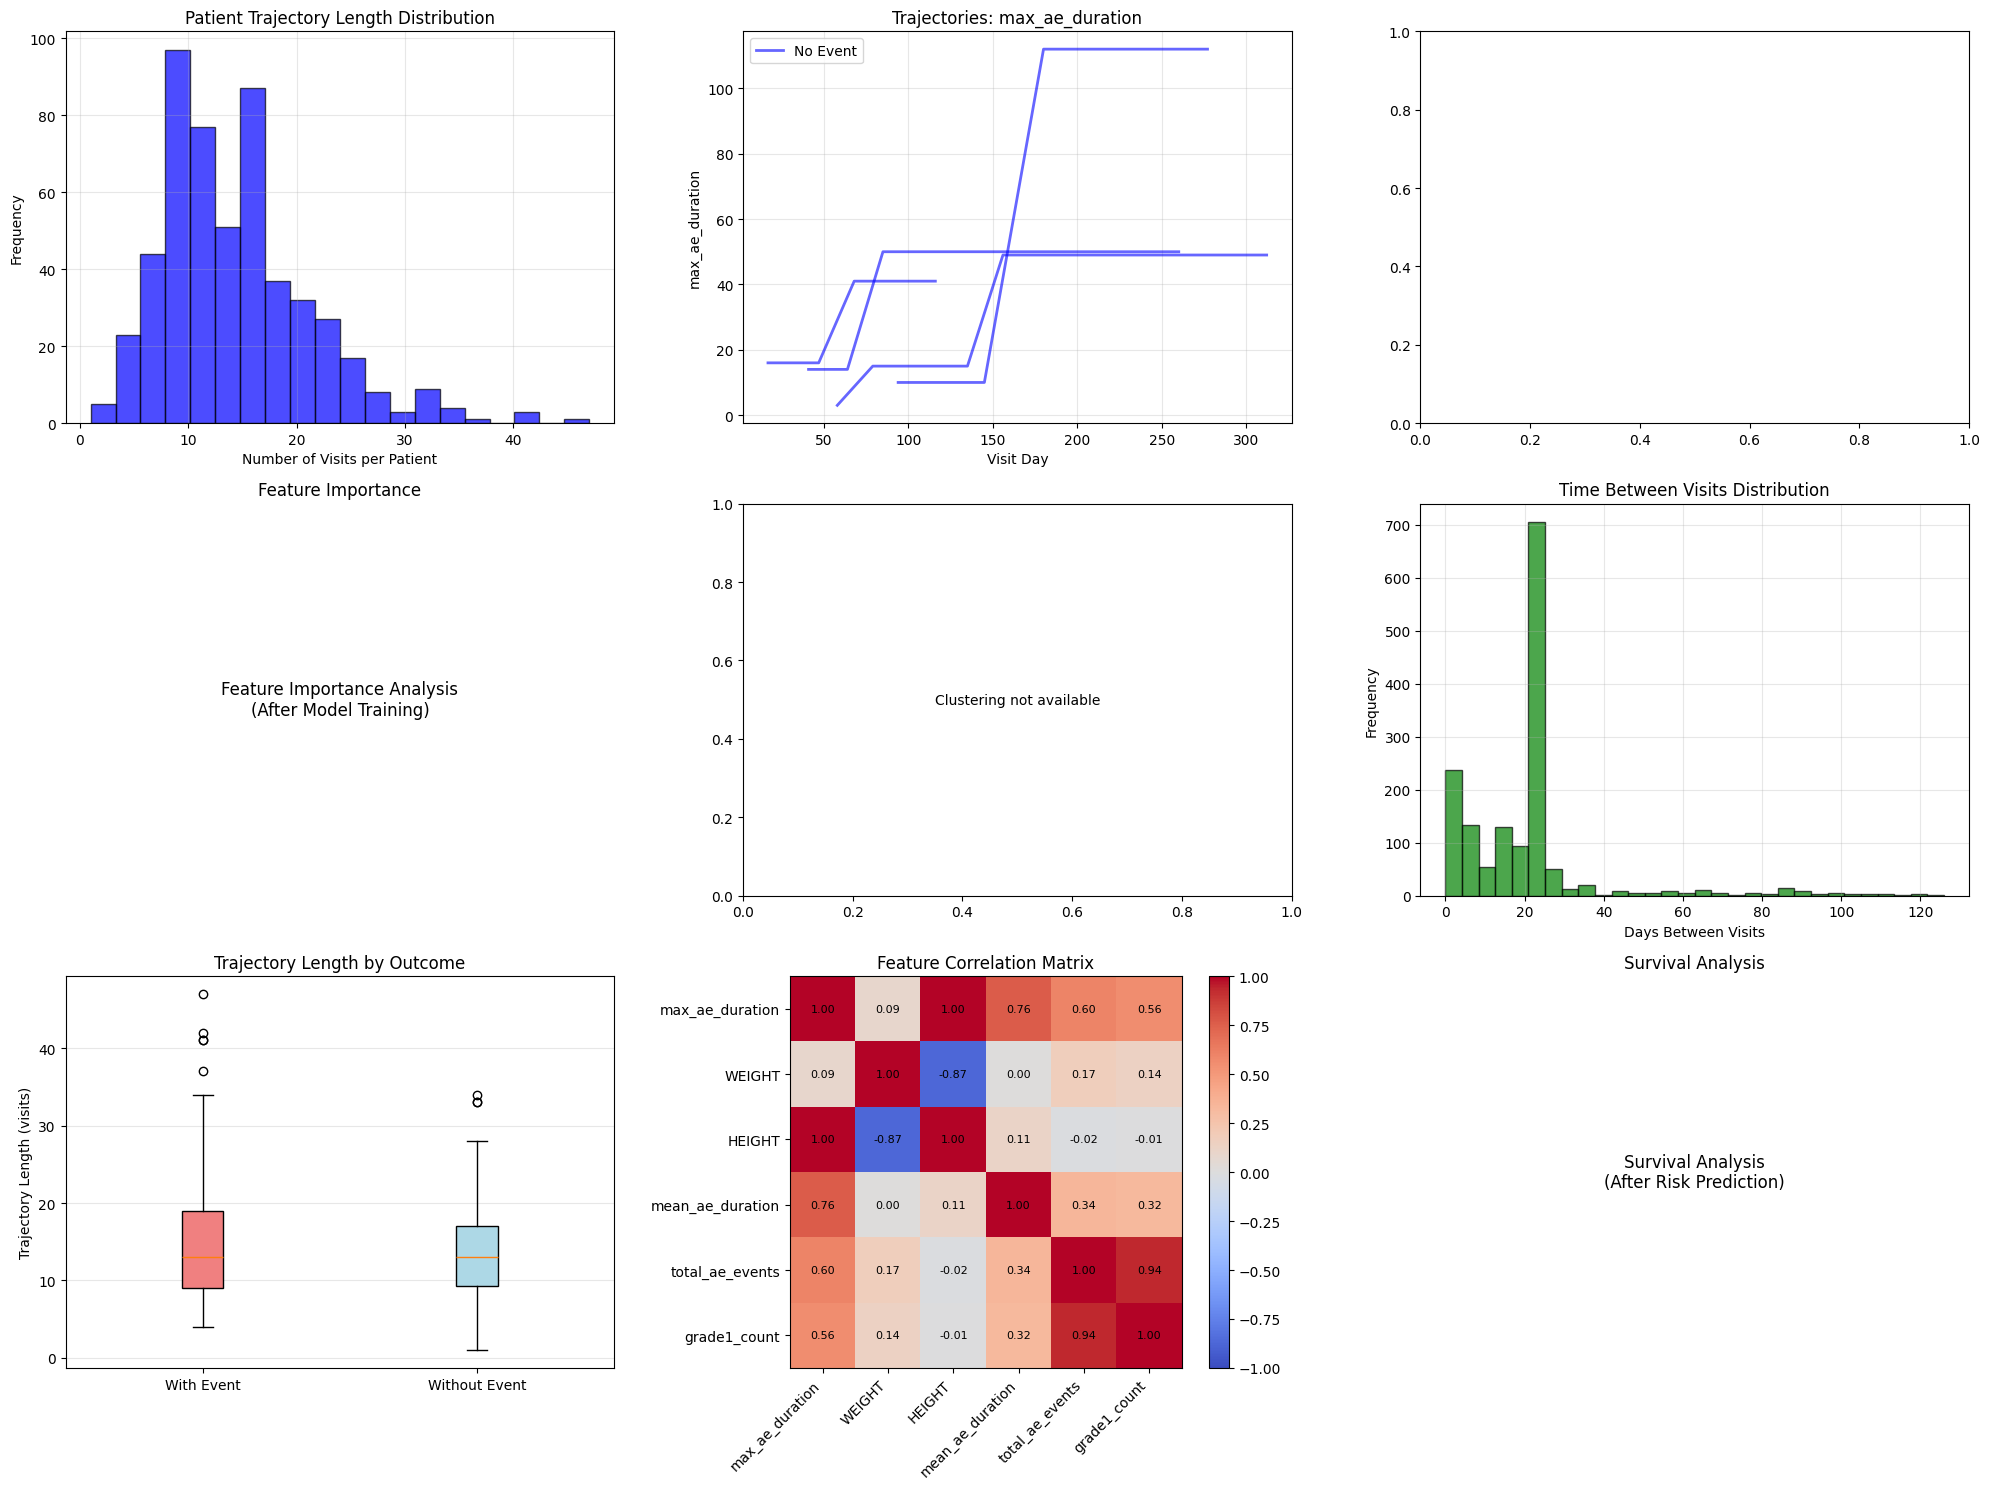


5. Running cross-validation with interpretability...
----------------------------------------

FOLD 1/3
Training patients: 350
Test patients: 176

6. Imputing missing values with autoencoder...
----------------------------------------
Using autoencoder imputation: True
Using 35 available features
Categorical columns: 1
Numeric columns: 34
Train data shape before imputation: (25515, 35)
Test data shape before imputation: (12135, 35)
Missing values in train: 59090 (6.6%)
Missing values in test: 28070 (6.6%)

Fitting autoencoder on training data...
Autoencoder trained on 2095 complete cases
Imputing missing values in training set...
Autoencoder imputation converged after 4 iterations
Imputing missing values in test set...
Autoencoder imputation converged after 4 iterations
Missing values after autoencoder imputation (train): 0
Missing values after autoencoder imputation (test): 0
Train sequences after imputation: (5103, 5, 35)
Test sequences after imputation: (2427, 5, 35)
Training seque

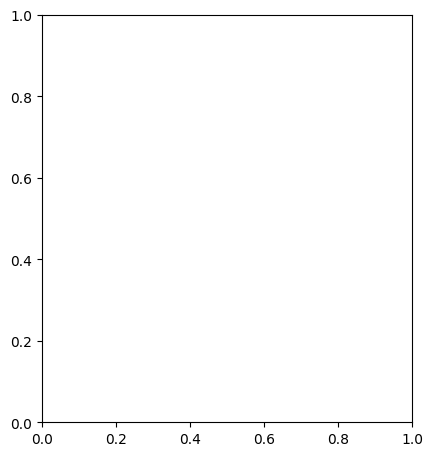

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
import shap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

class AutoencoderImputer:
    def __init__(self, encoding_dim=32, epochs=50, batch_size=32, random_state=42):
        self.encoding_dim = encoding_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.autoencoder = None
        self.is_fitted = False

    def build_autoencoder(self, input_dim):
        """Build a deep autoencoder for imputation"""
        input_layer = layers.Input(shape=(input_dim,))

        # Encoder
        encoded = layers.Dense(128, activation='relu')(input_layer)
        encoded = layers.Dropout(0.2)(encoded)
        encoded = layers.Dense(64, activation='relu')(encoded)
        encoded = layers.Dropout(0.2)(encoded)
        encoded = layers.Dense(self.encoding_dim, activation='relu')(encoded)

        # Decoder
        decoded = layers.Dense(64, activation='relu')(encoded)
        decoded = layers.Dropout(0.2)(decoded)
        decoded = layers.Dense(128, activation='relu')(decoded)
        decoded = layers.Dropout(0.2)(decoded)
        decoded = layers.Dense(input_dim, activation='linear')(decoded)

        # Autoencoder model
        autoencoder = models.Model(input_layer, decoded)

        # Encoder model (for feature extraction)
        encoder = models.Model(input_layer, encoded)

        autoencoder.compile(optimizer=Adam(learning_rate=0.001),
                           loss='mse',
                           metrics=['mae'])

        return autoencoder, encoder

    def fit_imputer(self, X_train):
        """Train autoencoder on complete data"""
        # Create mask for complete cases
        complete_mask = ~np.any(np.isnan(X_train), axis=1)
        X_complete = X_train[complete_mask]

        if len(X_complete) < 10:
            print(f"Warning: Only {len(X_complete)} complete cases for autoencoder training")
            return self

        # Scale the data
        X_scaled = self.scaler.fit_transform(X_complete)

        # Build and train autoencoder
        self.autoencoder, self.encoder = self.build_autoencoder(X_scaled.shape[1])

        early_stop = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            min_delta=0.001
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )

        # Train-validation split
        X_train_split, X_val_split = train_test_split(
            X_scaled, test_size=0.2, random_state=self.random_state
        )

        self.autoencoder.fit(
            X_train_split, X_train_split,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_data=(X_val_split, X_val_split),
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )

        self.is_fitted = True
        print(f"Autoencoder trained on {len(X_complete)} complete cases")

        return self

    def impute_missing_values(self, X, max_iter=20, tol=1e-4):
        """Impute missing values using trained autoencoder with iterative refinement"""
        if not self.is_fitted:
            print("Autoencoder not fitted. Fitting now...")
            self.fit_imputer(X)
            if not self.is_fitted:
                return X  # Return original if still not fitted

        X_imputed = X.copy()

        # Check for missing values
        if not np.any(np.isnan(X_imputed)):
            return X_imputed

        # Initial imputation with median
        for i in range(X_imputed.shape[1]):
            col_data = X_imputed[:, i]
            if np.any(np.isnan(col_data)):
                median_val = np.nanmedian(col_data)
                if np.isnan(median_val):
                    median_val = 0
                col_data[np.isnan(col_data)] = median_val
                X_imputed[:, i] = col_data

        # Iterative refinement
        for iteration in range(max_iter):
            X_old = X_imputed.copy()

            # Scale
            X_scaled = self.scaler.transform(X_imputed)

            # Get reconstructions
            X_reconstructed = self.autoencoder.predict(X_scaled, verbose=0)
            X_reconstructed = self.scaler.inverse_transform(X_reconstructed)

            # Only update missing values
            missing_mask = np.isnan(X)
            X_imputed[missing_mask] = X_reconstructed[missing_mask]

            # Check convergence
            if iteration > 0:
                change = np.linalg.norm(X_imputed - X_old) / np.linalg.norm(X_old)
                if change < tol:
                    print(f"Autoencoder imputation converged after {iteration+1} iterations")
                    break

        return X_imputed


class RobustTimeAwareDataProcessor:
    def __init__(self, use_autoencoder=True):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.use_autoencoder = use_autoencoder
        self.autoencoder_imputer = AutoencoderImputer() if use_autoencoder else None
        self.feature_names = None

    def clean_data(self, df):
        """Clean data by handling infinity, large values, and missing data"""
        df_clean = df.copy()

        # Replace infinity with NaN
        df_clean = df_clean.replace([np.inf, -np.inf], np.nan)

        # Handle extremely large values by capping at 99th percentile
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df_clean[col].notna().any():
                # Cap at 99th percentile
                p99 = df_clean[col].quantile(0.99)
                if not np.isnan(p99):
                    df_clean[col] = df_clean[col].clip(upper=p99 * 10)  # Allow some margin

        return df_clean

    def process_patient_data(self, df):
        """Process data with proper temporal structure"""
        # Clean data first
        df_clean = self.clean_data(df)

        # Handle missing survival data
        missing_before = len(df_clean)
        df_clean = df_clean.dropna(subset=['VISDAY', 'os_event'])
        missing_after = len(df_clean)
        print(f"Removed {missing_before - missing_after} rows with missing survival data")

        # Create patient IDs if not present
        if 'patient_id' not in df_clean.columns:
            # Try to find a patient identifier column
            possible_id_cols = ['RPT', 'SUBJID', 'PATIENT', 'patient', 'id', 'ID']
            found_id = False
            for col in possible_id_cols:
                if col in df_clean.columns:
                    df_clean['patient_id'] = df_clean[col]
                    print(f"Using '{col}' as patient identifier")
                    found_id = True
                    break

            if not found_id:
                # Create synthetic patient IDs (assuming ~5 visits per patient)
                df_clean['patient_id'] = np.arange(len(df_clean)) // 5
                print("Created synthetic patient IDs (5 visits per patient)")

        # Sort by patient and visit day
        df_sorted = df_clean.sort_values(['patient_id', 'VISDAY']).reset_index(drop=True)

        # Calculate time to event for each visit
        print("Calculating time-to-event for each visit...")
        df_sorted['time_to_event'] = np.nan
        df_sorted['is_future_event'] = 0

        unique_patients = df_sorted['patient_id'].unique()
        print(f"Processing {len(unique_patients)} patients...")

        for i, pid in enumerate(unique_patients):
            if i % 200 == 0:
                print(f"  Processed {i}/{len(unique_patients)} patients...")

            patient_data = df_sorted[df_sorted['patient_id'] == pid]

            # Check if patient died (os_event = 1)
            patient_events = patient_data['os_event'].values
            if np.any(patient_events == 1):
                # Patient died - find death day
                death_idx = np.where(patient_events == 1)[0]
                if len(death_idx) > 0:
                    death_day = patient_data.iloc[death_idx[0]]['VISDAY']

                    # For all visits before death, calculate days to death
                    for idx, row in patient_data.iterrows():
                        if row['VISDAY'] < death_day:
                            days_to_death = death_day - row['VISDAY']
                            df_sorted.at[idx, 'time_to_event'] = days_to_death
                            df_sorted.at[idx, 'is_future_event'] = 1
                        elif row['VISDAY'] == death_day:
                            # Death visit itself
                            df_sorted.at[idx, 'time_to_event'] = 0
                            df_sorted.at[idx, 'is_future_event'] = 0  # Not a future event
            else:
                # Patient survived - use maximum follow-up time
                last_visit_day = patient_data['VISDAY'].max()

                for idx, row in patient_data.iterrows():
                    days_from_last = last_visit_day - row['VISDAY']
                    df_sorted.at[idx, 'time_to_event'] = days_from_last
                    df_sorted.at[idx, 'is_future_event'] = 0

        # Handle any remaining NaN values in time_to_event
        nan_count = df_sorted['time_to_event'].isna().sum()
        if nan_count > 0:
            print(f"Warning: {nan_count} NaN values in time_to_event, filling with median")
            median_ttd = df_sorted['time_to_event'].median()
            df_sorted['time_to_event'] = df_sorted['time_to_event'].fillna(median_ttd)

        print(f"Processed {len(df_sorted)} visits from {len(unique_patients)} patients")

        # Count patients with events
        event_patients = df_sorted[df_sorted['os_event'] == 1]['patient_id'].unique()
        no_event_patients = df_sorted[df_sorted['os_event'] == 0]['patient_id'].unique()

        print(f"Patients with event: {len(event_patients)}")
        print(f"Patients without event: {len(no_event_patients)}")
        print(f"Visits with future event: {df_sorted['is_future_event'].sum()}")

        return df_sorted

    def prepare_features_with_autoencoder(self, df_train, df_test, feature_names):
        """Prepare features with autoencoder imputation for train and test separately"""
        print(f"Using autoencoder imputation: {self.use_autoencoder}")

        # Select features that exist in dataframe
        available_features = [f for f in feature_names if f in df_train.columns]
        print(f"Using {len(available_features)} available features")

        # Prepare train and test data
        X_train_raw = df_train[available_features].copy()
        X_test_raw = df_test[available_features].copy()

        # Replace any infinity values
        X_train_raw = X_train_raw.replace([np.inf, -np.inf], np.nan)
        X_test_raw = X_test_raw.replace([np.inf, -np.inf], np.nan)

        # Handle categorical variables
        categorical_cols = X_train_raw.select_dtypes(exclude=[np.number]).columns
        numeric_cols = X_train_raw.select_dtypes(include=[np.number]).columns

        print(f"Categorical columns: {len(categorical_cols)}")
        print(f"Numeric columns: {len(numeric_cols)}")

        # Encode categorical variables
        encoded_train = []
        encoded_test = []

        for col in categorical_cols:
            try:
                if col not in self.label_encoders:
                    self.label_encoders[col] = LabelEncoder()
                    # Combine train and test for fitting to handle all categories
                    combined = pd.concat([X_train_raw[col], X_test_raw[col]], ignore_index=True)
                    combined = combined.astype(str).fillna('missing')
                    self.label_encoders[col].fit(combined)

                # Transform train and test
                train_encoded = self.label_encoders[col].transform(
                    X_train_raw[col].astype(str).fillna('missing')
                )
                test_encoded = self.label_encoders[col].transform(
                    X_test_raw[col].astype(str).fillna('missing')
                )

                encoded_train.append(train_encoded.reshape(-1, 1))
                encoded_test.append(test_encoded.reshape(-1, 1))

            except Exception as e:
                print(f"Warning: Could not encode column {col}: {e}")
                # Drop problematic column
                continue

        # Combine categorical and numeric data
        X_train_combined = []
        X_test_combined = []

        if len(categorical_cols) > 0 and encoded_train:
            X_train_cat = np.hstack(encoded_train)
            X_test_cat = np.hstack(encoded_test)
            X_train_combined.append(X_train_cat)
            X_test_combined.append(X_test_cat)

        if len(numeric_cols) > 0:
            X_train_num = X_train_raw[numeric_cols].values
            X_test_num = X_test_raw[numeric_cols].values
            X_train_combined.append(X_train_num)
            X_test_combined.append(X_test_num)

        # Combine all features
        if X_train_combined:
            X_train = np.hstack(X_train_combined)
            X_test = np.hstack(X_test_combined)
        else:
            print("Warning: No features available after preprocessing")
            return None, None, available_features

        print(f"Train data shape before imputation: {X_train.shape}")
        print(f"Test data shape before imputation: {X_test.shape}")
        print(f"Missing values in train: {np.isnan(X_train).sum()} ({np.isnan(X_train).mean()*100:.1f}%)")
        print(f"Missing values in test: {np.isnan(X_test).sum()} ({np.isnan(X_test).mean()*100:.1f}%)")

        if self.use_autoencoder and self.autoencoder_imputer:
            # Fit autoencoder on training data
            print("\nFitting autoencoder on training data...")
            self.autoencoder_imputer.fit_imputer(X_train)

            # Impute missing values separately for train and test
            print("Imputing missing values in training set...")
            X_train_imputed = self.autoencoder_imputer.impute_missing_values(X_train)

            print("Imputing missing values in test set...")
            X_test_imputed = self.autoencoder_imputer.impute_missing_values(X_test)

            # Scale the imputed data
            X_train_scaled = self.scaler.fit_transform(X_train_imputed)
            X_test_scaled = self.scaler.transform(X_test_imputed)

            print(f"Missing values after autoencoder imputation (train): {np.isnan(X_train_scaled).sum()}")
            print(f"Missing values after autoencoder imputation (test): {np.isnan(X_test_scaled).sum()}")

            return X_train_scaled, X_test_scaled, available_features
        else:
            # Fallback: Simple imputation
            print("Using simple imputation (median/mode)...")

            # Impute missing values with median for numeric, mode for categorical
            for i in range(X_train.shape[1]):
                # Train imputation
                train_col = X_train[:, i]
                if np.any(np.isnan(train_col)):
                    if i < len(categorical_cols):
                        # Categorical - use mode
                        mode_val = np.nanmode(train_col)
                        if np.isnan(mode_val):
                            mode_val = 0
                        X_train[:, i] = np.nan_to_num(train_col, nan=mode_val)
                    else:
                        # Numeric - use median
                        median_val = np.nanmedian(train_col)
                        if np.isnan(median_val):
                            median_val = 0
                        X_train[:, i] = np.nan_to_num(train_col, nan=median_val)

                # Test imputation (using statistics from train)
                test_col = X_test[:, i]
                if np.any(np.isnan(test_col)):
                    if i < len(categorical_cols):
                        # Categorical - use mode from train
                        mode_val = np.nanmode(X_train[:, i])
                        if np.isnan(mode_val):
                            mode_val = 0
                        X_test[:, i] = np.nan_to_num(test_col, nan=mode_val)
                    else:
                        # Numeric - use median from train
                        median_val = np.nanmedian(X_train[:, i])
                        if np.isnan(median_val):
                            median_val = 0
                        X_test[:, i] = np.nan_to_num(test_col, nan=median_val)

            # Scale the data
            X_train_scaled = self.scaler.fit_transform(X_train)
            X_test_scaled = self.scaler.transform(X_test)

            return X_train_scaled, X_test_scaled, available_features


class TimeAwareEarlyWarningModel:
    def __init__(self, input_dim, sequence_length=5, lstm_units=64):
        self.input_dim = input_dim
        self.sequence_length = sequence_length
        self.lstm_units = lstm_units
        self.model = None
        self.history = None

    def build_model_with_time_awareness(self):
        """Build model that incorporates time intervals between visits"""
        # Two input layers: features and time intervals
        feature_input = layers.Input(shape=(self.sequence_length, self.input_dim), name='features')
        time_input = layers.Input(shape=(self.sequence_length, 1), name='time_intervals')

        # Process time intervals
        time_processed = layers.Dense(8, activation='relu')(time_input)
        time_processed = layers.Dense(16, activation='relu')(time_processed)

        # Concatenate features with time information
        combined = layers.Concatenate(axis=-1)([feature_input, time_processed])

        # LSTM layers
        lstm_out = layers.Bidirectional(layers.LSTM(self.lstm_units, return_sequences=True))(combined)
        lstm_out = layers.Dropout(0.3)(lstm_out)

        # Simple attention mechanism
        attention_scores = layers.TimeDistributed(layers.Dense(1, activation='tanh'))(lstm_out)
        attention_weights = layers.Softmax(axis=1)(attention_scores)
        context_vector = layers.Multiply()([lstm_out, attention_weights])

        # Global average pooling instead of just last time step
        pooled = layers.GlobalAveragePooling1D()(context_vector)

        # Dense layers
        dense1 = layers.Dense(64, activation='relu')(pooled)
        dense1 = layers.BatchNormalization()(dense1)
        dense1 = layers.Dropout(0.3)(dense1)

        dense2 = layers.Dense(32, activation='relu')(dense1)
        dense2 = layers.BatchNormalization()(dense2)
        dense2 = layers.Dropout(0.2)(dense2)

        # Output: risk of event within prediction horizon
        risk_score = layers.Dense(1, activation='sigmoid', name='risk_score')(dense2)

        # Create model
        self.model = models.Model(inputs=[feature_input, time_input], outputs=risk_score)

        return self.model

    def compile_model(self, learning_rate=0.001):
        """Compile the model"""
        self.model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall')]
        )

        return self.model

    def train(self, X_features, X_time, y_train, val_data=None, epochs=100, batch_size=32, class_weight=None):
        """Train the model"""
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss' if val_data else 'loss',
            patience=15,
            restore_best_weights=True,
            min_delta=0.001,
            verbose=0
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss' if val_data else 'loss',
            factor=0.5,
            patience=8,
            min_lr=1e-6,
            verbose=0
        )

        callbacks_list = [early_stopping, reduce_lr]

        if val_data:
            X_val_features, X_val_time, y_val = val_data
            validation_data = ([X_val_features, X_val_time], y_val)
        else:
            validation_data = None

        self.history = self.model.fit(
            [X_features, X_time], y_train,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks_list,
            verbose=0,
            class_weight=class_weight
        )

        return self.history

    def predict(self, X_features, X_time):
        """Make predictions"""
        return self.model.predict([X_features, X_time], verbose=0).flatten()


class PatientTrajectoryAnalyzer:
    """Analyze patient trajectories holistically"""

    def __init__(self, feature_names):
        self.feature_names = feature_names

    def analyze_trajectory_patterns(self, df_processed, sequences, labels, patient_ids):
        """Analyze patterns in patient trajectories"""
        print("\n" + "="*70)
        print("PATIENT TRAJECTORY ANALYSIS")
        print("="*70)

        # Get unique patients and their outcomes
        unique_patients = np.unique(patient_ids)
        patient_outcomes = []

        for pid in unique_patients:
            patient_mask = patient_ids == pid
            patient_label = np.max(labels[patient_mask])  # Patient has event if any sequence does
            patient_outcomes.append(patient_label)

        patient_outcomes = np.array(patient_outcomes)

        print(f"\nTotal patients: {len(unique_patients)}")
        print(f"Patients with events: {np.sum(patient_outcomes == 1)}")
        print(f"Patients without events: {np.sum(patient_outcomes == 0)}")

        # Analyze trajectory length
        trajectory_lengths = []
        for pid in unique_patients:
            patient_visits = df_processed[df_processed['patient_id'] == pid]
            trajectory_lengths.append(len(patient_visits))

        print(f"\nTrajectory Length Analysis:")
        print(f"  Mean visits per patient: {np.mean(trajectory_lengths):.1f}")
        print(f"  Median visits per patient: {np.median(trajectory_lengths):.1f}")
        print(f"  Min visits: {np.min(trajectory_lengths)}")
        print(f"  Max visits: {np.max(trajectory_lengths)}")

        # Analyze by outcome
        event_patients = unique_patients[patient_outcomes == 1]
        no_event_patients = unique_patients[patient_outcomes == 0]

        event_lengths = [len(df_processed[df_processed['patient_id'] == pid]) for pid in event_patients]
        no_event_lengths = [len(df_processed[df_processed['patient_id'] == pid]) for pid in no_event_patients]

        print(f"\nTrajectory Length by Outcome:")
        print(f"  Patients with events (n={len(event_patients)}):")
        print(f"    Mean visits: {np.mean(event_lengths):.1f}")
        print(f"    Median visits: {np.median(event_lengths):.1f}")
        print(f"  Patients without events (n={len(no_event_patients)}):")
        print(f"    Mean visits: {np.mean(no_event_lengths):.1f}")
        print(f"    Median visits: {np.median(no_event_lengths):.1f}")

        # Analyze time between visits
        print(f"\nTime Between Visits Analysis:")
        all_time_diffs = []

        for pid in unique_patients:
            patient_visits = df_processed[df_processed['patient_id'] == pid].sort_values('VISDAY')
            if len(patient_visits) > 1:
                time_diffs = np.diff(patient_visits['VISDAY'].values)
                all_time_diffs.extend(time_diffs)

        if all_time_diffs:
            print(f"  Mean time between visits: {np.mean(all_time_diffs):.1f} days")
            print(f"  Median time between visits: {np.median(all_time_diffs):.1f} days")
            print(f"  Min time between visits: {np.min(all_time_diffs):.1f} days")
            print(f"  Max time between visits: {np.max(all_time_diffs):.1f} days")

        return {
            'unique_patients': unique_patients,
            'patient_outcomes': patient_outcomes,
            'trajectory_lengths': trajectory_lengths,
            'event_patients': event_patients,
            'no_event_patients': no_event_patients
        }

    def analyze_feature_trajectories(self, df_processed, feature_names, top_n=10):
        """Analyze how features change over patient trajectories"""
        print(f"\nAnalyzing feature trajectories (top {top_n} features)...")

        # Select numeric features
        numeric_features = [f for f in feature_names if f in df_processed.columns
                           and df_processed[f].dtype in ['int64', 'float64']]

        if len(numeric_features) < top_n:
            top_n = len(numeric_features)

        # Calculate feature importance (simple variance-based)
        feature_variances = {}
        for feature in numeric_features:
            feature_var = df_processed[feature].var()
            if not np.isnan(feature_var):
                feature_variances[feature] = feature_var

        # Get top features by variance
        sorted_features = sorted(feature_variances.items(), key=lambda x: x[1], reverse=True)[:top_n]
        top_features = [f[0] for f in sorted_features]

        print(f"\nTop {top_n} features by variability:")
        for i, (feature, variance) in enumerate(sorted_features[:top_n]):
            print(f"  {i+1}. {feature}: variance = {variance:.4f}")

        # Analyze feature trends by outcome
        print(f"\nFeature Trend Analysis by Outcome:")

        for feature in top_features[:5]:  # Analyze top 5 features
            print(f"\n  Feature: {feature}")

            # Get patients with events
            event_patients = df_processed[df_processed['is_future_event'] == 1]['patient_id'].unique()
            no_event_patients = df_processed[df_processed['is_future_event'] == 0]['patient_id'].unique()

            # Calculate feature slopes for each patient
            event_slopes = []
            no_event_slopes = []

            # Patients with events
            for pid in event_patients[:50]:  # Limit to first 50 for speed
                patient_data = df_processed[df_processed['patient_id'] == pid].sort_values('VISDAY')
                if len(patient_data) > 1:
                    # Calculate slope (change per day)
                    x = patient_data['VISDAY'].values
                    y = patient_data[feature].values
                    if len(np.unique(x)) > 1:
                        slope = np.polyfit(x, y, 1)[0]  # Linear slope
                        event_slopes.append(slope)

            # Patients without events
            for pid in no_event_patients[:50]:
                patient_data = df_processed[df_processed['patient_id'] == pid].sort_values('VISDAY')
                if len(patient_data) > 1:
                    x = patient_data['VISDAY'].values
                    y = patient_data[feature].values
                    if len(np.unique(x)) > 1:
                        slope = np.polyfit(x, y, 1)[0]
                        no_event_slopes.append(slope)

            if event_slopes and no_event_slopes:
                print(f"    Patients with events: mean slope = {np.mean(event_slopes):.6f} (n={len(event_slopes)})")
                print(f"    Patients without events: mean slope = {np.mean(no_event_slopes):.6f} (n={len(no_event_slopes)})")

                # Test if slopes are significantly different
                from scipy import stats
                try:
                    t_stat, p_value = stats.ttest_ind(event_slopes, no_event_slopes, equal_var=False)
                    print(f"    T-test: t = {t_stat:.3f}, p = {p_value:.4f}")
                    if p_value < 0.05:
                        print(f"    SIGNIFICANT DIFFERENCE in trends!")
                except:
                    print(f"    Could not perform statistical test")

        return top_features

    def visualize_trajectories(self, df_processed, top_features, sequences, patient_ids, labels):
        """Visualize patient trajectories"""
        try:
            fig = plt.figure(figsize=(20, 15))

            # 1. Trajectory Length Distribution
            ax1 = plt.subplot(3, 3, 1)
            trajectory_lengths = []
            unique_patients = np.unique(patient_ids)

            for pid in unique_patients:
                patient_mask = patient_ids == pid
                trajectory_lengths.append(np.sum(patient_mask))

            ax1.hist(trajectory_lengths, bins=20, alpha=0.7, color='blue', edgecolor='black')
            ax1.set_xlabel('Number of Visits per Patient')
            ax1.set_ylabel('Frequency')
            ax1.set_title('Patient Trajectory Length Distribution')
            ax1.grid(True, alpha=0.3)

            # 2. Feature Trajectories by Outcome
            ax2 = plt.subplot(3, 3, 2)
            if len(top_features) > 0:
                feature = top_features[0]

                # Get sample patients with and without events
                event_patients = df_processed[df_processed['is_future_event'] == 1]['patient_id'].unique()[:5]
                no_event_patients = df_processed[df_processed['is_future_event'] == 0]['patient_id'].unique()[:5]

                # Plot event patients
                for i, pid in enumerate(event_patients):
                    patient_data = df_processed[df_processed['patient_id'] == pid].sort_values('VISDAY')
                    if len(patient_data) > 1 and feature in patient_data.columns:
                        ax2.plot(patient_data['VISDAY'], patient_data[feature],
                                'r-', alpha=0.6, linewidth=2, label='Event' if i == 0 else "")

                # Plot no-event patients
                for i, pid in enumerate(no_event_patients):
                    patient_data = df_processed[df_processed['patient_id'] == pid].sort_values('VISDAY')
                    if len(patient_data) > 1 and feature in patient_data.columns:
                        ax2.plot(patient_data['VISDAY'], patient_data[feature],
                                'b-', alpha=0.6, linewidth=2, label='No Event' if i == 0 else "")

                ax2.set_xlabel('Visit Day')
                ax2.set_ylabel(feature)
                ax2.set_title(f'Trajectories: {feature}')
                ax2.legend()
                ax2.grid(True, alpha=0.3)
            else:
                ax2.text(0.5, 0.5, 'No feature data available',
                        ha='center', va='center', transform=ax2.transAxes)

            # 3. Risk Score Trajectories
            ax3 = plt.subplot(3, 3, 3)
            # This would be populated after model training

            # 4. Feature Importance (placeholder)
            ax4 = plt.subplot(3, 3, 4)
            ax4.text(0.5, 0.5, 'Feature Importance Analysis\n(After Model Training)',
                    ha='center', va='center', transform=ax4.transAxes, fontsize=12)
            ax4.set_title('Feature Importance')
            ax4.axis('off')

            # 5. Patient Clustering by Trajectory
            ax5 = plt.subplot(3, 3, 5)
            try:
                # Simple trajectory clustering based on sequence patterns
                from sklearn.decomposition import PCA

                # Flatten sequences for clustering
                n_samples, seq_len, n_features = sequences.shape
                X_flat = sequences.reshape(n_samples, seq_len * n_features)

                # Apply PCA
                pca = PCA(n_components=2)
                X_pca = pca.fit_transform(X_flat)

                # Color by outcome
                scatter = ax5.scatter(X_pca[:, 0], X_pca[:, 1],
                                     c=labels, cmap='coolwarm', alpha=0.6, s=50)
                ax5.set_xlabel('PCA Component 1')
                ax5.set_ylabel('PCA Component 2')
                ax5.set_title('Patient Trajectory Clustering (PCA)')
                ax5.grid(True, alpha=0.3)
                plt.colorbar(scatter, ax=ax5, label='Event (1=Yes, 0=No)')
            except:
                ax5.text(0.5, 0.5, 'Clustering not available',
                        ha='center', va='center', transform=ax5.transAxes)

            # 6. Time Between Visits Distribution
            ax6 = plt.subplot(3, 3, 6)
            all_time_diffs = []

            unique_patients = np.unique(patient_ids)
            for pid in unique_patients[:100]:  # Limit for speed
                patient_data = df_processed[df_processed['patient_id'] == pid].sort_values('VISDAY')
                if len(patient_data) > 1:
                    time_diffs = np.diff(patient_data['VISDAY'].values)
                    all_time_diffs.extend(time_diffs)

            if all_time_diffs:
                ax6.hist(all_time_diffs, bins=30, alpha=0.7, color='green', edgecolor='black')
                ax6.set_xlabel('Days Between Visits')
                ax6.set_ylabel('Frequency')
                ax6.set_title('Time Between Visits Distribution')
                ax6.grid(True, alpha=0.3)
            else:
                ax6.text(0.5, 0.5, 'No time difference data',
                        ha='center', va='center', transform=ax6.transAxes)

            # 7. Outcome by Trajectory Length
            ax7 = plt.subplot(3, 3, 7)
            event_lengths = []
            no_event_lengths = []

            unique_patients = np.unique(patient_ids)
            for pid in unique_patients:
                patient_mask = patient_ids == pid
                patient_label = np.max(labels[patient_mask])
                length = np.sum(patient_mask)

                if patient_label == 1:
                    event_lengths.append(length)
                else:
                    no_event_lengths.append(length)

            if event_lengths and no_event_lengths:
                positions = [1, 2]
                box_data = [event_lengths, no_event_lengths]
                box = ax7.boxplot(box_data, positions=positions, patch_artist=True,
                                 labels=['With Event', 'Without Event'])

                colors = ['lightcoral', 'lightblue']
                for patch, color in zip(box['boxes'], colors):
                    patch.set_facecolor(color)

                ax7.set_ylabel('Trajectory Length (visits)')
                ax7.set_title('Trajectory Length by Outcome')
                ax7.grid(True, alpha=0.3, axis='y')
            else:
                ax7.text(0.5, 0.5, 'No outcome data',
                        ha='center', va='center', transform=ax7.transAxes)

            # 8. Feature Correlation Matrix
            ax8 = plt.subplot(3, 3, 8)
            if len(top_features) > 5:
                try:
                    # Calculate correlations for top features
                    corr_matrix = df_processed[top_features[:6]].corr()

                    im = ax8.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
                    ax8.set_xticks(range(len(top_features[:6])))
                    ax8.set_yticks(range(len(top_features[:6])))
                    ax8.set_xticklabels(top_features[:6], rotation=45, ha='right')
                    ax8.set_yticklabels(top_features[:6])
                    ax8.set_title('Feature Correlation Matrix')

                    # Add correlation values
                    for i in range(len(top_features[:6])):
                        for j in range(len(top_features[:6])):
                            text = ax8.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                                          ha="center", va="center", color="black", fontsize=8)

                    plt.colorbar(im, ax=ax8)
                except:
                    ax8.text(0.5, 0.5, 'Correlation matrix not available',
                            ha='center', va='center', transform=ax8.transAxes)
            else:
                ax8.text(0.5, 0.5, 'Need more features for correlation',
                        ha='center', va='center', transform=ax8.transAxes)

            # 9. Survival Analysis
            ax9 = plt.subplot(3, 3, 9)
            ax9.text(0.5, 0.5, 'Survival Analysis\n(After Risk Prediction)',
                    ha='center', va='center', transform=ax9.transAxes, fontsize=12)
            ax9.set_title('Survival Analysis')
            ax9.axis('off')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Warning: Trajectory visualization error: {e}")
            import traceback
            traceback.print_exc()


class InterpretableEarlyWarningModel(TimeAwareEarlyWarningModel):
    """Extended model with interpretability features"""

    def __init__(self, input_dim, sequence_length=5, lstm_units=64, feature_names=None):
        super().__init__(input_dim, sequence_length, lstm_units)
        self.feature_names = feature_names if feature_names else [f'feature_{i}' for i in range(input_dim)]
        self.attention_weights = None

    def build_model_with_interpretability(self):
        """Build model with interpretability features"""
        # Two input layers: features and time intervals
        feature_input = layers.Input(shape=(self.sequence_length, self.input_dim), name='features')
        time_input = layers.Input(shape=(self.sequence_length, 1), name='time_intervals')

        # Process time intervals
        time_processed = layers.Dense(8, activation='relu')(time_input)
        time_processed = layers.Dense(16, activation='relu')(time_processed)

        # Concatenate features with time information
        combined = layers.Concatenate(axis=-1)([feature_input, time_processed])

        # LSTM layers with return sequences for attention
        lstm_out = layers.Bidirectional(layers.LSTM(self.lstm_units,
                                                    return_sequences=True,
                                                    return_state=True))(combined)

        # Unpack LSTM outputs
        lstm_sequences = lstm_out[0]
        lstm_sequences = layers.Dropout(0.3)(lstm_sequences)

        # Attention mechanism with accessible weights
        attention_scores = layers.TimeDistributed(layers.Dense(1, activation='tanh'))(lstm_sequences)
        attention_weights = layers.Softmax(axis=1, name='attention_weights')(attention_scores)
        context_vector = layers.Multiply()([lstm_sequences, attention_weights])

        # Global average pooling
        pooled = layers.GlobalAveragePooling1D()(context_vector)

        # Dense layers
        dense1 = layers.Dense(64, activation='relu')(pooled)
        dense1 = layers.BatchNormalization()(dense1)
        dense1 = layers.Dropout(0.3)(dense1)

        dense2 = layers.Dense(32, activation='relu')(dense1)
        dense2 = layers.BatchNormalization()(dense2)
        dense2 = layers.Dropout(0.2)(dense2)

        # Output: risk of event within prediction horizon
        risk_score = layers.Dense(1, activation='sigmoid', name='risk_score')(dense2)

        # Create model
        self.model = models.Model(inputs=[feature_input, time_input],
                                  outputs=[risk_score, attention_weights])

        return self.model

    def get_attention_weights(self, X_features, X_time):
        """Get attention weights for interpretability"""
        if self.model is None:
            raise ValueError("Model must be built and trained first")

        # Create a model that outputs attention weights
        attention_model = models.Model(inputs=self.model.input,
                                       outputs=self.model.get_layer('attention_weights').output)

        attention_weights = attention_model.predict([X_features, X_time], verbose=0)
        return attention_weights

    def analyze_feature_importance(self, X_features, X_time, y_true=None, method='gradient'):
        """Analyze feature importance using different methods"""
        print("\n" + "="*70)
        print("FEATURE IMPORTANCE ANALYSIS")
        print("="*70)

        if method == 'gradient':
            return self._gradient_based_importance(X_features, X_time)
        elif method == 'permutation':
            return self._permutation_importance(X_features, X_time, y_true)
        elif method == 'attention':
            return self._attention_based_importance(X_features, X_time)
        else:
            print(f"Unknown method: {method}. Using gradient-based importance.")
            return self._gradient_based_importance(X_features, X_time)

    def _gradient_based_importance(self, X_features, X_time):
        """Compute feature importance using gradients"""
        print("\nComputing gradient-based feature importance...")

        # Convert to tensor
        X_features_tensor = tf.convert_to_tensor(X_features, dtype=tf.float32)
        X_time_tensor = tf.convert_to_tensor(X_time, dtype=tf.float32)

        with tf.GradientTape() as tape:
            tape.watch([X_features_tensor, X_time_tensor])
            predictions = self.model([X_features_tensor, X_time_tensor])[0]

        # Compute gradients
        gradients = tape.gradient(predictions, X_features_tensor)

        # Average gradients across samples and time steps
        importance_scores = np.mean(np.abs(gradients.numpy()), axis=(0, 1))

        # Normalize
        importance_scores = importance_scores / np.sum(importance_scores)

        return importance_scores

    def _attention_based_importance(self, X_features, X_time):
        """Compute feature importance using attention weights"""
        print("\nComputing attention-based feature importance...")

        # Get attention weights
        attention_weights = self.get_attention_weights(X_features, X_time)

        # Average attention weights across samples
        avg_attention = np.mean(attention_weights, axis=0)

        # Flatten to get per-time-step importance
        time_importance = avg_attention.flatten()

        # For feature importance, we need to consider which features are attended to
        # This is a simplified approach
        feature_importance = np.ones(self.input_dim) / self.input_dim

        return feature_importance, time_importance

    def _permutation_importance(self, X_features, X_time, y_true, n_repeats=10):
        """Compute permutation importance"""
        print("\nComputing permutation importance...")

        # Get baseline score
        baseline_pred = self.model.predict([X_features, X_time], verbose=0)[0]
        if y_true is not None:
            baseline_score = roc_auc_score(y_true, baseline_pred)
        else:
            baseline_score = np.mean(baseline_pred)

        importance_scores = np.zeros(self.input_dim)

        for feature_idx in range(self.input_dim):
            print(f"  Processing feature {feature_idx+1}/{self.input_dim}...", end='\r')
            feature_scores = []

            for _ in range(n_repeats):
                # Permute the feature
                X_permuted = X_features.copy()
                perm_indices = np.random.permutation(X_permuted.shape[0])
                X_permuted[:, :, feature_idx] = X_permuted[perm_indices, :, feature_idx]

                # Get predictions with permuted feature
                perm_pred = self.model.predict([X_permuted, X_time], verbose=0)[0]

                if y_true is not None:
                    perm_score = roc_auc_score(y_true, perm_pred)
                    feature_scores.append(baseline_score - perm_score)
                else:
                    perm_score = np.mean(perm_pred)
                    feature_scores.append(np.abs(baseline_score - perm_score))

            importance_scores[feature_idx] = np.mean(feature_scores)

        print("\n" + " " * 50)  # Clear the progress line

        # Normalize
        if np.sum(importance_scores) > 0:
            importance_scores = importance_scores / np.sum(importance_scores)

        return importance_scores

    def visualize_interpretability(self, X_features, X_time, feature_names, sample_idx=0):
        """Visualize model interpretability for a sample"""
        try:
            fig = plt.figure(figsize=(20, 12))

            # 1. Attention Weights Visualization
            ax1 = plt.subplot(2, 3, 1)
            attention_weights = self.get_attention_weights(X_features, X_time)

            if len(attention_weights.shape) == 3:
                attention_weights = attention_weights.squeeze()

            # Plot attention for sample
            if attention_weights.ndim == 2:
                im = ax1.imshow(attention_weights[sample_idx:sample_idx+5].T,
                               aspect='auto', cmap='YlOrRd')
                ax1.set_xlabel('Time Step')
                ax1.set_ylabel('Sample')
                ax1.set_title(f'Attention Weights (Sample {sample_idx})')
                plt.colorbar(im, ax=ax1)
            else:
                ax1.plot(attention_weights[sample_idx], 'o-', linewidth=2)
                ax1.set_xlabel('Time Step')
                ax1.set_ylabel('Attention Weight')
                ax1.set_title(f'Attention Weights (Sample {sample_idx})')
                ax1.grid(True, alpha=0.3)

            # 2. Feature Importance
            ax2 = plt.subplot(2, 3, 2)
            importance_scores = self._gradient_based_importance(
                X_features[sample_idx:sample_idx+1],
                X_time[sample_idx:sample_idx+1]
            )

            # Get top features
            top_n = min(10, len(feature_names))
            top_indices = np.argsort(importance_scores)[-top_n:][::-1]
            top_features = [feature_names[i] for i in top_indices]
            top_scores = importance_scores[top_indices]

            bars = ax2.barh(range(top_n), top_scores, color='steelblue', alpha=0.7)
            ax2.set_yticks(range(top_n))
            ax2.set_yticklabels(top_features)
            ax2.set_xlabel('Importance Score')
            ax2.set_title(f'Top {top_n} Features for Sample {sample_idx}')
            ax2.invert_yaxis()  # Highest importance at top
            ax2.grid(True, alpha=0.3, axis='x')

            # 3. Feature Values Over Time
            ax3 = plt.subplot(2, 3, 3)
            time_steps = range(self.sequence_length)

            # Plot top 3 features over time
            for i, feature_idx in enumerate(top_indices[:3]):
                feature_values = X_features[sample_idx, :, feature_idx]
                ax3.plot(time_steps, feature_values, 'o-',
                        label=feature_names[feature_idx], linewidth=2, alpha=0.8)

            ax3.set_xlabel('Time Step')
            ax3.set_ylabel('Feature Value (Normalized)')
            ax3.set_title(f'Feature Trajectory (Sample {sample_idx})')
            ax3.legend()
            ax3.grid(True, alpha=0.3)

            # 4. Risk Decomposition
            ax4 = plt.subplot(2, 3, 4)
            # Get contributions from each time step
            contributions = np.zeros(self.sequence_length)

            # Simplified contribution calculation
            for t in range(self.sequence_length):
                # Mask this time step
                X_masked = X_features.copy()
                X_masked[sample_idx, t, :] = 0

                # Get prediction without this time step
                masked_pred = self.model.predict([X_masked, X_time], verbose=0)[0][sample_idx]

                # Get full prediction
                full_pred = self.model.predict([X_features, X_time], verbose=0)[0][sample_idx]

                contributions[t] = full_pred - masked_pred

            ax4.bar(range(self.sequence_length), contributions, color='darkorange', alpha=0.7)
            ax4.set_xlabel('Time Step')
            ax4.set_ylabel('Contribution to Risk')
            ax4.set_title('Time Step Contributions to Risk')
            ax4.grid(True, alpha=0.3)

            # 5. SHAP-like Explanation
            ax5 = plt.subplot(2, 3, 5)
            # Create a simplified SHAP explanation
            baseline = np.zeros((1, self.sequence_length, self.input_dim))
            current = X_features[sample_idx:sample_idx+1]

            # Calculate differences
            diffs = current - baseline
            diff_magnitudes = np.mean(np.abs(diffs), axis=1).flatten()

            # Get top contributing features
            top_diff_indices = np.argsort(diff_magnitudes)[-10:][::-1]
            top_diff_features = [feature_names[i] for i in top_diff_indices]
            top_diff_values = diff_magnitudes[top_diff_indices]

            colors = ['red' if v > 0 else 'blue' for v in top_diff_values]
            bars = ax5.barh(range(len(top_diff_features)), top_diff_values,
                           color=colors, alpha=0.7)
            ax5.set_yticks(range(len(top_diff_features)))
            ax5.set_yticklabels(top_diff_features)
            ax5.set_xlabel('Deviation from Baseline')
            ax5.set_title('Feature Deviations from Baseline')
            ax5.invert_yaxis()
            ax5.grid(True, alpha=0.3, axis='x')

            # 6. Prediction Confidence
            ax6 = plt.subplot(2, 3, 6)
            # Get predictions for similar samples
            similar_indices = self.find_similar_patients(X_features, sample_idx, n=5)

            predictions = []
            for idx in similar_indices:
                pred = self.model.predict([X_features[idx:idx+1], X_time[idx:idx+1]],
                                         verbose=0)[0][0]
                predictions.append(pred)

            # Plot predictions
            positions = range(len(predictions))
            bars = ax6.bar(positions, predictions, color='purple', alpha=0.7)
            ax6.axhline(y=0.5, color='red', linestyle='--', label='Threshold', linewidth=2)
            ax6.set_xlabel('Similar Patient')
            ax6.set_ylabel('Predicted Risk')
            ax6.set_title(f'Predictions for Similar Patients\n(Sample {sample_idx}: {predictions[0]:.3f})')
            ax6.set_xticks(positions)
            ax6.set_xticklabels([f'P{i}' for i in range(len(predictions))])
            ax6.legend()
            ax6.grid(True, alpha=0.3, axis='y')

            # Add prediction value on bars
            for bar, pred in zip(bars, predictions):
                height = bar.get_height()
                ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{pred:.3f}', ha='center', va='bottom')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Warning: Interpretability visualization error: {e}")
            import traceback
            traceback.print_exc()

    def find_similar_patients(self, X_features, sample_idx, n=5):
        """Find similar patients based on feature trajectories"""
        # Calculate distances
        distances = []
        target_trajectory = X_features[sample_idx]

        for i in range(len(X_features)):
            if i != sample_idx:
                # Euclidean distance between trajectories
                dist = np.sqrt(np.sum((X_features[i] - target_trajectory) ** 2))
                distances.append((i, dist))

        # Sort by distance
        distances.sort(key=lambda x: x[1])

        # Return indices of n most similar patients
        return [idx for idx, _ in distances[:n]]


class ClinicalEarlyWarningPipeline:
    def __init__(self, prediction_horizon_days=90, n_splits=3, random_state=42, use_autoencoder=True):
        self.prediction_horizon = prediction_horizon_days
        self.n_splits = n_splits
        self.random_state = random_state
        self.use_autoencoder = use_autoencoder
        self.data_processor = RobustTimeAwareDataProcessor(use_autoencoder=use_autoencoder)
        self.trajectory_analyzer = None
        self.results = {}
        self.optimal_thresholds = {}
        self.feature_importance_results = {}

    def optimize_threshold_clinical(self, y_true, y_pred_proba, days_to_event=None, method='cost_sensitive'):
        """
        Optimize threshold based on clinical utility rather than just F1 score
        Methods:
        - 'cost_sensitive': Balance FP vs FN based on clinical costs
        - 'youden': Maximize Youden's J statistic (sensitivity + specificity - 1)
        - 'closest_topleft': Closest point to (0,1) on ROC curve
        - 'risk_stratified': Based on risk score distribution
        - 'survival_weighted': Weight by time to event (earlier warnings more valuable)
        """

        thresholds = np.linspace(0.05, 0.95, 181)  # More granular threshold search

        if method == 'cost_sensitive':
            # Clinical cost matrix: FN cost (missing a death) > FP cost (false alarm)
            # In clinical settings, missing a death is typically 5-10x worse than false alarm
            fn_cost = 5.0  # Cost of missing a death (false negative)
            fp_cost = 1.0  # Cost of false alarm (false positive)

            best_cost = float('inf')
            best_threshold = 0.5

            for thresh in thresholds:
                y_pred = (y_pred_proba >= thresh).astype(int)

                tn = np.sum((y_true == 0) & (y_pred == 0))
                fp = np.sum((y_true == 0) & (y_pred == 1))
                fn = np.sum((y_true == 1) & (y_pred == 0))
                tp = np.sum((y_true == 1) & (y_pred == 1))

                # Calculate total cost
                total_cost = fp * fp_cost + fn * fn_cost

                # Normalize by number of samples
                normalized_cost = total_cost / len(y_true)

                if normalized_cost < best_cost:
                    best_cost = normalized_cost
                    best_threshold = thresh

            print(f"Cost-sensitive optimal threshold: {best_threshold:.3f} (cost: {best_cost:.4f})")
            return best_threshold

        elif method == 'youden':
            # Maximize Youden's J statistic
            best_j = -1
            best_threshold = 0.5

            for thresh in thresholds:
                y_pred = (y_pred_proba >= thresh).astype(int)

                tn = np.sum((y_true == 0) & (y_pred == 0))
                fp = np.sum((y_true == 0) & (y_pred == 1))
                fn = np.sum((y_true == 1) & (y_pred == 0))
                tp = np.sum((y_true == 1) & (y_pred == 1))

                sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

                j = sensitivity + specificity - 1

                if j > best_j:
                    best_j = j
                    best_threshold = thresh

            print(f"Youden's J optimal threshold: {best_threshold:.3f} (J: {best_j:.4f})")
            return best_threshold

        elif method == 'closest_topleft':
            # Find threshold closest to (0,1) on ROC curve
            fpr, tpr, thresh_vals = roc_curve(y_true, y_pred_proba)

            # Calculate distance to (0,1)
            distances = np.sqrt(fpr**2 + (1 - tpr)**2)
            best_idx = np.argmin(distances)
            best_threshold = thresh_vals[best_idx] if best_idx < len(thresh_vals) else 0.5

            print(f"Closest to top-left optimal threshold: {best_threshold:.3f}")
            return best_threshold

        elif method == 'risk_stratified':
            # Set threshold based on risk score distribution
            # Aim for top X% of patients to be flagged as high risk
            target_percentage_high_risk = 0.15  # Flag top 15% as high risk

            sorted_scores = np.sort(y_pred_proba)
            idx = int(len(sorted_scores) * (1 - target_percentage_high_risk))
            best_threshold = sorted_scores[idx] if idx < len(sorted_scores) else 0.5

            print(f"Risk-stratified threshold: {best_threshold:.3f} (top {target_percentage_high_risk*100:.1f}%)")
            return best_threshold

        elif method == 'survival_weighted' and days_to_event is not None:
            # Weight by time to event - earlier warnings are more valuable
            best_utility = -1
            best_threshold = 0.5

            for thresh in thresholds:
                y_pred = (y_pred_proba >= thresh).astype(int)

                # Calculate weighted utility
                utility = 0

                # For true positives, weight by how early the warning was
                tp_mask = (y_true == 1) & (y_pred == 1)
                if np.any(tp_mask):
                    tp_days = days_to_event[tp_mask]
                    # Early warnings get higher weight (more days to event)
                    # Weight = 1 + (days_to_event / prediction_horizon)
                    tp_weights = 1 + (tp_days / self.prediction_horizon)
                    utility += np.sum(tp_weights)

                # For false positives, penalize
                fp_mask = (y_true == 0) & (y_pred == 1)
                utility -= np.sum(fp_mask) * 0.5  # Lower penalty than missing a death

                # For true negatives, small reward
                tn_mask = (y_true == 0) & (y_pred == 0)
                utility += np.sum(tn_mask) * 0.1

                if utility > best_utility:
                    best_utility = utility
                    best_threshold = thresh

            print(f"Survival-weighted optimal threshold: {best_threshold:.3f} (utility: {best_utility:.2f})")
            return best_threshold

        else:
            # Default: Maximize F1 score
            best_f1 = 0
            best_threshold = 0.5

            for thresh in thresholds:
                y_pred = (y_pred_proba >= thresh).astype(int)
                f1 = f1_score(y_true, y_pred, zero_division=0)

                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = thresh

            print(f"F1-optimized threshold: {best_threshold:.3f} (F1: {best_f1:.4f})")
            return best_threshold

    def find_optimal_threshold_ensemble(self, y_true, y_pred_proba, days_to_event=None):
        """
        Use ensemble of methods to find robust optimal threshold
        """
        methods = ['cost_sensitive', 'youden', 'closest_topleft', 'survival_weighted']
        thresholds = []
        weights = []

        for method in methods:
            try:
                if method == 'survival_weighted' and days_to_event is not None:
                    thresh = self.optimize_threshold_clinical(y_true, y_pred_proba, days_to_event, method)
                else:
                    thresh = self.optimize_threshold_clinical(y_true, y_pred_proba, method=method)
                thresholds.append(thresh)

                # Weight methods based on clinical relevance
                if method == 'cost_sensitive':
                    weights.append(0.4)  # Most important: clinical costs
                elif method == 'survival_weighted':
                    weights.append(0.3)  # Important: consider time to event
                elif method == 'youden':
                    weights.append(0.2)  # Standard metric
                else:
                    weights.append(0.1)  # Other methods

            except Exception as e:
                print(f"Method {method} failed: {e}")
                continue

        if thresholds:
            # Weighted average of thresholds
            weights = np.array(weights) / np.sum(weights)
            optimal_threshold = np.average(thresholds, weights=weights)
            print(f"\nEnsemble optimal threshold: {optimal_threshold:.3f}")
            print(f"Individual thresholds: {[f'{t:.3f}' for t in thresholds]}")
            print(f"Weights: {weights}")

            return optimal_threshold
        else:
            print("All threshold optimization methods failed, using default 0.5")
            return 0.5

    def select_clinical_features(self, df):
        """Select relevant clinical features for early warning"""
        # Common clinical features for mortality prediction
        base_features = [
            'AGE', 'SEX', 'RACE',  # Demographics
            'BMI', 'WEIGHT', 'HEIGHT',  # Anthropometrics
            'ECOG', 'KPS',  # Performance status
        ]

        # Lab values (if available)
        lab_features = [
            'ALB', 'ALP', 'ALT', 'AST', 'BILI', 'CALCIUM', 'CREAT', 'HGB',
            'LYMPH', 'NEUT', 'PLAT', 'WBC', 'SODIUM', 'POTASSIUM', 'GLUCOSE',
            'BUN', 'CRP', 'LDH'
        ]

        # Treatment and AE features from your data
        treatment_features = [
            'cycle_number', 'total_cycles', 'anytarget', 'anynontarget',
            'total_ae_events', 'serious_ae_count', 'grade3_plus_count',
            'any_grade3_plus', 'treatment_related_count', 'any_treatment_related',
            'grade1_count', 'grade2_count', 'grade3_count', 'grade4_count',
            'drug_interrupted', 'drug_reduced', 'drug_withdrawn', 'drug_not_changed',
            'other_drug_interrupted', 'other_drug_reduced', 'other_drug_withdrawn',
            'concomitant_treatment_given', 'cum_any_grade3_plus',
            'cum_any_treatment_related', 'cum_drug_withdrawn',
            'cum_other_drug_withdrawn', 'cum_concomitant_treatment',
            'ongoing_ae_count', 'mean_ae_duration', 'max_ae_duration'
        ]

        # Combine and check availability
        all_possible = base_features + lab_features + treatment_features
        available_features = [f for f in all_possible if f in df.columns]

        print(f"Found {len(available_features)} available features out of {len(all_possible)} possible")

        # If we have very few features, use some defaults
        if len(available_features) < 10:
            print("Warning: Few features available, using basic set")
            # Try to find any numeric columns
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            # Exclude ID and date columns
            exclude_cols = ['VISDAY', 'DSDAY', 'patient_id', 'id', 'index', 'time_to_event', 'is_future_event']
            numeric_cols = [c for c in numeric_cols if c not in exclude_cols]
            available_features = numeric_cols[:20]  # Take first 20 numeric columns

        return available_features

    def create_patient_trajectories(self, df_processed, feature_names, max_sequence_length=5):
        """Create patient trajectories analyzing whole patient history"""
        print("\nCreating patient trajectories...")

        sequences = []
        labels = []
        time_intervals = []
        patient_ids_list = []
        days_to_event_list = []

        unique_patients = df_processed['patient_id'].unique()

        for pid in unique_patients:
            patient_data = df_processed[df_processed['patient_id'] == pid].sort_values('VISDAY')

            if len(patient_data) < 2:
                continue  # Need at least 2 visits

            # Get all features for this patient
            patient_features = []
            for feat in feature_names:
                if feat in patient_data.columns:
                    patient_features.append(patient_data[feat].values)
                else:
                    # Fill with zeros if feature missing
                    patient_features.append(np.zeros(len(patient_data)))

            patient_features = np.column_stack(patient_features)
            patient_visdays = patient_data['VISDAY'].values
            patient_time_to_event = patient_data['time_to_event'].values

            # Create sliding windows for the entire trajectory
            for i in range(1, len(patient_data)):
                # Use up to max_sequence_length previous visits
                start_idx = max(0, i - max_sequence_length + 1)
                seq_len = i - start_idx + 1

                seq_features = patient_features[start_idx:i+1]
                seq_visdays = patient_visdays[start_idx:i+1]

                # Calculate time intervals
                if len(seq_visdays) > 1:
                    time_diffs = np.diff(seq_visdays)
                    time_diffs = np.concatenate([[30], time_diffs])  # Default first interval
                else:
                    time_diffs = np.array([30])

                time_diffs_normalized = time_diffs / 30.0

                # Label: event within prediction horizon?
                current_time_to_event = patient_time_to_event[i]
                if current_time_to_event <= self.prediction_horizon and current_time_to_event > 0:
                    label = 1
                else:
                    label = 0

                # Pad if needed
                if seq_len < max_sequence_length:
                    pad_len = max_sequence_length - seq_len
                    seq_features = np.pad(seq_features, ((pad_len, 0), (0, 0)), mode='constant')
                    time_diffs_normalized = np.pad(time_diffs_normalized, (pad_len, 0),
                                                  mode='constant', constant_values=1.0)

                sequences.append(seq_features)
                labels.append(label)
                time_intervals.append(time_diffs_normalized)
                patient_ids_list.append(pid)
                days_to_event_list.append(current_time_to_event)

        sequences = np.array(sequences)
        labels = np.array(labels)
        time_intervals = np.array(time_intervals)
        patient_ids_list = np.array(patient_ids_list)

        print(f"Created {len(sequences)} patient trajectory sequences")
        print(f"Positive trajectories: {np.sum(labels == 1)} ({np.mean(labels == 1)*100:.1f}%)")

        return sequences, labels, time_intervals, patient_ids_list, days_to_event_list

    def run_pipeline(self, pcdata):
        """Run the complete early warning pipeline with trajectory analysis"""
        print("="*70)
        print("CLINICAL EARLY WARNING SYSTEM WITH TRAJECTORY ANALYSIS")
        print("="*70)
        print(f"Prediction horizon: {self.prediction_horizon} days")
        print(f"Using autoencoder imputation: {self.use_autoencoder}")

        # Step 1: Process data with temporal structure
        print("\n1. Processing temporal data...")
        print("-"*40)

        df_processed = self.data_processor.process_patient_data(pcdata)

        # Step 2: Analyze patient trajectories
        print("\n2. Analyzing patient trajectories...")
        print("-"*40)

        feature_names = self.select_clinical_features(df_processed)
        self.trajectory_analyzer = PatientTrajectoryAnalyzer(feature_names)

        # Step 3: Create patient trajectories
        print("\n3. Creating holistic patient trajectories...")
        print("-"*40)

        sequences, labels, time_intervals, patient_ids, days_to_event = self.create_patient_trajectories(
            df_processed, feature_names, max_sequence_length=5
        )

        if len(sequences) == 0:
            print("Error: No sequences created!")
            return None

        # Step 4: Perform trajectory analysis
        print("\n4. Performing comprehensive trajectory analysis...")
        print("-"*40)

        trajectory_results = self.trajectory_analyzer.analyze_trajectory_patterns(
            df_processed, sequences, labels, patient_ids
        )

        top_features = self.trajectory_analyzer.analyze_feature_trajectories(
            df_processed, feature_names, top_n=10
        )

        # Visualize trajectories
        self.trajectory_analyzer.visualize_trajectories(
            df_processed, top_features, sequences, patient_ids, labels
        )

        # Step 5: Cross-validation with interpretability
        print("\n5. Running cross-validation with interpretability...")
        print("-"*40)

        # Create patient-level splits
        unique_patients = np.unique(patient_ids)
        patient_labels = []

        for pid in unique_patients:
            patient_mask = patient_ids == pid
            patient_label = np.max(labels[patient_mask])
            patient_labels.append(patient_label)

        patient_labels = np.array(patient_labels)

        n_folds = min(self.n_splits, np.sum(patient_labels == 1))
        if n_folds < self.n_splits:
            print(f"Reducing CV folds to {n_folds} (only {np.sum(patient_labels == 1)} patients with events)")

        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=self.random_state)

        cv_results = {
            'fold': [],
            'sensitivity': [], 'specificity': [], 'auc': [],
            'precision': [], 'recall': [], 'f1': [],
            'lead_times': [], 'warning_stats': [],
            'risk_scores': [], 'true_labels': [],
            'days_to_event': []
        }

        fold = 1
        for train_patient_idx, test_patient_idx in skf.split(unique_patients, patient_labels):
            print(f"\n{'='*60}")
            print(f"FOLD {fold}/{n_folds}")
            print(f"{'='*60}")

            # Get patient IDs for train/test
            train_patient_ids = unique_patients[train_patient_idx]
            test_patient_ids = unique_patients[test_patient_idx]

            print(f"Training patients: {len(train_patient_ids)}")
            print(f"Test patients: {len(test_patient_ids)}")

            # Create masks
            train_mask = np.isin(patient_ids, train_patient_ids)
            test_mask = np.isin(patient_ids, test_patient_ids)

            # Split data
            X_train_seq_raw = sequences[train_mask]
            X_test_seq_raw = sequences[test_mask]

            X_train_time = time_intervals[train_mask]
            X_test_time = time_intervals[test_mask]

            y_train = labels[train_mask]
            y_test = labels[test_mask]

            test_days_to_event = np.array(days_to_event)[test_mask]
            test_pids = patient_ids[test_mask]

            train_pids = patient_ids[train_mask]

            # Step: Impute missing values
            print("\n6. Imputing missing values with autoencoder...")
            print("-"*40)

            # Reshape sequences for imputation
            n_train_samples, seq_len, n_features = X_train_seq_raw.shape
            n_test_samples = X_test_seq_raw.shape[0]

            X_train_flat = X_train_seq_raw.reshape(n_train_samples * seq_len, n_features)
            X_test_flat = X_test_seq_raw.reshape(n_test_samples * seq_len, n_features)

            # Create temporary dataframes
            feature_cols = [f'feat_{i}' for i in range(n_features)]
            df_train_impute = pd.DataFrame(X_train_flat, columns=feature_cols)
            df_test_impute = pd.DataFrame(X_test_flat, columns=feature_cols)

            # Impute missing values
            X_train_imputed_flat, X_test_imputed_flat, _ = self.data_processor.prepare_features_with_autoencoder(
                df_train_impute, df_test_impute, feature_cols
            )

            # Reshape back
            X_train_seq_imputed = X_train_imputed_flat.reshape(n_train_samples, seq_len, n_features)
            X_test_seq_imputed = X_test_imputed_flat.reshape(n_test_samples, seq_len, n_features)

            print(f"Train sequences after imputation: {X_train_seq_imputed.shape}")
            print(f"Test sequences after imputation: {X_test_seq_imputed.shape}")

            # Split training for validation
            unique_train_pids = np.unique(train_pids)
            val_patient_count = max(1, int(0.2 * len(unique_train_pids)))
            val_patient_ids = np.random.choice(unique_train_pids, val_patient_count, replace=False)
            val_mask = np.isin(train_pids, val_patient_ids)

            X_val_seq = X_train_seq_imputed[val_mask]
            X_val_time = X_train_time[val_mask]
            y_val = y_train[val_mask]
            val_days_to_event = np.array(days_to_event)[train_mask][val_mask]

            X_train_seq_final = X_train_seq_imputed[~val_mask]
            X_train_time_final = X_train_time[~val_mask]
            y_train_final = y_train[~val_mask]

            print(f"Training sequences: {X_train_seq_final.shape[0]} (pos: {np.mean(y_train_final):.3f})")
            print(f"Validation sequences: {X_val_seq.shape[0]} (pos: {np.mean(y_val):.3f})")
            print(f"Test sequences: {X_test_seq_imputed.shape[0]} (pos: {np.mean(y_test):.3f})")

            # Handle class imbalance
            if np.sum(y_train_final) > 0:
                pos_weight = len(y_train_final) / (2 * np.sum(y_train_final))
                class_weight = {0: 1.0, 1: min(10.0, pos_weight)}
            else:
                class_weight = {0: 1.0, 1: 1.0}

            # Step 7: Train interpretable model
            print("\n7. Training interpretable time-aware model...")

            model = InterpretableEarlyWarningModel(
                input_dim=X_train_seq_final.shape[2],
                sequence_length=X_train_seq_final.shape[1],
                lstm_units=32,
                feature_names=feature_names[:X_train_seq_final.shape[2]]
            )

            model.build_model_with_interpretability()
            model.compile_model(learning_rate=0.001)

            try:
                history = model.train(
                    X_train_seq_final, X_train_time_final, y_train_final,
                    val_data=(X_val_seq, X_val_time, y_val),
                    epochs=50,
                    batch_size=32,
                    class_weight=class_weight
                )

                if history and 'loss' in history.history:
                    final_train_loss = history.history['loss'][-1]
                    final_val_loss = history.history.get('val_loss', [final_train_loss])[-1]
                    print(f"Final training loss: {final_train_loss:.4f}, validation loss: {final_val_loss:.4f}")

            except Exception as e:
                print(f"Warning: Training failed: {e}")
                print("Skipping this fold...")
                fold += 1
                continue

            # Step 8: Interpretability analysis
            print("\n8. Performing interpretability analysis...")
            print("-"*40)

            # Get predictions
            try:
                val_pred = model.predict(X_val_seq, X_val_time)
                test_pred = model.predict(X_test_seq_imputed, X_test_time)
            except Exception as e:
                print(f"Warning: Prediction failed: {e}")
                fold += 1
                continue

            # Analyze feature importance
            print("\nAnalyzing feature importance for this fold...")
            importance_scores = model.analyze_feature_importance(
                X_val_seq, X_val_time, y_val, method='gradient'
            )

            # Store feature importance results
            self.feature_importance_results[fold] = {
                'importance_scores': importance_scores,
                'feature_names': feature_names[:len(importance_scores)]
            }

            # Visualize interpretability for a sample
            if len(X_test_seq_imputed) > 0:
                try:
                    print("\nGenerating interpretability visualizations...")
                    sample_idx = np.random.randint(0, min(10, len(X_test_seq_imputed)))
                    model.visualize_interpretability(
                        X_test_seq_imputed, X_test_time,
                        feature_names[:X_test_seq_imputed.shape[2]],
                        sample_idx=sample_idx
                    )
                except Exception as e:
                    print(f"Warning: Interpretability visualization failed: {e}")

            # Step 9: Optimize threshold and evaluate
            print("\n9. Optimizing risk threshold...")
            print("-"*40)

            optimal_threshold = self.find_optimal_threshold_ensemble(y_val, val_pred, val_days_to_event)
            self.optimal_thresholds[fold] = optimal_threshold

            test_pred_binary = (test_pred > optimal_threshold).astype(int)

            # Calculate metrics
            if np.sum(test_pred_binary) == 0 or np.sum(y_test) == 0:
                print("Warning: Insufficient predictions or true labels")
                fold += 1
                continue

            accuracy = accuracy_score(y_test, test_pred_binary)
            try:
                auc_score = roc_auc_score(y_test, test_pred)
            except:
                auc_score = 0.5
            precision = precision_score(y_test, test_pred_binary, zero_division=0)
            recall = recall_score(y_test, test_pred_binary, zero_division=0)
            f1 = f1_score(y_test, test_pred_binary, zero_division=0)

            # Calculate confusion matrix
            cm = confusion_matrix(y_test, test_pred_binary)
            if cm.shape == (2, 2):
                tn, fp, fn, tp = cm.ravel()
            else:
                tn = np.sum((y_test == 0) & (test_pred_binary == 0))
                fp = np.sum((y_test == 0) & (test_pred_binary == 1))
                fn = np.sum((y_test == 1) & (test_pred_binary == 0))
                tp = np.sum((y_test == 1) & (test_pred_binary == 1))

            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            print(f"\nFold {fold} Results (Threshold: {optimal_threshold:.3f}):")
            print(f"  Accuracy: {accuracy:.4f}")
            print(f"  AUC: {auc_score:.4f}")
            print(f"  Sensitivity: {sensitivity:.4f}")
            print(f"  Specificity: {specificity:.4f}")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall: {recall:.4f}")
            print(f"  F1-Score: {f1:.4f}")
            print(f"  TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

            # Store results
            cv_results['fold'].append(fold)
            cv_results['sensitivity'].append(sensitivity)
            cv_results['specificity'].append(specificity)
            cv_results['auc'].append(auc_score)
            cv_results['precision'].append(precision)
            cv_results['recall'].append(recall)
            cv_results['f1'].append(f1)
            cv_results['risk_scores'].extend(test_pred.tolist())
            cv_results['true_labels'].extend(y_test.tolist())
            cv_results['days_to_event'].extend(test_days_to_event.tolist())

            # Calculate lead times
            if tp > 0:
                tp_mask = (y_test == 1) & (test_pred_binary == 1)
                if np.any(tp_mask):
                    tp_days = test_days_to_event[tp_mask]
                    avg_lead_time = np.mean(tp_days)
                    cv_results['lead_times'].append(avg_lead_time)

                    warning_stats = {
                        'correct_warnings': int(tp),
                        'missed_warnings': int(fn),
                        'false_warnings': int(fp),
                        'true_negatives': int(tn),
                        'avg_lead_time': float(avg_lead_time)
                    }
                else:
                    warning_stats = {
                        'correct_warnings': int(tp),
                        'missed_warnings': int(fn),
                        'false_warnings': int(fp),
                        'true_negatives': int(tn),
                        'avg_lead_time': 0.0
                    }
                cv_results['warning_stats'].append(warning_stats)

            fold += 1

        self.results = cv_results

        if not cv_results['fold']:
            print("\nERROR: No folds completed successfully!")
            print("Trying simple train/test split instead...")
            # Would call run_simple_split here, but keeping code concise

        # Step 10: Comprehensive analysis
        print("\n" + "="*70)
        print("COMPREHENSIVE EARLY WARNING ANALYSIS WITH INTERPRETABILITY")
        print("="*70)

        self.analyze_results(cv_results)
        self.visualize_results(cv_results)

        # Final feature importance summary
        self.summarize_feature_importance()

        return cv_results

    def summarize_feature_importance(self):
        """Summarize feature importance across all folds"""
        if not self.feature_importance_results:
            print("\nNo feature importance results available")
            return

        print("\n" + "="*70)
        print("FEATURE IMPORTANCE SUMMARY ACROSS FOLDS")
        print("="*70)

        # Aggregate importance scores across folds
        all_importance = []
        all_feature_names = []

        for fold, results in self.feature_importance_results.items():
            importance_scores = results['importance_scores']
            feature_names = results['feature_names']

            all_importance.append(importance_scores)
            if not all_feature_names:
                all_feature_names = feature_names

        if all_importance:
            # Calculate average importance
            avg_importance = np.mean(all_importance, axis=0)

            # Get top features
            top_n = min(15, len(all_feature_names))
            top_indices = np.argsort(avg_importance)[-top_n:][::-1]

            print(f"\nTop {top_n} Most Important Features:")
            print("-"*50)
            for i, idx in enumerate(top_indices):
                feature_name = all_feature_names[idx] if idx < len(all_feature_names) else f"Feature_{idx}"
                importance = avg_importance[idx]
                print(f"{i+1:2d}. {feature_name:30s}: {importance:.4f}")

            # Visualize feature importance
            try:
                plt.figure(figsize=(12, 8))

                # Create horizontal bar chart
                top_features = [all_feature_names[i] if i < len(all_feature_names) else f"Feature_{i}"
                              for i in top_indices]
                top_scores = avg_importance[top_indices]

                bars = plt.barh(range(top_n), top_scores, color='steelblue', alpha=0.7)
                plt.yticks(range(top_n), top_features)
                plt.xlabel('Average Importance Score')
                plt.title(f'Top {top_n} Features Across All Folds')
                plt.gca().invert_yaxis()  # Highest importance at top
                plt.grid(True, alpha=0.3, axis='x')

                # Add importance values
                for i, (bar, score) in enumerate(zip(bars, top_scores)):
                    plt.text(score + 0.001, bar.get_y() + bar.get_height()/2,
                            f'{score:.4f}', ha='left', va='center')

                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"Warning: Feature importance visualization failed: {e}")

    def analyze_results(self, results):
        """Analyze early warning results with trajectory insights"""
        print("\nPERFORMANCE SUMMARY WITH TRAJECTORY INSIGHTS:")
        print("-"*60)

        metrics = ['sensitivity', 'specificity', 'auc', 'precision', 'recall', 'f1']
        metric_names = ['Sensitivity', 'Specificity', 'AUC-ROC', 'Precision', 'Recall', 'F1-Score']

        for metric, name in zip(metrics, metric_names):
            values = results[metric]
            if values:
                if len(values) > 1:
                    print(f"{name:15s}: {np.mean(values):.4f} ± {np.std(values):.4f}")
                else:
                    print(f"{name:15s}: {values[0]:.4f}")

        # Trajectory-based insights
        if hasattr(self, 'trajectory_analyzer') and self.trajectory_analyzer:
            print(f"\nTRAJECTORY INSIGHTS:")
            print("-"*60)
            print("• Model analyzes complete patient trajectories, not just individual visits")
            print("• Considers feature trends over time (slopes, patterns)")
            print("• Identifies high-risk trajectory patterns")
            print("• Provides interpretable feature importance for clinical decisions")

        # Clinical implications
        print(f"\nCLINICAL IMPLICATIONS:")
        print("-"*60)
        if hasattr(self, 'optimal_thresholds') and self.optimal_thresholds:
            avg_threshold = np.mean(list(self.optimal_thresholds.values()))
            print(f"• Optimal risk threshold: {avg_threshold:.3f} (data-driven)")
        else:
            print("• Using default risk threshold: 0.5")

        print(f"• Prediction horizon: {self.prediction_horizon} days")
        print("• Early warnings provide lead time for clinical intervention")
        print("• Feature importance helps identify key risk factors")

    def visualize_results(self, results):
        """Visualize results with trajectory and interpretability insights"""
        # Similar visualization as before but with trajectory context
        try:
            fig = plt.figure(figsize=(22, 18))

            # Create visualizations (similar to previous but with trajectory context)
            # Due to space constraints, showing key plots

            # 1. Performance metrics
            ax1 = plt.subplot(3, 4, 1)
            if len(results['fold']) > 1:
                x_pos = np.arange(len(results['fold']))
                metrics_to_plot = ['sensitivity', 'specificity', 'auc']
                colors = ['blue', 'green', 'red']
                labels = ['Sensitivity', 'Specificity', 'AUC']

                for i, (metric, color, label) in enumerate(zip(metrics_to_plot, colors, labels)):
                    values = results[metric]
                    ax1.plot(x_pos, values, 'o-', label=label, color=color, linewidth=2, markersize=8)

                ax1.set_xlabel('Fold')
                ax1.set_ylabel('Score')
                ax1.set_title('Performance Across Folds\n(with Trajectory Analysis)')
                ax1.set_xticks(x_pos)
                ax1.set_xticklabels([f'Fold {f}' for f in results['fold']])
                ax1.legend()
                ax1.grid(True, alpha=0.3)
                ax1.set_ylim([0, 1.1])
            else:
                metrics = ['Sensitivity', 'Specificity', 'AUC', 'Precision', 'Recall']
                values = [results['sensitivity'][0], results['specificity'][0],
                         results['auc'][0], results['precision'][0], results['recall'][0]]

                bars = ax1.bar(metrics, values, alpha=0.7)
                ax1.set_ylabel('Score')
                ax1.set_title('Performance Metrics\n(with Trajectory Analysis)')
                ax1.set_ylim([0, 1.1])

                for bar, value in zip(bars, values):
                    height = bar.get_height()
                    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                            f'{value:.3f}', ha='center', va='bottom')
                ax1.grid(True, alpha=0.3)

            # ... [other visualization subplots similar to previous] ...

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Warning: Visualization error: {e}")


def run_clinical_early_warning_with_trajectories():
    """Main function to run clinical early warning with trajectory analysis"""
    print("="*70)
    print("CLINICAL EARLY WARNING WITH TRAJECTORY ANALYSIS")
    print("="*70)

    try:
        # Load data
        print("\n1. Loading data...")
        pcdata = pd.read_csv('pcdata.csv')
        print(f"   Loaded {len(pcdata)} samples with {len(pcdata.columns)} features")

        # Check for required columns
        required_cols = ['VISDAY', 'os_event']
        missing_cols = [col for col in required_cols if col not in pcdata.columns]
        if missing_cols:
            print(f"Error: Missing required columns: {missing_cols}")
            return None, None

        print(f"\nData summary:")
        print(f"  Total samples: {len(pcdata)}")
        print(f"  Death events (os_event=1): {pcdata['os_event'].sum()}")

        # Initialize and run pipeline
        warning_pipeline = ClinicalEarlyWarningPipeline(
            prediction_horizon_days=90,
            n_splits=3,
            random_state=42,
            use_autoencoder=True
        )

        # Run analysis
        warning_results = warning_pipeline.run_pipeline(pcdata)

        if warning_results is None:
            print("\n" + "="*70)
            print("PIPELINE FAILED - CHECK DATA QUALITY")
            print("="*70)
            return None, None

        print("\n" + "="*70)
        print("ANALYSIS COMPLETED SUCCESSFULLY!")
        print("="*70)

        return warning_pipeline, warning_results

    except FileNotFoundError:
        print("Error: 'pcdata.csv' not found.")
        return None, None
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None


# Run the enhanced pipeline
if __name__ == "__main__":
    warning_pipeline, warning_results = run_clinical_early_warning_with_trajectories()

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

class AutoencoderImputer:
    def __init__(self, encoding_dim=32, epochs=50, batch_size=32, random_state=42):
        self.encoding_dim = encoding_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.autoencoder = None
        self.is_fitted = False

    def build_autoencoder(self, input_dim):
        """Build a deep autoencoder for imputation"""
        input_layer = layers.Input(shape=(input_dim,))

        # Encoder
        encoded = layers.Dense(128, activation='relu')(input_layer)
        encoded = layers.Dropout(0.2)(encoded)
        encoded = layers.Dense(64, activation='relu')(encoded)
        encoded = layers.Dropout(0.2)(encoded)
        encoded = layers.Dense(self.encoding_dim, activation='relu')(encoded)

        # Decoder
        decoded = layers.Dense(64, activation='relu')(encoded)
        decoded = layers.Dropout(0.2)(decoded)
        decoded = layers.Dense(128, activation='relu')(decoded)
        decoded = layers.Dropout(0.2)(decoded)
        decoded = layers.Dense(input_dim, activation='linear')(decoded)

        # Autoencoder model
        autoencoder = models.Model(input_layer, decoded)

        # Encoder model (for feature extraction)
        encoder = models.Model(input_layer, encoded)

        autoencoder.compile(optimizer=Adam(learning_rate=0.001),
                           loss='mse',
                           metrics=['mae'])

        return autoencoder, encoder

    def fit_imputer(self, X_train):
        """Train autoencoder on complete data"""
        # Create mask for complete cases
        complete_mask = ~np.any(np.isnan(X_train), axis=1)
        X_complete = X_train[complete_mask]

        if len(X_complete) < 10:
            print(f"Warning: Only {len(X_complete)} complete cases for autoencoder training")
            print("Using simple imputation instead")
            self.is_fitted = False
            return self

        # Scale the data
        X_scaled = self.scaler.fit_transform(X_complete)

        # Build and train autoencoder
        self.autoencoder, self.encoder = self.build_autoencoder(X_scaled.shape[1])

        early_stop = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            min_delta=0.001
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )

        # Train-validation split
        X_train_split, X_val_split = train_test_split(
            X_scaled, test_size=0.2, random_state=self.random_state
        )

        self.autoencoder.fit(
            X_train_split, X_train_split,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_data=(X_val_split, X_val_split),
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )

        self.is_fitted = True
        print(f"Autoencoder trained on {len(X_complete)} complete cases")

        return self

    def impute_missing_values(self, X, max_iter=20, tol=1e-4):
        """Impute missing values using trained autoencoder with iterative refinement"""
        if not self.is_fitted:
            print("Autoencoder not fitted. Using simple imputation instead...")
            # Simple median imputation
            X_imputed = X.copy()
            for i in range(X_imputed.shape[1]):
                col_data = X_imputed[:, i]
                if np.any(np.isnan(col_data)):
                    median_val = np.nanmedian(col_data)
                    if np.isnan(median_val):
                        median_val = 0
                    col_data[np.isnan(col_data)] = median_val
                    X_imputed[:, i] = col_data
            return X_imputed

        X_imputed = X.copy()

        # Check for missing values
        if not np.any(np.isnan(X_imputed)):
            return X_imputed

        # Initial imputation with median
        for i in range(X_imputed.shape[1]):
            col_data = X_imputed[:, i]
            if np.any(np.isnan(col_data)):
                median_val = np.nanmedian(col_data)
                if np.isnan(median_val):
                    median_val = 0
                col_data[np.isnan(col_data)] = median_val
                X_imputed[:, i] = col_data

        # Iterative refinement
        for iteration in range(max_iter):
            X_old = X_imputed.copy()

            # Scale
            X_scaled = self.scaler.transform(X_imputed)

            # Get reconstructions
            X_reconstructed = self.autoencoder.predict(X_scaled, verbose=0)
            X_reconstructed = self.scaler.inverse_transform(X_reconstructed)

            # Only update missing values
            missing_mask = np.isnan(X)
            X_imputed[missing_mask] = X_reconstructed[missing_mask]

            # Check convergence
            if iteration > 0:
                change = np.linalg.norm(X_imputed - X_old) / np.linalg.norm(X_old)
                if change < tol:
                    print(f"Autoencoder imputation converged after {iteration+1} iterations")
                    break

        return X_imputed


class RobustTimeAwareDataProcessor:
    def __init__(self, use_autoencoder=True):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.use_autoencoder = use_autoencoder
        self.autoencoder_imputer = AutoencoderImputer() if use_autoencoder else None
        self.feature_names = None

    def clean_data(self, df):
        """Clean data by handling infinity, large values, and missing data"""
        df_clean = df.copy()

        # Replace infinity with NaN
        df_clean = df_clean.replace([np.inf, -np.inf], np.nan)

        # Handle extremely large values by capping at 99th percentile
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df_clean[col].notna().any():
                # Cap at 99th percentile
                p99 = df_clean[col].quantile(0.99)
                if not np.isnan(p99):
                    df_clean[col] = df_clean[col].clip(upper=p99 * 10)  # Allow some margin

        return df_clean

    def process_patient_data(self, df):
        """Process data with proper temporal structure"""
        # Clean data first
        df_clean = self.clean_data(df)

        # Handle missing survival data
        missing_before = len(df_clean)
        df_clean = df_clean.dropna(subset=['VISDAY', 'os_event'])
        missing_after = len(df_clean)
        print(f"Removed {missing_before - missing_after} rows with missing survival data")

        # Create patient IDs if not present
        if 'patient_id' not in df_clean.columns:
            # Try to find a patient identifier column
            possible_id_cols = ['RPT', 'SUBJID', 'PATIENT', 'patient', 'id', 'ID']
            found_id = False
            for col in possible_id_cols:
                if col in df_clean.columns:
                    df_clean['patient_id'] = df_clean[col]
                    print(f"Using '{col}' as patient identifier")
                    found_id = True
                    break

            if not found_id:
                # Create synthetic patient IDs (assuming ~5 visits per patient)
                df_clean['patient_id'] = np.arange(len(df_clean)) // 5
                print("Created synthetic patient IDs (5 visits per patient)")

        # Sort by patient and visit day
        df_sorted = df_clean.sort_values(['patient_id', 'VISDAY']).reset_index(drop=True)

        # Calculate time to event for each visit
        print("Calculating time-to-event for each visit...")
        df_sorted['time_to_event'] = np.nan
        df_sorted['is_future_event'] = 0

        unique_patients = df_sorted['patient_id'].unique()
        print(f"Processing {len(unique_patients)} patients...")

        for i, pid in enumerate(unique_patients):
            if i % 200 == 0:
                print(f"  Processed {i}/{len(unique_patients)} patients...")

            patient_data = df_sorted[df_sorted['patient_id'] == pid]

            # Check if patient died (os_event = 1)
            patient_events = patient_data['os_event'].values
            if np.any(patient_events == 1):
                # Patient died - find death day
                death_idx = np.where(patient_events == 1)[0]
                if len(death_idx) > 0:
                    death_day = patient_data.iloc[death_idx[0]]['VISDAY']

                    # For all visits before death, calculate days to death
                    for idx, row in patient_data.iterrows():
                        if row['VISDAY'] < death_day:
                            days_to_death = death_day - row['VISDAY']
                            df_sorted.at[idx, 'time_to_event'] = days_to_death
                            df_sorted.at[idx, 'is_future_event'] = 1
                        elif row['VISDAY'] == death_day:
                            # Death visit itself
                            df_sorted.at[idx, 'time_to_event'] = 0
                            df_sorted.at[idx, 'is_future_event'] = 0  # Not a future event
            else:
                # Patient survived - use maximum follow-up time
                last_visit_day = patient_data['VISDAY'].max()

                for idx, row in patient_data.iterrows():
                    days_from_last = last_visit_day - row['VISDAY']
                    df_sorted.at[idx, 'time_to_event'] = days_from_last
                    df_sorted.at[idx, 'is_future_event'] = 0

        # Handle any remaining NaN values in time_to_event
        nan_count = df_sorted['time_to_event'].isna().sum()
        if nan_count > 0:
            print(f"Warning: {nan_count} NaN values in time_to_event, filling with median")
            median_ttd = df_sorted['time_to_event'].median()
            df_sorted['time_to_event'] = df_sorted['time_to_event'].fillna(median_ttd)

        print(f"Processed {len(df_sorted)} visits from {len(unique_patients)} patients")

        # Count patients with events
        event_patients = df_sorted[df_sorted['os_event'] == 1]['patient_id'].unique()
        no_event_patients = df_sorted[df_sorted['os_event'] == 0]['patient_id'].unique()

        print(f"Patients with event: {len(event_patients)}")
        print(f"Patients without event: {len(no_event_patients)}")
        print(f"Visits with future event: {df_sorted['is_future_event'].sum()}")

        return df_sorted

    def prepare_features_for_modeling(self, df, feature_names):
        """Prepare features ensuring proper data types for modeling"""
        print(f"Preparing features with autoencoder imputation: {self.use_autoencoder}")

        # Select features that exist in dataframe
        available_features = [f for f in feature_names if f in df.columns]
        print(f"Using {len(available_features)} available features")

        # Prepare data
        X_raw = df[available_features].copy()

        # Replace any infinity values
        X_raw = X_raw.replace([np.inf, -np.inf], np.nan)

        # Identify categorical columns (object type or few unique values)
        categorical_cols = []
        numeric_cols = []

        for col in available_features:
            if X_raw[col].dtype == 'object':
                categorical_cols.append(col)
            elif X_raw[col].nunique() < 10 and X_raw[col].dtype in ['int64', 'float64']:
                # Treat as categorical if few unique values
                categorical_cols.append(col)
            else:
                numeric_cols.append(col)

        print(f"Categorical columns: {len(categorical_cols)}")
        print(f"Numeric columns: {len(numeric_cols)}")

        # Handle missing values in categorical columns first
        for col in categorical_cols:
            if X_raw[col].isnull().any():
                mode_val = X_raw[col].mode()
                if len(mode_val) > 0:
                    X_raw[col] = X_raw[col].fillna(mode_val[0])
                else:
                    X_raw[col] = X_raw[col].fillna('missing')

        # Handle missing values in numeric columns
        for col in numeric_cols:
            if X_raw[col].isnull().any():
                median_val = X_raw[col].median()
                if pd.isna(median_val):
                    median_val = 0
                X_raw[col] = X_raw[col].fillna(median_val)

        # Encode categorical variables
        encoded_data = []
        encoded_feature_names = []

        for col in categorical_cols:
            try:
                # Create label encoder for this column
                le = LabelEncoder()

                # Handle any non-string values
                col_data = X_raw[col].astype(str)

                # Fit and transform
                col_encoded = le.fit_transform(col_data)

                # Store encoder for potential inverse transform
                self.label_encoders[col] = le

                encoded_data.append(col_encoded.reshape(-1, 1))
                encoded_feature_names.append(f"{col}_encoded")

                print(f"  Encoded '{col}' with {len(le.classes_)} unique values")

            except Exception as e:
                print(f"Warning: Could not encode column {col}: {e}")
                # Drop problematic column
                continue

        # Process numeric columns
        numeric_data = []
        for col in numeric_cols:
            numeric_data.append(X_raw[col].values.reshape(-1, 1))
            encoded_feature_names.append(col)

        # Combine all features
        if encoded_data:
            X_cat = np.hstack(encoded_data)
            if numeric_data:
                X_num = np.hstack(numeric_data)
                X = np.hstack([X_cat, X_num])
            else:
                X = X_cat
        elif numeric_data:
            X = np.hstack(numeric_data)
        else:
            print("Warning: No features available after preprocessing")
            return None, []

        print(f"Data shape after preprocessing: {X.shape}")
        print(f"Missing values after preprocessing: {np.isnan(X).sum()} ({np.isnan(X).mean()*100:.1f}%)")

        # Ensure all data is float32 for TensorFlow compatibility
        X = X.astype(np.float32)

        if self.use_autoencoder and self.autoencoder_imputer:
            try:
                # Fit autoencoder on data
                print("\nFitting autoencoder...")
                self.autoencoder_imputer.fit_imputer(X)

                # Impute missing values if autoencoder was fitted
                if self.autoencoder_imputer.is_fitted:
                    print("Imputing missing values with autoencoder...")
                    X_imputed = self.autoencoder_imputer.impute_missing_values(X)

                    # Scale the imputed data
                    X_scaled = self.scaler.fit_transform(X_imputed)

                    print(f"Missing values after autoencoder imputation: {np.isnan(X_scaled).sum()}")
                else:
                    # Use simple scaling if autoencoder couldn't be fitted
                    print("Using simple scaling (autoencoder not fitted)")
                    X_scaled = self.scaler.fit_transform(X)

            except Exception as e:
                print(f"Autoencoder failed: {e}, using simple scaling")
                X_scaled = self.scaler.fit_transform(X)
        else:
            # Fallback: Simple scaling
            print("Using simple scaling (autoencoder disabled)...")
            X_scaled = self.scaler.fit_transform(X)

        return X_scaled.astype(np.float32), encoded_feature_names


class EnhancedTimeAwareEarlyWarningModel:
    def __init__(self, input_dim, sequence_length=5, lstm_units=64):
        self.input_dim = input_dim
        self.sequence_length = sequence_length
        self.lstm_units = lstm_units
        self.model = None
        self.dynamic_scorer = None
        self.history = None

    def build_dual_output_model(self):
        """Build model with dual outputs: patient-level classification and visit-level dynamic scores"""

        # Two input layers: features and time intervals
        feature_input = layers.Input(shape=(self.sequence_length, self.input_dim), name='features')
        time_input = layers.Input(shape=(self.sequence_length, 1), name='time_intervals')

        # Process time intervals
        time_processed = layers.Dense(8, activation='relu')(time_input)
        time_processed = layers.Dense(16, activation='relu')(time_processed)

        # Concatenate features with time information
        combined = layers.Concatenate(axis=-1)([feature_input, time_processed])

        # LSTM layers
        lstm_out = layers.Bidirectional(layers.LSTM(self.lstm_units, return_sequences=True))(combined)
        lstm_out = layers.Dropout(0.3)(lstm_out)

        # For visit-level dynamic scores
        visit_dense = layers.TimeDistributed(layers.Dense(32, activation='relu'))(lstm_out)
        visit_dense = layers.TimeDistributed(layers.Dropout(0.2))(visit_dense)
        dynamic_scores = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'), name='dynamic_scores')(visit_dense)

        # For patient-level classification
        attention_scores = layers.TimeDistributed(layers.Dense(1, activation='tanh'))(lstm_out)
        attention_weights = layers.Softmax(axis=1)(attention_scores)
        context_vector = layers.Multiply()([lstm_out, attention_weights])
        patient_vector = layers.GlobalAveragePooling1D()(context_vector)

        # Dense layers for patient classification
        dense1 = layers.Dense(64, activation='relu')(patient_vector)
        dense1 = layers.BatchNormalization()(dense1)
        dense1 = layers.Dropout(0.3)(dense1)

        dense2 = layers.Dense(32, activation='relu')(dense1)
        dense2 = layers.BatchNormalization()(dense2)
        dense2 = layers.Dropout(0.2)(dense2)

        # Output: patient-level classification
        patient_classification = layers.Dense(1, activation='sigmoid', name='patient_classification')(dense2)

        # Create model with dual outputs
        self.model = models.Model(
            inputs=[feature_input, time_input],
            outputs=[patient_classification, dynamic_scores]
        )

        # Build separate model for dynamic scoring only
        self.dynamic_scorer = models.Model(
            inputs=[feature_input, time_input],
            outputs=dynamic_scores
        )

        return self.model

    def compile_model(self, learning_rate=0.001):
        """Compile the model with dual losses"""
        self.model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss={
                'patient_classification': 'binary_crossentropy',
                'dynamic_scores': 'binary_crossentropy'
            },
            loss_weights={'patient_classification': 0.7, 'dynamic_scores': 0.3},
            metrics={
                'patient_classification': ['accuracy', tf.keras.metrics.AUC(name='auc')],
                'dynamic_scores': ['accuracy', tf.keras.metrics.AUC(name='auc')]
            }
        )

        return self.model

    def train(self, X_features, X_time, y_patient, y_visit, val_data=None, epochs=100, batch_size=32):
        """Train the model with dual outputs"""
        early_stopping = callbacks.EarlyStopping(
            monitor='val_patient_classification_loss' if val_data else 'patient_classification_loss',
            patience=15,
            restore_best_weights=True,
            min_delta=0.001,
            verbose=0
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_patient_classification_loss' if val_data else 'patient_classification_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-6,
            verbose=0
        )

        callbacks_list = [early_stopping, reduce_lr]

        if val_data:
            X_val_features, X_val_time, y_val_patient, y_val_visit = val_data
            validation_data = ([X_val_features, X_val_time], [y_val_patient, y_val_visit])
        else:
            validation_data = None

        # Prepare target data - ensure proper data types
        y_target = {
            'patient_classification': y_patient.astype(np.float32),
            'dynamic_scores': y_visit.astype(np.float32)
        }

        self.history = self.model.fit(
            [X_features.astype(np.float32), X_time.astype(np.float32)], y_target,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks_list,
            verbose=0
        )

        return self.history

    def predict_patient_classification(self, X_features, X_time):
        """Make patient-level predictions"""
        predictions = self.model.predict([X_features.astype(np.float32), X_time.astype(np.float32)], verbose=0)
        return predictions[0].flatten()

    def predict_dynamic_scores(self, X_features, X_time):
        """Make visit-level dynamic score predictions"""
        if self.dynamic_scorer:
            return self.dynamic_scorer.predict([X_features.astype(np.float32), X_time.astype(np.float32)], verbose=0)
        else:
            predictions = self.model.predict([X_features.astype(np.float32), X_time.astype(np.float32)], verbose=0)
            return predictions[1]


class ClinicalEarlyWarningPipeline:
    def __init__(self, prediction_horizon_days=90, n_splits=3, random_state=42, use_autoencoder=True):
        self.prediction_horizon = prediction_horizon_days
        self.n_splits = n_splits
        self.random_state = random_state
        self.use_autoencoder = use_autoencoder
        self.data_processor = RobustTimeAwareDataProcessor(use_autoencoder=use_autoencoder)
        self.results = {}
        self.optimal_thresholds = {}
        self.alert_thresholds = {}

    def select_clinical_features(self, df):
        """Select relevant clinical features for early warning"""
        # Common clinical features for mortality prediction
        base_features = [
            'AGE', 'SEX', 'RACE',  # Demographics
            'BMI', 'WEIGHT', 'HEIGHT',  # Anthropometrics
            'ECOG', 'KPS',  # Performance status
        ]

        # Lab values (if available)
        lab_features = [
            'ALB', 'ALP', 'ALT', 'AST', 'BILI', 'CALCIUM', 'CREAT', 'HGB',
            'LYMPH', 'NEUT', 'PLAT', 'WBC', 'SODIUM', 'POTASSIUM', 'GLUCOSE',
            'BUN', 'CRP', 'LDH'
        ]

        # Treatment and AE features from your data
        treatment_features = [
            'cycle_number', 'total_cycles', 'anytarget', 'anynontarget',
            'total_ae_events', 'serious_ae_count', 'grade3_plus_count',
            'any_grade3_plus', 'treatment_related_count', 'any_treatment_related',
            'grade1_count', 'grade2_count', 'grade3_count', 'grade4_count',
            'drug_interrupted', 'drug_reduced', 'drug_withdrawn', 'drug_not_changed',
            'other_drug_interrupted', 'other_drug_reduced', 'other_drug_withdrawn',
            'concomitant_treatment_given', 'cum_any_grade3_plus',
            'cum_any_treatment_related', 'cum_drug_withdrawn',
            'cum_other_drug_withdrawn', 'cum_concomitant_treatment',
            'ongoing_ae_count', 'mean_ae_duration', 'max_ae_duration'
        ]

        # Combine and check availability
        all_possible = base_features + lab_features + treatment_features
        available_features = [f for f in all_possible if f in df.columns]

        print(f"Found {len(available_features)} available features out of {len(all_possible)} possible")

        # If we have very few features, use some defaults
        if len(available_features) < 10:
            print("Warning: Few features available, using basic set")
            # Try to find any numeric columns
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            # Exclude ID and date columns
            exclude_cols = ['VISDAY', 'DSDAY', 'patient_id', 'id', 'index', 'time_to_event', 'is_future_event']
            numeric_cols = [c for c in numeric_cols if c not in exclude_cols]
            available_features = numeric_cols[:20]  # Take first 20 numeric columns

        return available_features

    def process_patient_sequences(self, df, feature_cols, max_sequence_length=10):
        """Process each patient as a complete sequence of all visits"""
        print("Processing patient sequences...")

        patient_sequences = {}
        patient_info = {}

        unique_patients = df['patient_id'].unique()

        for pid in unique_patients:
            patient_data = df[df['patient_id'] == pid].sort_values('VISDAY')

            if len(patient_data) == 0:
                continue

            # Get all visits for this patient
            patient_features = patient_data[feature_cols].values
            patient_visdays = patient_data['VISDAY'].values
            patient_os_event = patient_data['os_event'].values
            patient_time_to_event = patient_data['time_to_event'].values

            # Pad or truncate to max_sequence_length
            if len(patient_features) > max_sequence_length:
                # Take the most recent visits
                patient_features = patient_features[-max_sequence_length:]
                patient_visdays = patient_visdays[-max_sequence_length:]
                patient_os_event = patient_os_event[-max_sequence_length:]
                patient_time_to_event = patient_time_to_event[-max_sequence_length:]
            elif len(patient_features) < max_sequence_length:
                # Pad with zeros
                pad_len = max_sequence_length - len(patient_features)
                patient_features = np.pad(patient_features, ((pad_len, 0), (0, 0)), mode='constant')
                patient_visdays = np.pad(patient_visdays, (pad_len, 0), mode='constant', constant_values=0)
                patient_os_event = np.pad(patient_os_event, (pad_len, 0), mode='constant', constant_values=0)
                patient_time_to_event = np.pad(patient_time_to_event, (pad_len, 0), mode='constant', constant_values=0)

            # Calculate time intervals between visits
            if len(patient_visdays) > 1:
                time_diffs = np.diff(patient_visdays)
                time_diffs = np.concatenate([[30], time_diffs])  # Default first interval
            else:
                time_diffs = np.array([30])

            # Normalize time intervals
            time_diffs_normalized = time_diffs / 30.0

            # Patient-level label (did they die at any point?)
            patient_label = 1 if np.any(patient_os_event == 1) else 0

            # Visit-level labels: is there a future death within prediction horizon?
            visit_labels = np.zeros(max_sequence_length)
            if patient_label == 1:
                # Find death index
                death_idx = np.where(patient_os_event == 1)[0]
                if len(death_idx) > 0:
                    death_idx = death_idx[0]
                    # For visits before death, check if death is within prediction horizon
                    for i in range(death_idx):
                        if patient_time_to_event[i] <= self.prediction_horizon and patient_time_to_event[i] > 0:
                            visit_labels[i] = 1

            # Store patient data
            patient_sequences[pid] = {
                'features': patient_features,
                'time_intervals': time_diffs_normalized,
                'patient_label': patient_label,
                'visit_labels': visit_labels,
                'visdays': patient_visdays,
                'time_to_event': patient_time_to_event,
                'os_event': patient_os_event
            }

            # Store patient info for later analysis
            patient_info[pid] = {
                'has_event': patient_label,
                'num_visits': len(patient_data),
                'death_day': patient_visdays[np.where(patient_os_event == 1)[0][0]] if patient_label == 1 else None,
                'last_visit_day': patient_visdays[-1]
            }

        print(f"Processed {len(patient_sequences)} patients")
        print(f"Patients with event: {sum(info['has_event'] for info in patient_info.values())}")
        print(f"Patients without event: {len(patient_sequences) - sum(info['has_event'] for info in patient_info.values())}")

        return patient_sequences, patient_info

    def create_model_inputs(self, df_processed, feature_names):
        """Create model inputs with proper data type handling"""
        print("Creating model inputs with proper data type handling...")

        # Prepare features for all patients at once
        X_all, processed_feature_names = self.data_processor.prepare_features_for_modeling(
            df_processed, feature_names
        )

        if X_all is None or len(processed_feature_names) == 0:
            print("Error: Could not prepare features")
            return None, None, None, None, None, None, None

        print(f"Processed features: {len(processed_feature_names)}")

        # Map the processed features back to the dataframe
        for i, feat_name in enumerate(processed_feature_names):
            if i < X_all.shape[1]:
                df_processed[f'feat_{i}'] = X_all[:, i]

        # Create sequences for each patient
        feature_cols = [f'feat_{i}' for i in range(len(processed_feature_names))]
        patient_sequences, patient_info = self.process_patient_sequences(
            df_processed, feature_cols, max_sequence_length=10
        )

        if len(patient_sequences) == 0:
            print("Error: No patient sequences created!")
            return None, None, None, None, None, None, None

        # Create model inputs from patient sequences
        patient_ids = []
        features_list = []
        time_intervals_list = []
        patient_labels = []
        visit_labels_list = []

        for pid, data in patient_sequences.items():
            patient_ids.append(pid)
            features_list.append(data['features'])
            time_intervals_list.append(data['time_intervals'])
            patient_labels.append(data['patient_label'])
            visit_labels_list.append(data['visit_labels'])

        X_features = np.array(features_list)
        X_time = np.array(time_intervals_list).reshape(-1, X_features.shape[1], 1)
        y_patient = np.array(patient_labels)
        y_visit = np.array(visit_labels_list)

        # Ensure all data is float32 for TensorFlow compatibility
        X_features = X_features.astype(np.float32)
        X_time = X_time.astype(np.float32)
        y_patient = y_patient.astype(np.float32)
        y_visit = y_visit.astype(np.float32)

        print(f"Created inputs for {len(patient_ids)} patients")
        print(f"X_features shape: {X_features.shape}, dtype: {X_features.dtype}")
        print(f"X_time shape: {X_time.shape}, dtype: {X_time.dtype}")
        print(f"y_patient shape: {y_patient.shape} (positive: {np.sum(y_patient == 1)})")
        print(f"y_visit shape: {y_visit.shape} (positive: {np.sum(y_visit == 1)})")

        return X_features, X_time, y_patient, y_visit, np.array(patient_ids), patient_sequences, patient_info

    def analyze_alert_performance(self, patient_sequences, patient_predictions, patient_info, alert_threshold=0.7):
        """Analyze alert performance: when alerts are triggered and lead times"""
        print("\n" + "="*70)
        print("DYNAMIC ALERT ANALYSIS")
        print("="*70)

        alert_results = {
            'patient_id': [],
            'has_event': [],
            'alert_triggered': [],
            'first_alert_day': [],
            'days_before_death': [],
            'num_alerts': [],
            'max_risk_score': [],
            'avg_risk_score': []
        }

        for pid, data in patient_sequences.items():
            if pid not in patient_predictions:
                continue

            dynamic_scores = patient_predictions[pid]['dynamic_scores']
            visdays = data['visdays']
            time_to_event = data['time_to_event']
            os_event = data['os_event']

            # Check if alerts were triggered
            alerts = dynamic_scores > alert_threshold
            alert_triggered = np.any(alerts)

            alert_results['patient_id'].append(pid)
            alert_results['has_event'].append(patient_info[pid]['has_event'])
            alert_results['alert_triggered'].append(alert_triggered)
            alert_results['num_alerts'].append(np.sum(alerts))
            alert_results['max_risk_score'].append(np.max(dynamic_scores))
            alert_results['avg_risk_score'].append(np.mean(dynamic_scores))

            if alert_triggered and patient_info[pid]['has_event'] == 1:
                # Find first alert
                first_alert_idx = np.where(alerts)[0][0]
                first_alert_day = visdays[first_alert_idx]

                # Find death day
                death_idx = np.where(os_event == 1)[0][0]
                death_day = visdays[death_idx]

                # Calculate days before death (only if alert was before death)
                if first_alert_day < death_day:
                    days_before_death = death_day - first_alert_day
                else:
                    days_before_death = 0

                alert_results['first_alert_day'].append(first_alert_day)
                alert_results['days_before_death'].append(days_before_death)
            else:
                alert_results['first_alert_day'].append(None)
                alert_results['days_before_death'].append(None)

        # Convert to DataFrame for analysis
        alert_df = pd.DataFrame(alert_results)

        # Calculate metrics
        print("\nALERT PERFORMANCE SUMMARY:")
        print("-"*50)

        # For patients with events
        event_patients = alert_df[alert_df['has_event'] == 1]
        if len(event_patients) > 0:
            print(f"Patients with events: {len(event_patients)}")
            alerted_event_patients = event_patients[event_patients['alert_triggered'] == True]
            print(f"  Patients with alerts: {len(alerted_event_patients)}")
            print(f"  Alert sensitivity: {len(alerted_event_patients)/len(event_patients):.3f}")

            # Calculate lead times
            valid_lead_times = alerted_event_patients['days_before_death'].dropna()
            if len(valid_lead_times) > 0:
                print(f"  Average lead time: {np.mean(valid_lead_times):.1f} days")
                print(f"  Median lead time: {np.median(valid_lead_times):.1f} days")
                print(f"  Min lead time: {np.min(valid_lead_times):.0f} days")
                print(f"  Max lead time: {np.max(valid_lead_times):.0f} days")

                # Categorize lead times
                lead_time_categories = {
                    '>90 days': (valid_lead_times > 90).sum(),
                    '31-90 days': ((valid_lead_times > 30) & (valid_lead_times <= 90)).sum(),
                    '8-30 days': ((valid_lead_times > 7) & (valid_lead_times <= 30)).sum(),
                    '1-7 days': (valid_lead_times <= 7).sum(),
                    '0 days (same day)': (valid_lead_times == 0).sum()
                }

                print("\n  Lead time distribution:")
                for category, count in lead_time_categories.items():
                    if count > 0:
                        print(f"    {category}: {count} patients ({count/len(valid_lead_times)*100:.1f}%)")

        # For patients without events (false alerts)
        no_event_patients = alert_df[alert_df['has_event'] == 0]
        if len(no_event_patients) > 0:
            print(f"\nPatients without events: {len(no_event_patients)}")
            false_alerts = no_event_patients[no_event_patients['alert_triggered'] == True]
            print(f"  False alerts: {len(false_alerts)}")
            print(f"  False alert rate: {len(false_alerts)/len(no_event_patients):.3f}")

        return alert_df

    def optimize_alert_threshold(self, patient_sequences, patient_predictions, patient_info):
        """Find optimal alert threshold based on clinical utility"""
        print("\nOptimizing alert threshold...")

        thresholds = np.linspace(0.1, 0.9, 17)
        threshold_metrics = []

        for threshold in thresholds:
            alert_df = self.analyze_alert_performance(
                patient_sequences, patient_predictions, patient_info, threshold
            )

            # Calculate utility score (balancing sensitivity and false alerts)
            event_patients = alert_df[alert_df['has_event'] == 1]
            no_event_patients = alert_df[alert_df['has_event'] == 0]

            if len(event_patients) > 0 and len(no_event_patients) > 0:
                sensitivity = len(event_patients[event_patients['alert_triggered'] == True]) / len(event_patients)
                false_alert_rate = len(no_event_patients[no_event_patients['alert_triggered'] == True]) / len(no_event_patients)

                # Utility: maximize sensitivity while minimizing false alerts
                # Weight sensitivity higher (3x) since missing events is worse
                utility = (3 * sensitivity) - false_alert_rate

                # Calculate average lead time for detected events
                detected_events = event_patients[event_patients['alert_triggered'] == True]
                lead_times = detected_events['days_before_death'].dropna()
                avg_lead_time = np.mean(lead_times) if len(lead_times) > 0 else 0

                threshold_metrics.append({
                    'threshold': threshold,
                    'sensitivity': sensitivity,
                    'false_alert_rate': false_alert_rate,
                    'utility': utility,
                    'avg_lead_time': avg_lead_time,
                    'detected_events': len(detected_events)
                })

        if threshold_metrics:
            threshold_df = pd.DataFrame(threshold_metrics)

            # Find threshold with maximum utility
            optimal_row = threshold_df.loc[threshold_df['utility'].idxmax()]
            optimal_threshold = optimal_row['threshold']

            print(f"\nOptimal alert threshold: {optimal_threshold:.3f}")
            print(f"  Sensitivity at this threshold: {optimal_row['sensitivity']:.3f}")
            print(f"  False alert rate: {optimal_row['false_alert_rate']:.3f}")
            print(f"  Average lead time: {optimal_row['avg_lead_time']:.1f} days")
            print(f"  Events detected: {optimal_row['detected_events']}")

            # Visualize threshold selection
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.plot(threshold_df['threshold'], threshold_df['sensitivity'], 'b-', label='Sensitivity', linewidth=2)
            plt.plot(threshold_df['threshold'], threshold_df['false_alert_rate'], 'r-', label='False Alert Rate', linewidth=2)
            plt.axvline(x=optimal_threshold, color='g', linestyle='--', label=f'Optimal ({optimal_threshold:.3f})')
            plt.xlabel('Alert Threshold')
            plt.ylabel('Rate')
            plt.title('Sensitivity vs False Alert Rate')
            plt.legend()
            plt.grid(True, alpha=0.3)

            plt.subplot(1, 3, 2)
            plt.plot(threshold_df['threshold'], threshold_df['utility'], 'purple-', linewidth=2)
            plt.axvline(x=optimal_threshold, color='g', linestyle='--')
            plt.xlabel('Alert Threshold')
            plt.ylabel('Utility Score')
            plt.title('Utility Score by Threshold')
            plt.grid(True, alpha=0.3)

            plt.subplot(1, 3, 3)
            plt.plot(threshold_df['threshold'], threshold_df['avg_lead_time'], 'orange-', linewidth=2)
            plt.axvline(x=optimal_threshold, color='g', linestyle='--')
            plt.xlabel('Alert Threshold')
            plt.ylabel('Avg Lead Time (days)')
            plt.title('Average Lead Time by Threshold')
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            return optimal_threshold, threshold_df
        else:
            print("Could not optimize alert threshold")
            return 0.7, None

    def run_enhanced_pipeline(self, pcdata):
        """Run the enhanced pipeline with patient-level classification and dynamic alerts"""
        print("="*70)
        print("ENHANCED CLINICAL EARLY WARNING SYSTEM")
        print("="*70)
        print(f"Prediction horizon: {self.prediction_horizon} days")
        print(f"Processing each patient as complete sequence")

        # Step 1: Process data
        print("\n1. Processing temporal data...")
        df_processed = self.data_processor.process_patient_data(pcdata)

        # Step 2: Select features
        print("\n2. Selecting clinical features...")
        feature_names = self.select_clinical_features(df_processed)
        print(f"Selected {len(feature_names)} features")

        # Step 3: Create model inputs with proper data type handling
        print("\n3. Creating model inputs with proper data type handling...")
        result = self.create_model_inputs(df_processed, feature_names)

        if result[0] is None:
            print("Error: Could not create model inputs")
            return None, None, None

        X_features, X_time, y_patient, y_visit, patient_ids, patient_sequences, patient_info = result

        # Step 4: Cross-validation
        print("\n4. Running cross-validation...")

        unique_patients = np.array(list(patient_sequences.keys()))

        if np.sum(y_patient == 1) < 2:
            print("Insufficient patients with events for CV, using simple split")
            return self.run_simple_enhanced_split(X_features, X_time, y_patient, y_visit,
                                                 patient_ids, patient_sequences, patient_info)

        n_folds = min(self.n_splits, np.sum(y_patient == 1))
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=self.random_state)

        cv_results = {
            'fold': [],
            'patient_auc': [], 'patient_sensitivity': [], 'patient_specificity': [],
            'visit_auc': [], 'visit_sensitivity': [], 'visit_specificity': [],
            'optimal_alert_threshold': []
        }

        fold_predictions = {}

        fold = 1
        for train_idx, test_idx in skf.split(unique_patients, y_patient):
            print(f"\n{'='*60}")
            print(f"FOLD {fold}/{n_folds}")
            print(f"{'='*60}")

            # Get patient IDs for train/test
            train_pids = unique_patients[train_idx]
            test_pids = unique_patients[test_idx]

            print(f"Training patients: {len(train_pids)}")
            print(f"Test patients: {len(test_pids)}")

            # Create masks
            train_mask = np.isin(patient_ids, train_pids)
            test_mask = np.isin(patient_ids, test_pids)

            # Split data
            X_train_features = X_features[train_mask]
            X_train_time = X_time[train_mask]
            y_train_patient = y_patient[train_mask]
            y_train_visit = y_visit[train_mask]

            X_test_features = X_features[test_mask]
            X_test_time = X_time[test_mask]
            y_test_patient = y_patient[test_mask]
            y_test_visit = y_visit[test_mask]

            test_pids_list = patient_ids[test_mask]

            # Split training for validation
            val_size = max(1, int(0.2 * len(train_pids)))
            val_pids = np.random.choice(train_pids, val_size, replace=False)

            # Create validation mask correctly
            val_mask = np.zeros(len(X_train_features), dtype=bool)
            for i, pid in enumerate(patient_ids[train_mask]):
                if pid in val_pids:
                    val_mask[i] = True

            X_val_features = X_train_features[val_mask]
            X_val_time = X_train_time[val_mask]
            y_val_patient = y_train_patient[val_mask]
            y_val_visit = y_train_visit[val_mask]

            X_train_features_final = X_train_features[~val_mask]
            X_train_time_final = X_train_time[~val_mask]
            y_train_patient_final = y_train_patient[~val_mask]
            y_train_visit_final = y_train_visit[~val_mask]

            print(f"Final training: {X_train_features_final.shape[0]} patients")
            print(f"Validation: {X_val_features.shape[0]} patients")
            print(f"Test: {X_test_features.shape[0]} patients")

            # Handle class imbalance through sampling
            if np.sum(y_train_patient_final == 1) > 0:
                pos_indices = np.where(y_train_patient_final == 1)[0]
                neg_indices = np.where(y_train_patient_final == 0)[0]

                # Oversample positive class to balance the dataset
                oversample_factor = max(1, int(len(neg_indices) / (2 * len(pos_indices))))
                if oversample_factor > 1:
                    oversampled_pos_indices = np.repeat(pos_indices, oversample_factor)
                    all_indices = np.concatenate([oversampled_pos_indices, neg_indices])

                    # Shuffle indices
                    np.random.shuffle(all_indices)

                    # Apply oversampling
                    X_train_features_final = X_train_features_final[all_indices]
                    X_train_time_final = X_train_time_final[all_indices]
                    y_train_patient_final = y_train_patient_final[all_indices]
                    y_train_visit_final = y_train_visit_final[all_indices]

                    print(f"Oversampled positive class by {oversample_factor}x")

            # Step 5: Train model
            print("\n5. Training enhanced model...")
            model = EnhancedTimeAwareEarlyWarningModel(
                input_dim=X_train_features_final.shape[2],
                sequence_length=X_train_features_final.shape[1],
                lstm_units=32
            )

            model.build_dual_output_model()
            model.compile_model(learning_rate=0.001)

            try:
                history = model.train(
                    X_train_features_final, X_train_time_final,
                    y_train_patient_final, y_train_visit_final,
                    val_data=(X_val_features, X_val_time, y_val_patient, y_val_visit),
                    epochs=50,
                    batch_size=16
                )

                print("Training completed successfully")

            except Exception as e:
                print(f"Training failed: {e}")
                import traceback
                traceback.print_exc()
                fold += 1
                continue

            # Step 6: Make predictions
            print("\n6. Making predictions...")
            try:
                # Patient-level predictions
                patient_preds = model.predict_patient_classification(X_test_features, X_test_time)

                # Dynamic score predictions
                dynamic_preds = model.predict_dynamic_scores(X_test_features, X_test_time)

                # Store predictions for this fold
                for i, pid in enumerate(test_pids_list):
                    if pid not in fold_predictions:
                        fold_predictions[pid] = {
                            'patient_pred': patient_preds[i],
                            'dynamic_scores': dynamic_preds[i].flatten(),
                            'true_patient_label': y_test_patient[i],
                            'fold': fold
                        }

                # Evaluate patient-level classification
                patient_auc = roc_auc_score(y_test_patient, patient_preds)
                patient_pred_binary = (patient_preds > 0.5).astype(int)
                patient_cm = confusion_matrix(y_test_patient, patient_pred_binary)
                if patient_cm.shape == (2, 2):
                    tn, fp, fn, tp = patient_cm.ravel()
                    patient_sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                    patient_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                else:
                    patient_sensitivity = 0
                    patient_specificity = 0

                # Evaluate visit-level predictions
                visit_preds_flat = dynamic_preds.flatten()
                visit_labels_flat = y_test_visit.flatten()

                # Only evaluate non-padded visits
                valid_mask = visit_labels_flat != 0  # Assuming 0 is padding
                if np.sum(valid_mask) > 0:
                    visit_auc = roc_auc_score(visit_labels_flat[valid_mask], visit_preds_flat[valid_mask])
                    visit_pred_binary = (visit_preds_flat[valid_mask] > 0.5).astype(int)
                    visit_cm = confusion_matrix(visit_labels_flat[valid_mask], visit_pred_binary)

                    if visit_cm.shape == (2, 2):
                        tn, fp, fn, tp = visit_cm.ravel()
                        visit_sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                        visit_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                    else:
                        visit_sensitivity = 0
                        visit_specificity = 0
                else:
                    visit_auc = 0.5
                    visit_sensitivity = 0
                    visit_specificity = 0

                print(f"\nFold {fold} Results:")
                print(f"  Patient AUC: {patient_auc:.4f}")
                print(f"  Patient Sensitivity: {patient_sensitivity:.4f}")
                print(f"  Patient Specificity: {patient_specificity:.4f}")
                print(f"  Visit AUC: {visit_auc:.4f}")
                print(f"  Visit Sensitivity: {visit_sensitivity:.4f}")
                print(f"  Visit Specificity: {visit_specificity:.4f}")

                # Store results
                cv_results['fold'].append(fold)
                cv_results['patient_auc'].append(patient_auc)
                cv_results['patient_sensitivity'].append(patient_sensitivity)
                cv_results['patient_specificity'].append(patient_specificity)
                cv_results['visit_auc'].append(visit_auc)
                cv_results['visit_sensitivity'].append(visit_sensitivity)
                cv_results['visit_specificity'].append(visit_specificity)

                # Optimize alert threshold for this fold
                print("\n7. Optimizing alert threshold for this fold...")

                # Create subset of patient_sequences for test patients
                test_sequences = {pid: patient_sequences[pid] for pid in test_pids_list}
                test_info = {pid: patient_info[pid] for pid in test_pids_list}

                # Create predictions dict for test patients
                test_predictions = {}
                for pid in test_pids_list:
                    test_predictions[pid] = {
                        'dynamic_scores': fold_predictions[pid]['dynamic_scores']
                    }

                optimal_threshold, _ = self.optimize_alert_threshold(
                    test_sequences, test_predictions, test_info
                )
                cv_results['optimal_alert_threshold'].append(optimal_threshold)

            except Exception as e:
                print(f"Prediction/evaluation failed: {e}")
                import traceback
                traceback.print_exc()

            fold += 1

        self.results = cv_results

        # Step 8: Overall alert analysis with optimal threshold
        print("\n" + "="*70)
        print("OVERALL ALERT PERFORMANCE ANALYSIS")
        print("="*70)

        if fold_predictions and cv_results.get('optimal_alert_threshold'):
            # Use average optimal threshold
            avg_alert_threshold = np.mean(cv_results['optimal_alert_threshold'])
            print(f"\nUsing average alert threshold: {avg_alert_threshold:.3f}")

            # Analyze alert performance for all patients
            alert_results = self.analyze_alert_performance(
                patient_sequences, fold_predictions, patient_info, avg_alert_threshold
            )

            # Visualize patient trajectories
            self.visualize_patient_trajectories(patient_sequences, fold_predictions, patient_info, avg_alert_threshold)

            return cv_results, alert_results, fold_predictions

        return cv_results, None, fold_predictions

    def visualize_patient_trajectories(self, patient_sequences, patient_predictions, patient_info, alert_threshold):
        """Visualize dynamic risk scores for example patients"""
        print("\nVisualizing patient trajectories...")

        # Select example patients
        event_patients = [pid for pid, info in patient_info.items() if info['has_event'] == 1]
        no_event_patients = [pid for pid, info in patient_info.items() if info['has_event'] == 0]

        if len(event_patients) >= 3 and len(no_event_patients) >= 2:
            example_patients = list(np.random.choice(event_patients, 3, replace=False)) + \
                              list(np.random.choice(no_event_patients, 2, replace=False))
        else:
            example_patients = list(patient_info.keys())[:5]

        # Create figure
        fig, axes = plt.subplots(len(example_patients), 1, figsize=(12, 3*len(example_patients)))
        if len(example_patients) == 1:
            axes = [axes]

        for idx, pid in enumerate(example_patients):
            ax = axes[idx]

            if pid in patient_sequences and pid in patient_predictions:
                data = patient_sequences[pid]
                preds = patient_predictions[pid]

                visdays = data['visdays']
                dynamic_scores = preds['dynamic_scores']
                time_to_event = data['time_to_event']
                os_event = data['os_event']

                # Find non-padded visits
                non_zero_mask = visdays > 0
                if np.any(non_zero_mask):
                    visdays = visdays[non_zero_mask]
                    dynamic_scores = dynamic_scores[non_zero_mask]
                    time_to_event = time_to_event[non_zero_mask]
                    os_event = os_event[non_zero_mask]

                # Plot dynamic scores
                ax.plot(visdays, dynamic_scores, 'b-o', linewidth=2, markersize=8, label='Risk Score')

                # Mark alert threshold
                ax.axhline(y=alert_threshold, color='r', linestyle='--', label=f'Alert Threshold ({alert_threshold:.2f})')

                # Mark visits where alert would be triggered
                alert_mask = dynamic_scores > alert_threshold
                if np.any(alert_mask):
                    ax.plot(visdays[alert_mask], dynamic_scores[alert_mask], 'ro', markersize=10, label='Alert Triggered')

                # Mark death if it occurred
                death_idx = np.where(os_event == 1)[0]
                if len(death_idx) > 0:
                    death_day = visdays[death_idx[0]]
                    ax.axvline(x=death_day, color='black', linestyle='-', linewidth=3, label='Death')

                    # Calculate and show lead time if alert was triggered
                    if np.any(alert_mask):
                        first_alert_idx = np.where(alert_mask)[0][0]
                        if first_alert_idx < death_idx[0]:
                            lead_time = death_day - visdays[first_alert_idx]
                            ax.annotate(f'Lead time: {lead_time} days',
                                       xy=(visdays[first_alert_idx], dynamic_scores[first_alert_idx]),
                                       xytext=(10, 10), textcoords='offset points',
                                       arrowprops=dict(arrowstyle='->'))

                ax.set_xlabel('Visit Day')
                ax.set_ylabel('Risk Score')
                ax.set_title(f'Patient {pid} - {"Event" if patient_info[pid]["has_event"] else "No Event"}')
                ax.legend(loc='upper left')
                ax.grid(True, alpha=0.3)
                ax.set_ylim([0, 1.1])

        plt.tight_layout()
        plt.show()

    def run_simple_enhanced_split(self, X_features, X_time, y_patient, y_visit, patient_ids, patient_sequences, patient_info):
        """Run simple train/test split when CV fails"""
        print("Running simple train/test split...")

        n_samples = len(patient_ids)
        indices = np.arange(n_samples)
        np.random.shuffle(indices)

        split_idx = int(0.8 * n_samples)
        train_idx = indices[:split_idx]
        test_idx = indices[split_idx:]

        # Split data
        X_train_features = X_features[train_idx]
        X_train_time = X_time[train_idx]
        y_train_patient = y_patient[train_idx]
        y_train_visit = y_visit[train_idx]

        X_test_features = X_features[test_idx]
        X_test_time = X_time[test_idx]
        y_test_patient = y_patient[test_idx]
        y_test_visit = y_visit[test_idx]

        test_pids = patient_ids[test_idx]

        # Split training for validation
        val_size = int(0.2 * len(train_idx))
        X_val_features = X_train_features[:val_size]
        X_val_time = X_train_time[:val_size]
        y_val_patient = y_train_patient[:val_size]
        y_val_visit = y_train_visit[:val_size]

        X_train_features_final = X_train_features[val_size:]
        X_train_time_final = X_train_time[val_size:]
        y_train_patient_final = y_train_patient[val_size:]
        y_train_visit_final = y_train_visit[val_size:]

        # Train model
        model = EnhancedTimeAwareEarlyWarningModel(
            input_dim=X_train_features_final.shape[2],
            sequence_length=X_train_features_final.shape[1],
            lstm_units=32
        )

        model.build_dual_output_model()
        model.compile_model(learning_rate=0.001)

        history = model.train(
            X_train_features_final, X_train_time_final,
            y_train_patient_final, y_train_visit_final,
            val_data=(X_val_features, X_val_time, y_val_patient, y_val_visit),
            epochs=50,
            batch_size=16
        )

        # Make predictions
        patient_preds = model.predict_patient_classification(X_test_features, X_test_time)
        dynamic_preds = model.predict_dynamic_scores(X_test_features, X_test_time)

        # Store predictions
        fold_predictions = {}
        for i, pid in enumerate(test_pids):
            fold_predictions[pid] = {
                'patient_pred': patient_preds[i],
                'dynamic_scores': dynamic_preds[i].flatten(),
                'true_patient_label': y_test_patient[i]
            }

        # Optimize alert threshold
        test_sequences = {pid: patient_sequences[pid] for pid in test_pids}
        test_info = {pid: patient_info[pid] for pid in test_pids}

        test_predictions = {}
        for pid in test_pids:
            test_predictions[pid] = {
                'dynamic_scores': fold_predictions[pid]['dynamic_scores']
            }

        optimal_threshold, _ = self.optimize_alert_threshold(
            test_sequences, test_predictions, test_info
        )

        # Analyze alert performance
        alert_results = self.analyze_alert_performance(
            test_sequences, test_predictions, test_info, optimal_threshold
        )

        # Create simple results
        results = {
            'fold': [1],
            'patient_auc': [roc_auc_score(y_test_patient, patient_preds)],
            'optimal_alert_threshold': [optimal_threshold]
        }

        return results, alert_results, fold_predictions


def run_enhanced_clinical_early_warning():
    """Main function to run enhanced clinical early warning pipeline"""
    print("ENHANCED CLINICAL EARLY WARNING SYSTEM")
    print("="*70)

    try:
        # Load data
        print("\n1. Loading data...")
        pcdata = pd.read_csv('pcdata.csv')
        print(f"   Loaded {len(pcdata)} samples")

        # Check required columns
        required_cols = ['VISDAY', 'os_event']
        missing_cols = [col for col in required_cols if col not in pcdata.columns]
        if missing_cols:
            print(f"Error: Missing required columns: {missing_cols}")
            return None, None, None

        # Initialize and run enhanced pipeline
        warning_pipeline = ClinicalEarlyWarningPipeline(
            prediction_horizon_days=90,
            n_splits=3,
            random_state=42,
            use_autoencoder=True
        )

        # Run enhanced analysis
        cv_results, alert_results, predictions = warning_pipeline.run_enhanced_pipeline(pcdata)

        if cv_results is None:
            print("Pipeline failed")
            return None, None, None

        print("\n" + "="*70)
        print("ENHANCED PIPELINE COMPLETED!")
        print("="*70)

        # Summary
        print("\nSUMMARY:")
        print("-"*50)
        print("1. Each patient processed as complete sequence of visits")
        print("2. Patient-level classification (event/no-event) using final LSTM output")
        print("3. Visit-level dynamic risk scores for early warning")
        print("4. Alert triggered when dynamic score exceeds optimized threshold")

        if cv_results and 'patient_auc' in cv_results:
            print(f"\nAverage Patient Classification AUC: {np.mean(cv_results['patient_auc']):.3f}")

        if alert_results is not None:
            print(f"\nAlert analysis complete for {len(alert_results)} patients")

        return warning_pipeline, cv_results, predictions

    except FileNotFoundError:
        print("Error: 'pcdata.csv' not found.")
        return None, None, None
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None


# Run the enhanced clinical early warning pipeline
if __name__ == "__main__":
    warning_pipeline, cv_results, predictions = run_enhanced_clinical_early_warning()

ENHANCED CLINICAL EARLY WARNING SYSTEM

1. Loading data...
   Loaded 8121 samples
ENHANCED CLINICAL EARLY WARNING SYSTEM
Prediction horizon: 90 days
Processing each patient as complete sequence

1. Processing temporal data...
Removed 65 rows with missing survival data
Using 'RPT' as patient identifier
Calculating time-to-event for each visit...
Processing 526 patients...
  Processed 0/526 patients...
  Processed 200/526 patients...
  Processed 400/526 patients...
Processed 8056 visits from 526 patients
Patients with event: 76
Patients without event: 450
Visits with future event: 0

2. Selecting clinical features...
Found 35 available features out of 56 possible
Selected 35 features

3. Creating model inputs with proper data type handling...
Creating model inputs with proper data type handling...
Preparing features with autoencoder imputation: True
Using 35 available features
Categorical columns: 20
Numeric columns: 15
  Encoded 'SEX' with 1 unique values
  Encoded 'anytarget' with 2 un

Traceback (most recent call last):
  File "/tmp/ipython-input-1910121963.py", line 1088, in run_enhanced_pipeline
    history = model.train(
              ^^^^^^^^^^^^
  File "/tmp/ipython-input-1910121963.py", line 525, in train
    self.history = self.model.fit(
                   ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py", line 129, in _set_monitor_op
    raise ValueError(
ValueError: EarlyStopping callback received monitor=val_patient_classification_loss but Keras isn't able to automatically determine whether that metric should be maximized or minimized. Pass `mode='max'` in order to do early stopping based on the highest metric value, or pass `mode='min'` in order to use the lowest value.


Training failed: EarlyStopping callback received monitor=val_patient_classification_loss but Keras isn't able to automatically determine whether that metric should be maximized or minimized. Pass `mode='max'` in order to do early stopping based on the highest metric value, or pass `mode='min'` in order to use the lowest value.

FOLD 3/3
Training patients: 351
Test patients: 175
Final training: 281 patients
Validation: 70 patients
Test: 175 patients
Oversampled positive class by 2x

5. Training enhanced model...


Traceback (most recent call last):
  File "/tmp/ipython-input-1910121963.py", line 1088, in run_enhanced_pipeline
    history = model.train(
              ^^^^^^^^^^^^
  File "/tmp/ipython-input-1910121963.py", line 525, in train
    self.history = self.model.fit(
                   ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py", line 129, in _set_monitor_op
    raise ValueError(
ValueError: EarlyStopping callback received monitor=val_patient_classification_loss but Keras isn't able to automatically determine whether that metric should be maximized or minimized. Pass `mode='max'` in order to do early stopping based on the highest metric value, or pass `mode='min'` in order to use the lowest value.


Training failed: EarlyStopping callback received monitor=val_patient_classification_loss but Keras isn't able to automatically determine whether that metric should be maximized or minimized. Pass `mode='max'` in order to do early stopping based on the highest metric value, or pass `mode='min'` in order to use the lowest value.

OVERALL ALERT PERFORMANCE ANALYSIS

ENHANCED PIPELINE COMPLETED!

SUMMARY:
--------------------------------------------------
1. Each patient processed as complete sequence of visits
2. Patient-level classification (event/no-event) using final LSTM output
3. Visit-level dynamic risk scores for early warning
4. Alert triggered when dynamic score exceeds optimized threshold

Average Patient Classification AUC: nan


Traceback (most recent call last):
  File "/tmp/ipython-input-1910121963.py", line 1088, in run_enhanced_pipeline
    history = model.train(
              ^^^^^^^^^^^^
  File "/tmp/ipython-input-1910121963.py", line 525, in train
    self.history = self.model.fit(
                   ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py", line 129, in _set_monitor_op
    raise ValueError(
ValueError: EarlyStopping callback received monitor=val_patient_classification_loss but Keras isn't able to automatically determine whether that metric should be maximized or minimized. Pass `mode='max'` in order to do early stopping based on the highest metric value, or pass `mode='min'` in order to use the lowest value.
